In [869]:
#%cd /content/drive/MyDrive/

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17349065484015967922
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9399762944
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7746010459368458106
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:22:00.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18264938228446557553
 physical_device_desc: "device: 1, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 2144165316]

In [29]:
import cupy as cp
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import scipy.stats as st

from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from sklearn.datasets import make_moons
from sklearn.feature_selection import mutual_info_classif


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from keras.layers import Dense, Dropout
from keras.models import Sequential

from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

from tqdm import tqdm

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier

from Modules import Modules

%matplotlib inline

print("OK\n")

OK



In [31]:
modules = Modules('SK_ID_CURR')

In [32]:
app_train_origin =  pd.read_csv('./home-credit-default-risk/application_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/application_test.csv')
bureau_origin = pd.read_csv('./home-credit-default-risk/bureau.csv')

In [33]:
#from google.colab import drive
#drive.mount('/content/drive')

In [34]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
bureau = bureau_origin.copy()
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

## 共通関数の定義

In [35]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

In [36]:
# 欠損値の確認関数
def missing_values_summary(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'mis_val_count', 1 : 'mis_val_percent'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    'mis_val_percent', ascending=False).round(1)
    print ("カラム数：" + str(df.shape[1]) + "\n" + "欠損値のカラム数： " + str(mis_val_table_ren_columns.shape[0]))
    return mis_val_table_ren_columns

In [37]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

## データ概要の確認

### app_train統計量

In [879]:
app_train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

### app_test統計量

In [880]:
app_train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

In [881]:
### 欠損値の確認

In [882]:
app_train_mv = missing_values_summary(app_train)
app_train_mv.head(20)

カラム数：122
欠損値のカラム数： 67


mis_val_count  mis_val_percent
COMMONAREA_MEDI                  214865             69.9
COMMONAREA_AVG                   214865             69.9
COMMONAREA_MODE                  214865             69.9
NONLIVINGAPARTMENTS_MEDI         213514             69.4
NONLIVINGAPARTMENTS_MODE         213514             69.4
NONLIVINGAPARTMENTS_AVG          213514             69.4
FONDKAPREMONT_MODE               210295             68.4
LIVINGAPARTMENTS_MODE            210199             68.4
LIVINGAPARTMENTS_MEDI            210199             68.4
LIVINGAPARTMENTS_AVG             210199             68.4
FLOORSMIN_MODE                   208642             67.8
FLOORSMIN_MEDI                   208642             67.8
FLOORSMIN_AVG                    208642             67.8
YEARS_BUILD_MODE                 204488             66.5
YEARS_BUILD_MEDI                 204488             66.5
YEARS_BUILD_AVG                  204488             66.5
OWN_CAR_AGE                      202929             66.0
LANDAREA_AVG                     182590             59.4
LANDAREA_MEDI                    182590             59.4
LANDAREA_MODE                    182590             59.4

In [883]:
app_test_mv = missing_values_summary(app_test)
app_train_mv.head(20)

カラム数：121
欠損値のカラム数： 64


mis_val_count  mis_val_percent
COMMONAREA_MEDI                  214865             69.9
COMMONAREA_AVG                   214865             69.9
COMMONAREA_MODE                  214865             69.9
NONLIVINGAPARTMENTS_MEDI         213514             69.4
NONLIVINGAPARTMENTS_MODE         213514             69.4
NONLIVINGAPARTMENTS_AVG          213514             69.4
FONDKAPREMONT_MODE               210295             68.4
LIVINGAPARTMENTS_MODE            210199             68.4
LIVINGAPARTMENTS_MEDI            210199             68.4
LIVINGAPARTMENTS_AVG             210199             68.4
FLOORSMIN_MODE                   208642             67.8
FLOORSMIN_MEDI                   208642             67.8
FLOORSMIN_AVG                    208642             67.8
YEARS_BUILD_MODE                 204488             66.5
YEARS_BUILD_MEDI                 204488             66.5
YEARS_BUILD_AVG                  204488             66.5
OWN_CAR_AGE                      202929             66.0
LANDAREA_AVG                     182590             59.4
LANDAREA_MEDI                    182590             59.4
LANDAREA_MODE                    182590             59.4

### Column Types

### Examine the Distribution of the Target Column

In [884]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [885]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Correlations

In [886]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


### 申し込んだ人の年齢

#### Effect of Age on Repayment(年齢層に関する統計量)

In [10]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982691

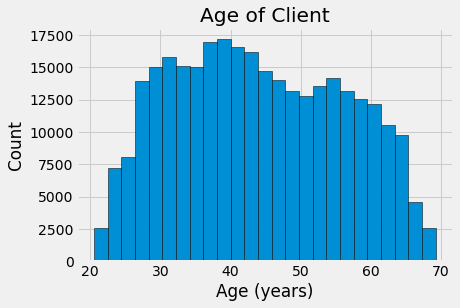

In [11]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 364.25, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

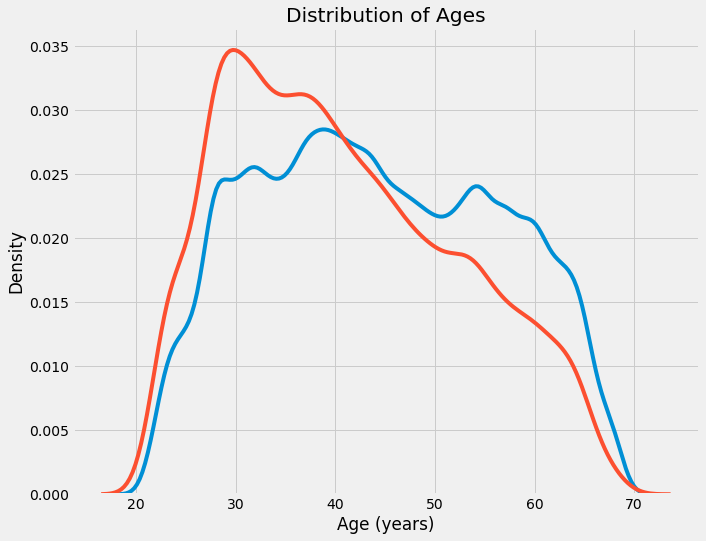

In [889]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 364.25, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 364.25, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [890]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 364.25

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.973919  (25.0, 30.0]
1       0       16765    46.026081  (45.0, 50.0]
2       0       19046    52.288264  (50.0, 55.0]
3       0       19005    52.175704  (50.0, 55.0]
4       0       19932    54.720659  (50.0, 55.0]
5       0       16941    46.509266  (45.0, 50.0]
6       0       13778    37.825669  (35.0, 40.0]
7       0       18850    51.750172  (50.0, 55.0]
8       0       20099    55.179135  (55.0, 60.0]
9       0       14469    39.722718  (35.0, 40.0]

In [891]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123627   8521.241885    23.393938
(25.0, 30.0]  0.111330  10134.534929    27.823020
(30.0, 35.0]  0.103122  11829.357529    32.475930
(35.0, 40.0]  0.089333  13681.492829    37.560722
(40.0, 45.0]  0.078798  15466.092125    42.460102
(45.0, 50.0]  0.074244  17284.618272    47.452624
(50.0, 55.0]  0.067530  19151.633894    52.578267
(55.0, 60.0]  0.055305  20934.994584    57.474247
(60.0, 65.0]  0.052609  22728.532069    62.398166
(65.0, 70.0]  0.038697  24243.467074    66.557219

In [892]:
# Put test features into dataframe
#poly_features_test = pd.DataFrame(poly_features_test, 
#                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
#                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
#poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
#app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
#poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
#app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
#app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
#print('Training data with polynomial features shape: ', app_train_poly.shape)
#print('Testing data with polynomial features shape:  ', app_test_poly.shape)

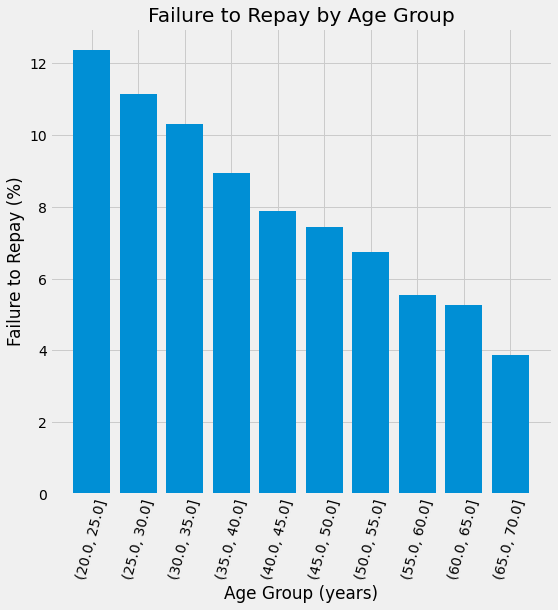

In [893]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

#### 年齢から個人を特定する

In [12]:
#必要な変数のみ抽出
train2 = app_train_origin[["SK_ID_CURR","DAYS_BIRTH","DAYS_EMPLOYED","DAYS_REGISTRATION",
               "DAYS_ID_PUBLISH","CODE_GENDER","REGION_POPULATION_RELATIVE","TARGET"]].copy()
test2 = app_test_origin[["SK_ID_CURR","DAYS_BIRTH","DAYS_EMPLOYED","DAYS_REGISTRATION",
               "DAYS_ID_PUBLISH","CODE_GENDER","REGION_POPULATION_RELATIVE"]].copy()
train2.head()

SK_ID_CURR  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0      100002       -9461           -637            -3648.0            -2120   
1      100003      -16765          -1188            -1186.0             -291   
2      100004      -19046           -225            -4260.0            -2531   
3      100006      -19005          -3039            -9833.0            -2437   
4      100007      -19932          -3038            -4311.0            -3458   

  CODE_GENDER  REGION_POPULATION_RELATIVE  TARGET  
0           M                    0.018801       1  
1           F                    0.003541       0  
2           M                    0.010032       0  
3           F                    0.008019       0  
4           M                    0.028663       0

In [13]:
# テストデータにフラグ立て
train2["test_flg"] = 0
test2["test_flg"] = 1

# トレーニングデータとテストデータを縦結合
train_test = pd.concat([train2, test2], axis = 0)
del train2, test2
train_test.head()

SK_ID_CURR  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0      100002       -9461           -637            -3648.0            -2120   
1      100003      -16765          -1188            -1186.0             -291   
2      100004      -19046           -225            -4260.0            -2531   
3      100006      -19005          -3039            -9833.0            -2437   
4      100007      -19932          -3038            -4311.0            -3458   

  CODE_GENDER  REGION_POPULATION_RELATIVE  TARGET  test_flg  
0           M                    0.018801     1.0         0  
1           F                    0.003541     0.0         0  
2           M                    0.010032     0.0         0  
3           F                    0.008019     0.0         0  
4           M                    0.028663     0.0         0

In [14]:
train_test["DAYS_BIRTH"].describe()

count    356255.000000
mean     -16041.248841
std        4358.803980
min      -25229.000000
25%      -19676.000000
50%      -15755.000000
75%      -12425.000000
max       -7338.000000
Name: DAYS_BIRTH, dtype: float64

In [15]:
train_test["DAYS_BIRTH"].max()/364.25, train_test["DAYS_BIRTH"].min()/364.25

(-20.145504461221687, -69.26286890871654)

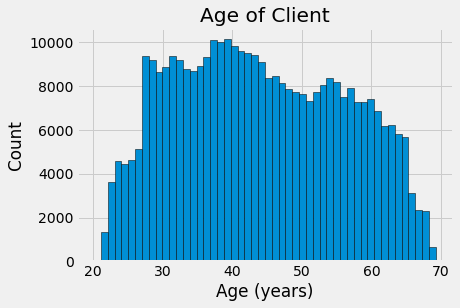

In [16]:
plt.hist(abs(train_test['DAYS_BIRTH'])/364.25, edgecolor = 'k', bins = 50)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

<b>マイナス反転しているが、申込者の年齢は20歳～70歳の間。つまり「誕生日は申込日の何日前か」という定義だと考えられる。</b>

In [17]:
train_test["DAYS_REGISTRATION"].describe() 

count    356255.000000
mean      -4983.593527
std        3526.968986
min      -24672.000000
25%       -7477.000000
50%       -4502.000000
75%       -1995.000000
max           0.000000
Name: DAYS_REGISTRATION, dtype: float64

In [18]:
train_test["DAYS_REGISTRATION"].mean()/364.25, train_test["DAYS_REGISTRATION"].min()/364.25

(-13.681794172204116, -67.73369938229239)

In [19]:
train_test["DAYS_ID_PUBLISH"].describe() 

count    356255.000000
mean      -3002.071163
std        1517.901735
min       -7197.000000
25%       -4318.000000
50%       -3252.000000
75%       -1717.000000
max           0.000000
Name: DAYS_ID_PUBLISH, dtype: float64

In [20]:
train_test["DAYS_ID_PUBLISH"].mean()/364.25, train_test["DAYS_ID_PUBLISH"].min()/364.25

(-8.241787680192175, -19.75840768702814)

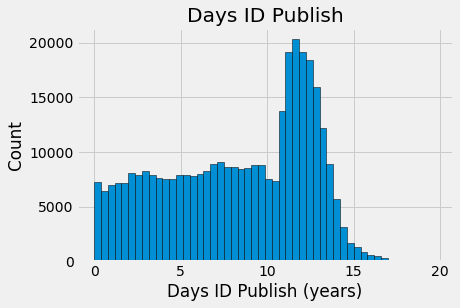

In [21]:
plt.hist(abs(train_test['DAYS_ID_PUBLISH'])/364.25, edgecolor = 'k', bins = 50)
plt.title('Days ID Publish'); plt.xlabel('Days ID Publish (years)'); plt.ylabel('Count');

<div>
    登録日（何の登録日かは不明）の最短は申込日からさかのぼって13年前。最長で申込日から65年前。
</div>
<div>
    個人ID（身分証明証？）の変更日は最長でも申込日から20年前未満
</div>

- DAYS_REGISTRATION - DAYS_BIRTHをすれば誕生日から登録変更日までの日数を計算可能
- DAYS_ID_PUBLIS - DAYS_BIRTHをすれば誕生日から個人ID変更日までの日数を計算可能

<div>
    この計算結果とCODE_GENDER, REGION_POPULATION_RELATIVEで、ある程度正確な個人のユニークキーになる
</div>

In [22]:
train_test["DAYS_REGISTRATION"] = train_test["DAYS_REGISTRATION"] - train_test["DAYS_BIRTH"]
train_test["DAYS_ID_PUBLISH"] = train_test["DAYS_ID_PUBLISH"] - train_test["DAYS_BIRTH"]

In [26]:
# 個人単位で申込件数を集計
group_cols = ["DAYS_REGISTRATION","DAYS_ID_PUBLISH","CODE_GENDER","REGION_POPULATION_RELATIVE"]
res = train_test[group_cols].value_counts().reset_index()
res = res.rename(columns = {0:"count"})

In [27]:
#確認のため申し込み件数の降順ソート
res = res.sort_values(by = "count", ascending = False)

In [28]:
#結果の確認
res.head()

DAYS_REGISTRATION  DAYS_ID_PUBLISH CODE_GENDER  \
0              5905.0             7940           M   
94             6234.0            10113           M   
88             9205.0             8293           F   
89            17136.0            17136           F   
90             8654.0             7336           M   

    REGION_POPULATION_RELATIVE  count  
0                     0.035792      5  
94                    0.009549      3  
88                    0.010966      3  
89                    0.019689      3  
90                    0.018209      3

In [908]:
res["count"].describe()

count    347078.000000
mean          1.026441
std           0.162972
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: count, dtype: float64

trainとtest合わせると最大で5回申し込みしている顧客が存在

In [909]:
#2回以上申し込みをしている顧客のみ抽出
res = res.query("count > 1").reset_index().drop(columns = ["index", "count"])
res.shape

(9038, 4)

In [910]:
#複数回申し込み顧客にindexを付与する
res = res.reset_index()

In [911]:
#train_testに複数回申し込みindexを付与
train_test = pd.merge(train_test, res,how = "left",
                      on = ['DAYS_REGISTRATION','DAYS_ID_PUBLISH','CODE_GENDER','REGION_POPULATION_RELATIVE'])
train_test.head()

SK_ID_CURR  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0      100002       -9461           -637             5813.0             7341   
1      100003      -16765          -1188            15579.0            16474   
2      100004      -19046           -225            14786.0            16515   
3      100006      -19005          -3039             9172.0            16568   
4      100007      -19932          -3038            15621.0            16474   

  CODE_GENDER  REGION_POPULATION_RELATIVE  TARGET  test_flg  index  
0           M                    0.018801     1.0         0    NaN  
1           F                    0.003541     0.0         0    NaN  
2           M                    0.010032     0.0         0    NaN  
3           F                    0.008019     0.0         0    NaN  
4           M                    0.028663     0.0         0    NaN

train, test全体で申し込み回数が1回のみの顧客は、indexがNaNになる。

In [912]:
#index, DAYS_BIRTHでソート。
train_test = train_test.sort_values(by = ["index", "DAYS_BIRTH"], ascending = True)

index, DAYS_BIRTHでソート。複数回申し込み顧客は申込み日が新しい順版に並ぶ。

In [913]:
#1行下レコードのTARGETの値をlag_targetに格納→前回の申し込み結果
train_test["lag_target"] =  train_test.groupby(['index'])['TARGET'].shift(-1)
#1行上レコードのTARGETの値をlag_targetに格納→次回の申し込み結果
train_test["lead_target"] =  train_test.groupby(['index'])['TARGET'].shift(1)
train_test.head(10)

SK_ID_CURR  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
109802      227347      -12136          -1089             5905.0   
193588      324489      -12085          -1038             5905.0   
212540      346298      -11971           -924             5905.0   
55743       164588      -11963           -916             5905.0   
115899      234406      -11908           -526             5905.0   
345311      376537      -12233          -1216             6234.0   
349106      405121      -12177          -1189             6234.0   
69089       180131      -12017          -1639             6234.0   
348612      402260      -12971          -1578             9205.0   
221275      356325      -12780          -1507             9205.0   

        DAYS_ID_PUBLISH CODE_GENDER  REGION_POPULATION_RELATIVE  TARGET  \
109802             7940           M                    0.035792     0.0   
193588             7940           M                    0.035792     0.0   
212540             7940           M                    0.035792     0.0   
55743              7940           M                    0.035792     0.0   
115899             7940           M                    0.035792     0.0   
345311            10113           M                    0.009549     NaN   
349106            10113           M                    0.009549     NaN   
69089             10113           M                    0.009549     0.0   
348612             8293           F                    0.010966     NaN   
221275             8293           F                    0.010966     0.0   

        test_flg  index  lag_target  lead_target  
109802         0    0.0         0.0          NaN  
193588         0    0.0         0.0          0.0  
212540         0    0.0         0.0          0.0  
55743          0    0.0         0.0          0.0  
115899         0    0.0         NaN          0.0  
345311         1    1.0         NaN          NaN  
349106         1    1.0         0.0          NaN  
69089          0    1.0         NaN          NaN  
348612         1    2.0         0.0          NaN  
221275         0    2.0         0.0          NaN

In [914]:
#サンプルチェック
train_test.query("index == 1")

SK_ID_CURR  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
345311      376537      -12233          -1216             6234.0   
349106      405121      -12177          -1189             6234.0   
69089       180131      -12017          -1639             6234.0   

        DAYS_ID_PUBLISH CODE_GENDER  REGION_POPULATION_RELATIVE  TARGET  \
345311            10113           M                    0.009549     NaN   
349106            10113           M                    0.009549     NaN   
69089             10113           M                    0.009549     0.0   

        test_flg  index  lag_target  lead_target  
345311         1    1.0         NaN          NaN  
349106         1    1.0         0.0          NaN  
69089          0    1.0         NaN          NaN

In [915]:
train_test.query("test_flg == 0").groupby("lag_target")["TARGET"].agg(["mean", "count","sum"])

mean  count    sum
lag_target                        
0.0         0.067045   5280  354.0
1.0         0.828125    192  159.0

トレーニングデータ上、前回申し込みでTARGET=1の顧客(lag_target=1のとき)は、その回の申し込みでTARGET=1になる割合が82.8125%になる。

In [916]:
train_test.query("test_flg == 1").groupby("lag_target")["test_flg"].agg(["count"])

count
lag_target       
0.0          3600
1.0            77

<div>テストデータ上でも同様の顧客レコードが77件あり、このレコードの予測値を「1」とするだけで精度が向上する可能性が高い。</div>
ただし77レコードのみであるため、効果は限定的。

In [917]:
train_test.groupby("lead_target")["TARGET","test_flg"].agg(["mean", "count","sum"])

TARGET               test_flg          
                 mean count    sum      mean count sum
lead_target                                           
0.0          0.006655  4959   33.0  0.003216  4975  16
1.0          0.309942   513  159.0  0.001946   514   1

In [918]:
train_test.query("test_flg == 0").groupby("lead_target")["TARGET"].agg(["mean", "count","sum"])

mean  count    sum
lead_target                        
0.0          0.006655   4959   33.0
1.0          0.309942    513  159.0

次回の申し込みでTARGET=1になるレコード（lerd_target=1のレコード）もTARGET=1になる割合が30.9942%ある。

In [919]:
train_test.query("test_flg == 1").groupby("lead_target")["test_flg"].agg(["count"])

count
lead_target       
0.0             16
1.0              1

<div>ただしテストデータ上で次回申し込みがあるレコードは1件しか無い。</div>したがってテストデータは、各顧客の最新申し込みデータで作成されていると思われる。

### Polynomial Features

In [920]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']].copy()
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].copy()

# imputer for handling missing values
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer as Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [921]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [922]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [923]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [924]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].copy()
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

In [925]:
poly_features.head()

1  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  EXT_SOURCE_1^2  \
0  1.0      0.083037      0.262949      0.139376      9461.0        0.006895   
1  1.0      0.311267      0.622246      0.535276     16765.0        0.096887   
2  1.0      0.505998      0.555912      0.729567     19046.0        0.256034   
3  1.0      0.505998      0.650442      0.535276     19005.0        0.256034   
4  1.0      0.505998      0.322738      0.535276     19932.0        0.256034   

   EXT_SOURCE_1 EXT_SOURCE_2  EXT_SOURCE_1 EXT_SOURCE_3  \
0                   0.021834                   0.011573   
1                   0.193685                   0.166614   
2                   0.281290                   0.369159   
3                   0.329122                   0.270849   
4                   0.163305                   0.270849   

   EXT_SOURCE_1 DAYS_BIRTH  EXT_SOURCE_2^2  ...  EXT_SOURCE_2^2 EXT_SOURCE_3  \
0               785.612748        0.069142  ...                     0.009637   
1              5218.396475        0.387190  ...                     0.207254   
2              9637.236584        0.309038  ...                     0.225464   
3              9616.490669        0.423074  ...                     0.226462   
4             10085.550751        0.104160  ...                     0.055754   

   EXT_SOURCE_2^2 DAYS_BIRTH  EXT_SOURCE_2 EXT_SOURCE_3^2  \
0                 654.152107                     0.005108   
1                6491.237078                     0.178286   
2                5885.942404                     0.295894   
3                8040.528832                     0.186365   
4                2076.117157                     0.092471   

   EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH  EXT_SOURCE_2 DAYS_BIRTH^2  \
0                            346.733022               2.353667e+07   
1                           5583.975307               1.748916e+08   
2                           7724.580288               2.016572e+08   
3                           6616.894625               2.349331e+08   
4                           3443.335521               1.282190e+08   

   EXT_SOURCE_3^3  EXT_SOURCE_3^2 DAYS_BIRTH  EXT_SOURCE_3 DAYS_BIRTH^2  \
0        0.002707                 183.785678               1.247560e+07   
1        0.153368                4803.518937               1.504475e+08   
2        0.388325               10137.567875               2.646504e+08   
3        0.153368                5445.325225               1.933364e+08   
4        0.153368                5710.929881               2.126570e+08   

   DAYS_BIRTH^3  TARGET  
0  8.468590e+11       1  
1  4.712058e+12       0  
2  6.908939e+12       0  
3  6.864416e+12       0  
4  7.918677e+12       0  

[5 rows x 36 columns]

### Pairs Plot

In [926]:
# Copy the data for plotting
#plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
#plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
#plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
#def corr_func(x, y, **kwargs):
#    r = np.corrcoef(x, y)[0][1]
#    ax = plt.gca()
#    ax.annotate("r = {:.2f}".format(r),
#                xy=(.2, .8), xycoords=ax.transAxes,
#                size = 20)

# Create the pairgrid object
#grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
#                    hue = 'TARGET', 
#                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
#grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
#grid.map_diag(sns.kdeplot)

# Bottom is density plot
#grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

#plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

### Exterior Sources(外部ソース1~3)

In [927]:
plt.figure(figsize = (8, 6))

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

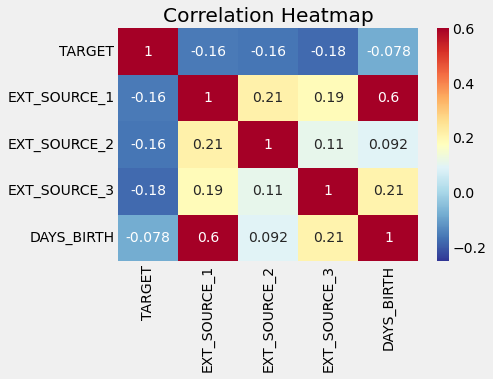

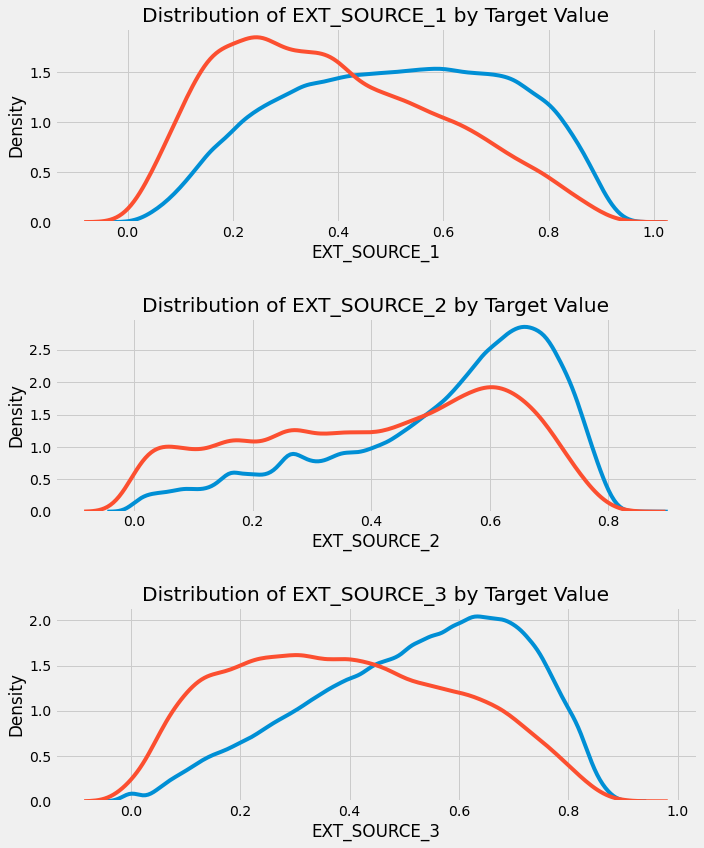

In [928]:
# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### Domain Knowledge Features

In [929]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [930]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

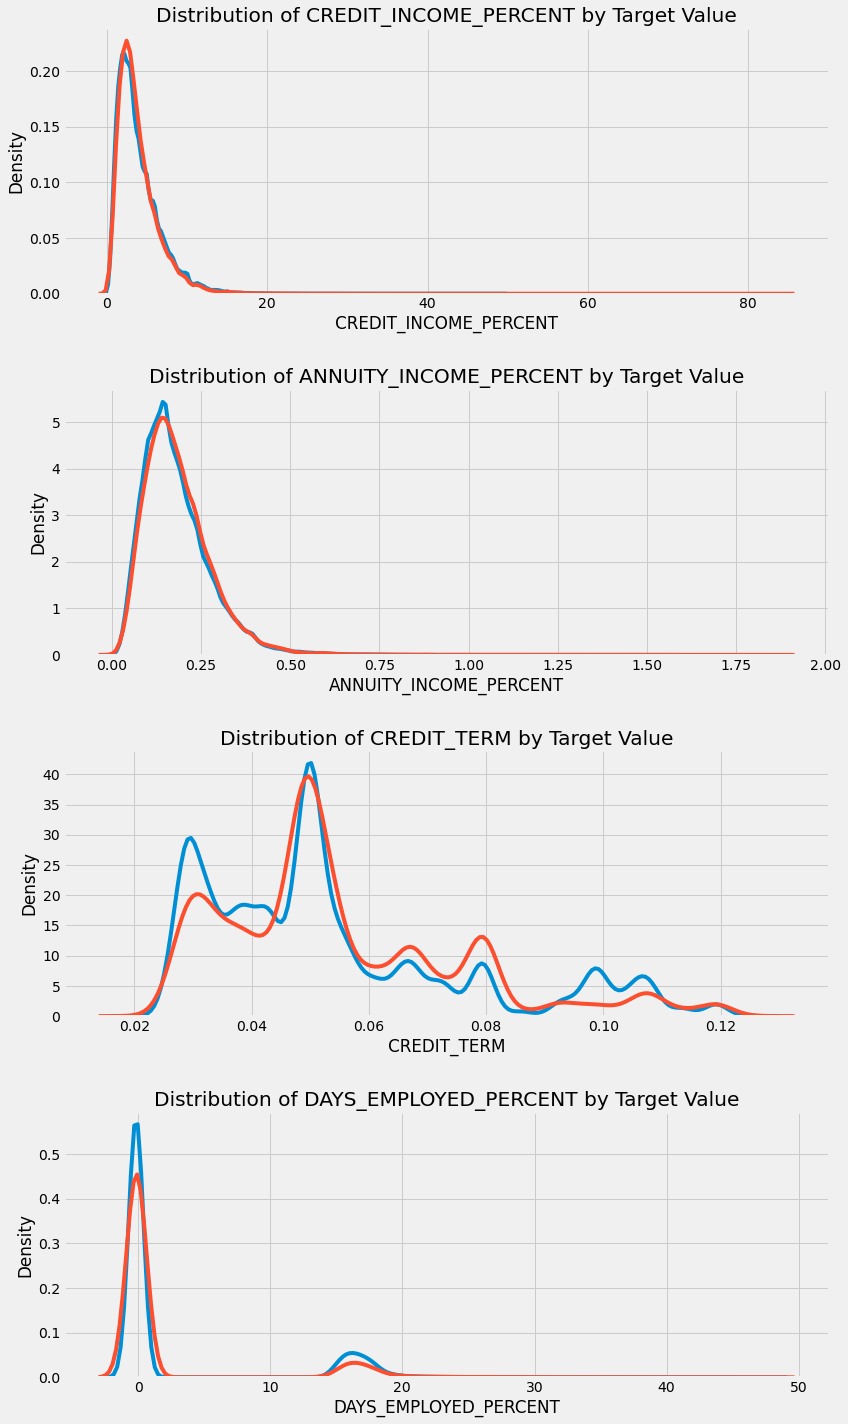

In [931]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [932]:
app_train['CREDIT_TERM'] = app_train_domain['CREDIT_TERM'].copy()
app_test['CREDIT_TERM'] = app_test_domain['CREDIT_TERM'].copy()

In [933]:
app_train[['CREDIT_TERM', 'TARGET']].corr()

CREDIT_TERM    TARGET
CREDIT_TERM     1.000000  0.012704
TARGET          0.012704  1.000000

In [934]:
app_train['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED_PERCENT'].copy()
app_test['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED_PERCENT'].copy()

In [935]:
app_train[['DAYS_EMPLOYED_PERCENT', 'TARGET']].corr()

DAYS_EMPLOYED_PERCENT    TARGET
DAYS_EMPLOYED_PERCENT               1.000000 -0.042206
TARGET                             -0.042206  1.000000

## applifcationの特徴量をカラムごとに確認

### DAYS_LAST_PHONE_CHANGE

In [936]:
### Originから切り戻し
app_train['DAYS_LAST_PHONE_CHANGE'] = app_train_origin['DAYS_LAST_PHONE_CHANGE'].copy()
app_test['DAYS_LAST_PHONE_CHANGE'] = app_test_origin['DAYS_LAST_PHONE_CHANGE'].copy()
app_train['DAYS_LAST_PHONE_CHANGE'].isnull().sum()

1

In [937]:
app_train[['DAYS_LAST_PHONE_CHANGE']].value_counts()

DAYS_LAST_PHONE_CHANGE
 0.0                      37672
-1.0                       2812
-2.0                       2318
-3.0                       1763
-4.0                       1285
                          ...  
-3740.0                       1
-3744.0                       1
-3745.0                       1
-3747.0                       1
-4292.0                       1
Length: 3773, dtype: int64

In [938]:
app_train[['DAYS_LAST_PHONE_CHANGE', 'TARGET']].corr()

DAYS_LAST_PHONE_CHANGE    TARGET
DAYS_LAST_PHONE_CHANGE                1.000000  0.055218
TARGET                                0.055218  1.000000

In [939]:
# 0埋めで欠損値補完
app_train['DAYS_LAST_PHONE_CHANGE'] = app_train['DAYS_LAST_PHONE_CHANGE'].fillna(1)
app_test['DAYS_LAST_PHONE_CHANGE'] = app_test['DAYS_LAST_PHONE_CHANGE'].fillna(1)

In [940]:
app_train[['DAYS_LAST_PHONE_CHANGE', 'TARGET']].corr()

DAYS_LAST_PHONE_CHANGE    TARGET
DAYS_LAST_PHONE_CHANGE                1.000000  0.055217
TARGET                                0.055217  1.000000

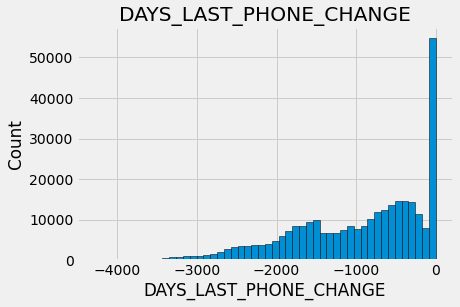

In [941]:
plt.hist(app_train['DAYS_LAST_PHONE_CHANGE'], edgecolor = 'k', bins = 50)
plt.title('DAYS_LAST_PHONE_CHANGE'); plt.xlabel('DAYS_LAST_PHONE_CHANGE'); plt.ylabel('Count');

The correlation between DAYS_LAST_PHONE_CHANGE and the TARGET is 0.0552
Median value for loan that was not repaid = -594.0000
Median value for loan that was repaid =     -776.0000


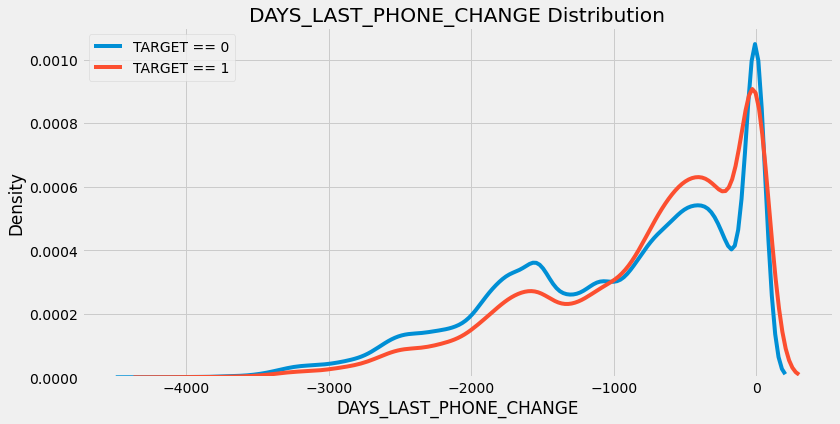

In [942]:
kde_target('DAYS_LAST_PHONE_CHANGE', app_train)

In [943]:
## Yao-Johnson変換
#num_cols = ['DAYS_LAST_PHONE_CHANGE']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['DAYS_LAST_PHONE_CHANGE'] = pt.transform(app_train[num_cols])
#app_test['DAYS_LAST_PHONE_CHANGE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'DAYS_LAST_PHONE_CHANGE']].corr()

In [944]:
## 標準化
num_cols = ['DAYS_LAST_PHONE_CHANGE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['DAYS_LAST_PHONE_CHANGE', 'TARGET']].corr()

DAYS_LAST_PHONE_CHANGE    TARGET
DAYS_LAST_PHONE_CHANGE                1.000000  0.055217
TARGET                                0.055217  1.000000

The correlation between DAYS_LAST_PHONE_CHANGE and the TARGET is 0.0552
Median value for loan that was not repaid = 0.4461
Median value for loan that was repaid =     0.2260


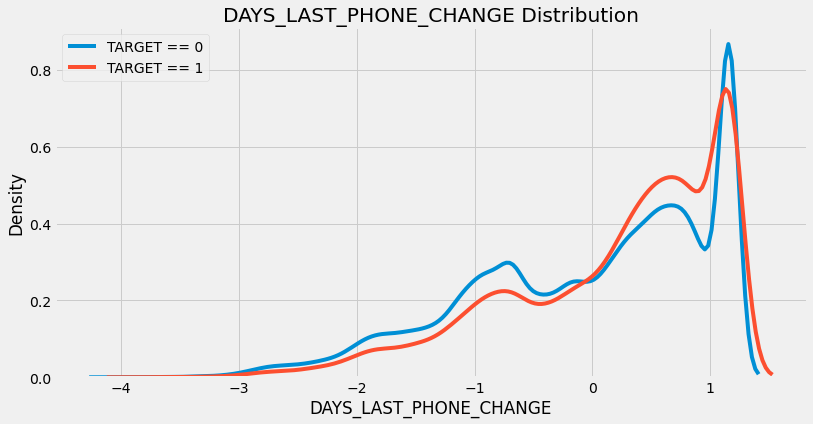

In [945]:
## Yao-Johnson変換後の特徴量の分布
kde_target('DAYS_LAST_PHONE_CHANGE', app_train)

### CNT_FAM_MENBERS

In [946]:
### Originから切り戻し
app_train['CNT_FAM_MEMBERS'] = app_train_origin['CNT_FAM_MEMBERS'].copy()
app_test['CNT_FAM_MEMBERS'] = app_test_origin['CNT_FAM_MEMBERS'].copy()
app_train['CNT_FAM_MEMBERS'].isnull().sum()

2

In [947]:
app_train['CNT_FAM_MEMBERS'].value_counts()

2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [948]:
app_train[['TARGET', 'CNT_FAM_MEMBERS']].corr()

TARGET  CNT_FAM_MEMBERS
TARGET           1.000000         0.009308
CNT_FAM_MEMBERS  0.009308         1.000000

In [949]:
### 0埋めで欠損値補完
app_train['CNT_FAM_MEMBERS'] = app_train['CNT_FAM_MEMBERS'].fillna(0)
app_test['CNT_FAM_MEMBERS'] = app_test['CNT_FAM_MEMBERS'].fillna(0)
app_train['CNT_FAM_MEMBERS'].isnull().sum()

0

In [950]:
app_train[['TARGET', 'CNT_FAM_MEMBERS']].corr()

TARGET  CNT_FAM_MEMBERS
TARGET           1.000000         0.009312
CNT_FAM_MEMBERS  0.009312         1.000000

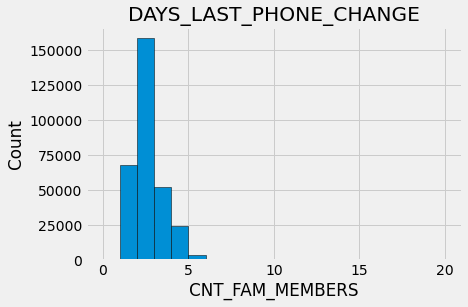

In [951]:
plt.hist(app_train['CNT_FAM_MEMBERS'], edgecolor = 'k', bins = 20)
plt.title('DAYS_LAST_PHONE_CHANGE'); plt.xlabel('CNT_FAM_MEMBERS'); plt.ylabel('Count');

The correlation between CNT_FAM_MEMBERS and the TARGET is 0.0093
Median value for loan that was not repaid = 2.0000
Median value for loan that was repaid =     2.0000


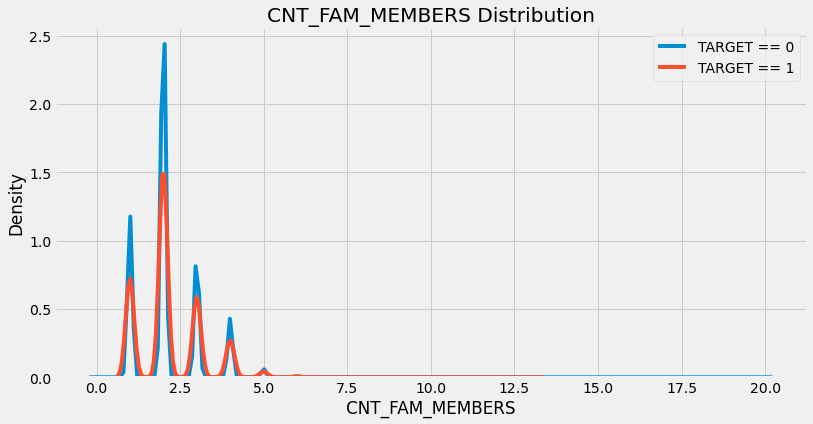

In [952]:
### 目的変数との関係を可視化
kde_target('CNT_FAM_MEMBERS', app_train)

### AMT_ANNUITY

In [953]:
app_train[['AMT_ANNUITY']].isnull().sum()

AMT_ANNUITY    12
dtype: int64

In [954]:
app_train['AMT_ANNUITY'].value_counts()

9000.0      6385
13500.0     5514
6750.0      2279
10125.0     2035
37800.0     1602
            ... 
79902.0        1
106969.5       1
60885.0        1
59661.0        1
77809.5        1
Name: AMT_ANNUITY, Length: 13672, dtype: int64

In [955]:
app_train[['TARGET', 'AMT_ANNUITY']].corr()

TARGET  AMT_ANNUITY
TARGET       1.000000    -0.012817
AMT_ANNUITY -0.012817     1.000000

In [956]:
### 0埋めで欠損値補完
app_train['AMT_ANNUITY'] = app_train['AMT_ANNUITY'].fillna(0)
app_test['AMT_ANNUITY'] = app_test['AMT_ANNUITY'].fillna(0)

In [957]:
app_train[['TARGET', 'AMT_ANNUITY']].corr()

TARGET  AMT_ANNUITY
TARGET       1.000000    -0.012794
AMT_ANNUITY -0.012794     1.000000

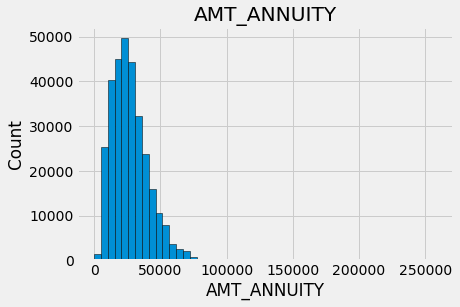

In [958]:
### ヒストグラム
plt.hist(app_train['AMT_ANNUITY'], edgecolor = 'k', bins = 50)
plt.title('AMT_ANNUITY'); plt.xlabel('AMT_ANNUITY'); plt.ylabel('Count');

The correlation between AMT_ANNUITY and the TARGET is -0.0128
Median value for loan that was not repaid = 25263.0000
Median value for loan that was repaid =     24876.0000


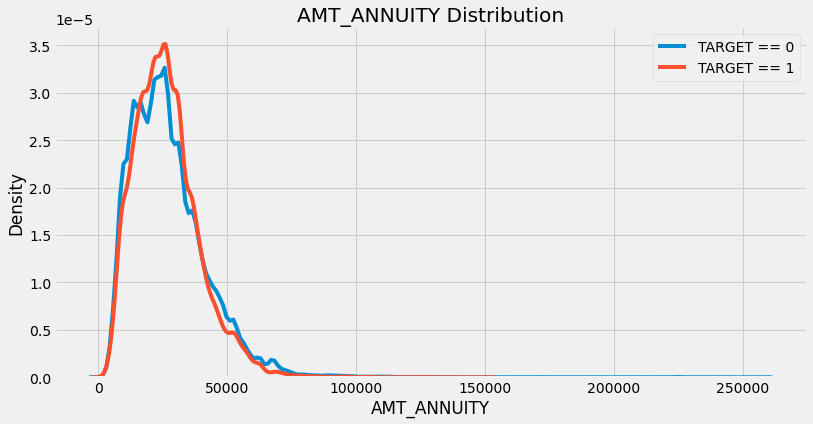

In [959]:
### 目的変数との関係を可視化
kde_target('AMT_ANNUITY', app_train)

In [960]:
## 標準化
num_cols = ['AMT_ANNUITY']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['AMT_ANNUITY', 'TARGET']].corr()

AMT_ANNUITY    TARGET
AMT_ANNUITY     1.000000 -0.012794
TARGET         -0.012794  1.000000

### AMT_CREDIT

In [961]:
app_train[['AMT_CREDIT']].isnull().sum()

AMT_CREDIT    0
dtype: int64

In [962]:
## 標準化
num_cols = ['AMT_CREDIT']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['AMT_CREDIT', 'TARGET']].corr()

AMT_CREDIT    TARGET
AMT_CREDIT    1.000000 -0.030369
TARGET       -0.030369  1.000000

### NAME_TYPE_SUITE

In [963]:
app_train[['NAME_TYPE_SUITE']].isnull().sum()

NAME_TYPE_SUITE    1292
dtype: int64

参考
https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction

In [964]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [965]:
app_train[['TARGET', 'AMT_CREDIT']].corr()

TARGET  AMT_CREDIT
TARGET      1.000000   -0.030369
AMT_CREDIT -0.030369    1.000000

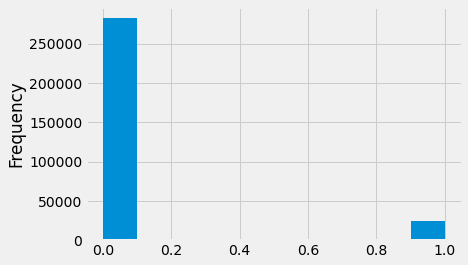

In [966]:
app_train['TARGET'].astype(int).plot.hist();

### NAME_CONTRACT_TYPE(支払方法(現金/リボ))

In [967]:
### Originから切り戻し
app_train['NAME_CONTRACT_TYPE'] = app_train_origin['NAME_CONTRACT_TYPE'].copy()
app_test['NAME_CONTRACT_TYPE'] = app_test_origin['NAME_CONTRACT_TYPE'].copy()
app_train['NAME_CONTRACT_TYPE'].isnull().sum()

0

In [968]:
app_train['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [969]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'NAME_CONTRACT_TYPE')
app_train['NAME_CONTRACT_TYPE'].value_counts()

0    278232
1     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [970]:
app_train[['TARGET', 'NAME_CONTRACT_TYPE']].corr()

TARGET  NAME_CONTRACT_TYPE
TARGET              1.000000           -0.030896
NAME_CONTRACT_TYPE -0.030896            1.000000

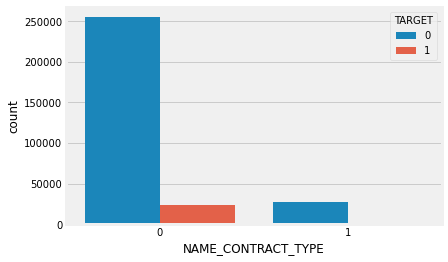

In [971]:
%matplotlib inline
sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 性別

In [972]:
### Originから切り戻し
app_train['CODE_GENDER'] = app_train_origin['CODE_GENDER'].copy()
app_test['CODE_GENDER'] = app_test_origin['CODE_GENDER'].copy()
app_train['CODE_GENDER'].isnull().sum()

0

In [973]:
app_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [974]:
# ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'CODE_GENDER')

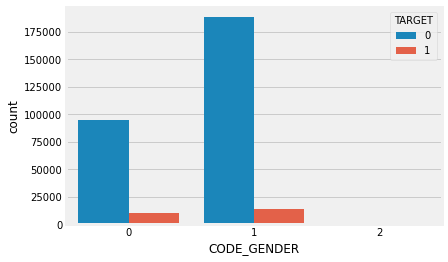

In [975]:
%matplotlib inline
sns.countplot(x='CODE_GENDER', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 車所有フラグ

In [976]:
### Originから切り戻し
app_train['FLAG_OWN_CAR'] = app_train_origin['FLAG_OWN_CAR'].copy()
app_test['FLAG_OWN_CAR'] = app_test_origin['FLAG_OWN_CAR'].copy()
app_train['FLAG_OWN_CAR'].isnull().sum()

0

In [977]:
app_train['FLAG_OWN_CAR'].value_counts()

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

In [978]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'FLAG_OWN_CAR')

In [979]:
app_train[['FLAG_OWN_CAR', 'TARGET']].corr()

FLAG_OWN_CAR    TARGET
FLAG_OWN_CAR      1.000000 -0.021851
TARGET           -0.021851  1.000000

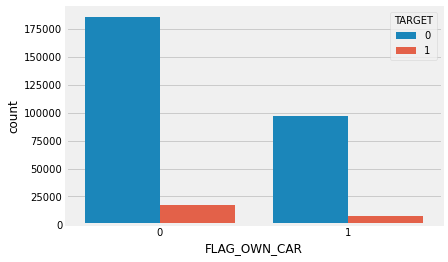

In [980]:
%matplotlib inline
sns.countplot(x='FLAG_OWN_CAR', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 不動産所有フラグ

In [981]:
### Originから切り戻し
app_train['FLAG_OWN_REALTY'] = app_train_origin['FLAG_OWN_REALTY'].copy()
app_test['FLAG_OWN_REALTY'] = app_test_origin['FLAG_OWN_REALTY'].copy()
app_train['FLAG_OWN_REALTY'].isnull().sum()

0

In [982]:
app_train['FLAG_OWN_REALTY'].value_counts()

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

In [983]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'FLAG_OWN_REALTY')

In [984]:
app_train[['FLAG_OWN_REALTY', 'TARGET']].corr()

FLAG_OWN_REALTY    TARGET
FLAG_OWN_REALTY         1.000000  0.006148
TARGET                  0.006148  1.000000

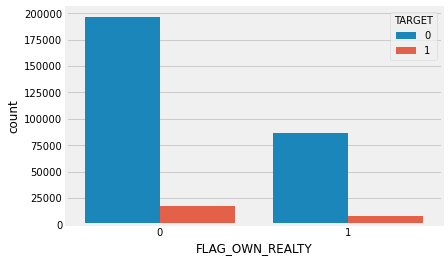

In [985]:
%matplotlib inline
sns.countplot(x='FLAG_OWN_REALTY', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 雇用種別

In [986]:
### Originから切り戻し
app_train['OCCUPATION_TYPE'] = app_train_origin['OCCUPATION_TYPE'].copy()
app_test['OCCUPATION_TYPE'] = app_test_origin['OCCUPATION_TYPE'].copy()
app_train['OCCUPATION_TYPE'].isnull().sum()

96391

In [987]:
app_train['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [988]:
app_train['OCCUPATION_TYPE'].isnull().sum()

96391

In [989]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'OCCUPATION_TYPE')

In [990]:
app_train[['OCCUPATION_TYPE', 'TARGET']].corr()

OCCUPATION_TYPE    TARGET
OCCUPATION_TYPE         1.000000 -0.000573
TARGET                 -0.000573  1.000000

In [991]:
#app_train['OCCUPATION_TYPE'].fillna(0, inplace=True)
#app_test['OCCUPATION_TYPE'].fillna(0, inplace=True)

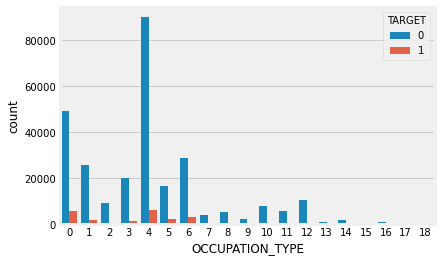

In [992]:
%matplotlib inline
sns.countplot(x='OCCUPATION_TYPE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [993]:
#app_train.drop(['OCCUPATION_TYPE'], axis=1, inplace=True)
#app_test.drop(['OCCUPATION_TYPE'], axis=1, inplace=True)

### 家族ステータス

In [994]:
### Originから切り戻し
app_train['NAME_FAMILY_STATUS'] = app_train_origin['NAME_FAMILY_STATUS'].copy()
app_test['NAME_FAMILY_STATUS'] = app_test_origin['NAME_FAMILY_STATUS'].copy()
app_train['NAME_FAMILY_STATUS'].isnull().sum()

0

In [995]:
app_train['NAME_FAMILY_STATUS'].value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [996]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'NAME_FAMILY_STATUS')

In [997]:
app_train[['TARGET', 'NAME_FAMILY_STATUS']].corr()

TARGET  NAME_FAMILY_STATUS
TARGET              1.000000           -0.010696
NAME_FAMILY_STATUS -0.010696            1.000000

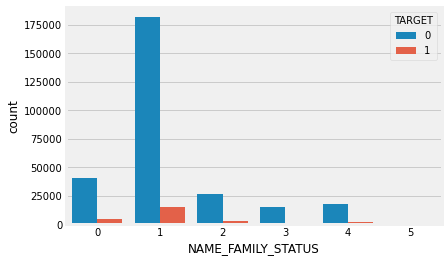

In [998]:
%matplotlib inline
sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 居住タイプ

In [999]:
### Originから切り戻し
app_train['NAME_HOUSING_TYPE'] = app_train_origin['NAME_HOUSING_TYPE'].copy()
app_test['NAME_HOUSING_TYPE'] = app_test_origin['NAME_HOUSING_TYPE'].copy()
app_train['NAME_HOUSING_TYPE'].isnull().sum()

0

In [1000]:
app_train['NAME_HOUSING_TYPE'].value_counts()

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64

In [1001]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'NAME_HOUSING_TYPE')

In [1002]:
app_train[['TARGET', 'NAME_HOUSING_TYPE']].corr()

TARGET  NAME_HOUSING_TYPE
TARGET             1.000000           0.018335
NAME_HOUSING_TYPE  0.018335           1.000000

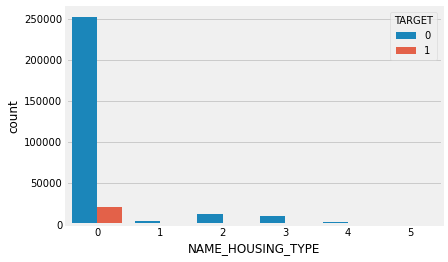

In [1003]:
%matplotlib inline
sns.countplot(x='NAME_HOUSING_TYPE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### NAME_INCOME_TYPE

In [1004]:
### Originから切り戻し
app_train['NAME_INCOME_TYPE'] = app_train_origin['NAME_INCOME_TYPE'].copy()
app_test['NAME_INCOME_TYPE'] = app_test_origin['NAME_INCOME_TYPE'].copy()
app_train['NAME_INCOME_TYPE'].isnull().sum()

0

In [1005]:
app_train['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [1006]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'NAME_INCOME_TYPE')

In [1007]:
app_train[['TARGET', 'NAME_INCOME_TYPE']].corr()

TARGET  NAME_INCOME_TYPE
TARGET            1.00000          -0.05702
NAME_INCOME_TYPE -0.05702           1.00000

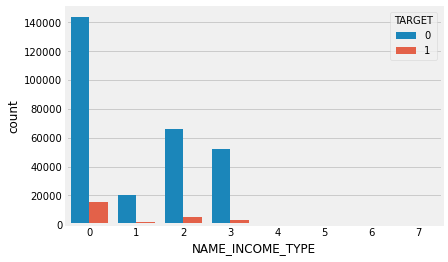

In [1008]:
%matplotlib inline
sns.countplot(x='NAME_INCOME_TYPE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 教育レベル

In [1009]:
### Originから切り戻し
app_train['NAME_EDUCATION_TYPE'] = app_train_origin['NAME_EDUCATION_TYPE'].copy()
app_test['NAME_EDUCATION_TYPE'] = app_test_origin['NAME_EDUCATION_TYPE'].copy()
app_train['NAME_EDUCATION_TYPE'].isnull().sum()

0

In [1010]:
app_train['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [1011]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'NAME_EDUCATION_TYPE')

In [1012]:
app_train[['TARGET', 'NAME_EDUCATION_TYPE']].corr()

TARGET  NAME_EDUCATION_TYPE
TARGET               1.000000            -0.032434
NAME_EDUCATION_TYPE -0.032434             1.000000

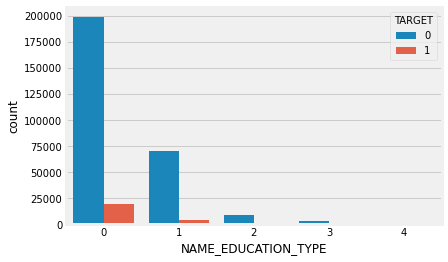

In [1013]:
%matplotlib inline
sns.countplot(x='NAME_EDUCATION_TYPE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### ローン対象の金額

In [1014]:
### Originから切り戻し
app_train['AMT_GOODS_PRICE'] = app_train_origin['AMT_GOODS_PRICE'].copy()
app_test['AMT_GOODS_PRICE'] = app_test_origin['AMT_GOODS_PRICE'].copy()
app_train['AMT_GOODS_PRICE'].isnull().sum()

278

In [1015]:
app_train['AMT_GOODS_PRICE'].value_counts()

450000.0     26022
225000.0     25282
675000.0     24962
900000.0     15416
270000.0     11428
             ...  
1265751.0        1
503266.5         1
810778.5         1
666090.0         1
743863.5         1
Name: AMT_GOODS_PRICE, Length: 1002, dtype: int64

In [1016]:
## 目的変数との相関
app_train[['TARGET', 'AMT_GOODS_PRICE']].corr()

TARGET  AMT_GOODS_PRICE
TARGET           1.000000        -0.039645
AMT_GOODS_PRICE -0.039645         1.000000

In [1017]:
### 0埋めで欠損値補完
app_train['AMT_GOODS_PRICE'] = app_train['AMT_GOODS_PRICE'].fillna(0)
app_test['AMT_GOODS_PRICE'] = app_test['AMT_GOODS_PRICE'].fillna(0)
app_train['AMT_GOODS_PRICE'].isnull().sum()

0

In [1018]:
## 目的変数との相関
app_train[['TARGET', 'AMT_GOODS_PRICE']].corr()

TARGET  AMT_GOODS_PRICE
TARGET           1.000000        -0.039565
AMT_GOODS_PRICE -0.039565         1.000000

The correlation between AMT_GOODS_PRICE and the TARGET is -0.0396
Median value for loan that was not repaid = 450000.0000
Median value for loan that was repaid =     450000.0000


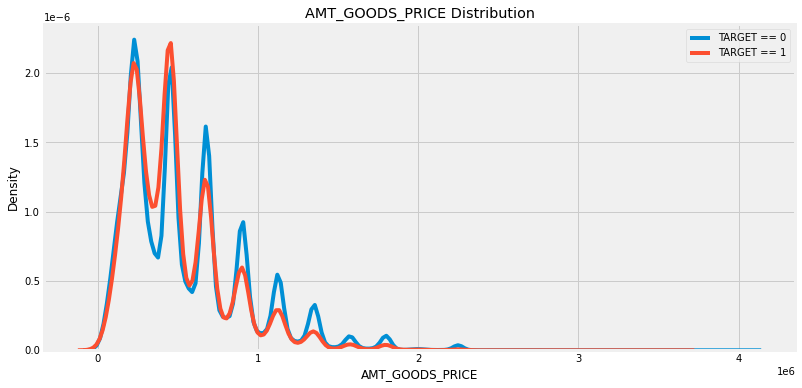

In [1019]:
## 特徴量の分布
kde_target('AMT_GOODS_PRICE', app_train)

In [1020]:
## Yao-Johnson変換
#num_cols = ['AMT_GOODS_PRICE']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['AMT_GOODS_PRICE'] = pt.transform(app_train[num_cols])
#app_test['AMT_GOODS_PRICE'] = pt.transform(app_test[num_cols])

In [1021]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'AMT_GOODS_PRICE']].corr()

In [1022]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('AMT_GOODS_PRICE', app_train)

In [1023]:
## 標準化
num_cols = ['AMT_GOODS_PRICE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['AMT_GOODS_PRICE', 'TARGET']].corr()

AMT_GOODS_PRICE    TARGET
AMT_GOODS_PRICE         1.000000 -0.039565
TARGET                 -0.039565  1.000000

### NAME_TYPE_SUITE(ローン申請したときにクライアントに同行していた人)

In [1024]:
### Originから切り戻し
app_train['NAME_TYPE_SUITE'] = app_train_origin['NAME_TYPE_SUITE'].copy()
app_test['NAME_TYPE_SUITE'] = app_test_origin['NAME_TYPE_SUITE'].copy()
app_train['NAME_TYPE_SUITE'].isnull().sum()

1292

In [1025]:
app_train['NAME_TYPE_SUITE'].isnull().sum()

1292

In [1026]:
app_train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [1027]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'NAME_TYPE_SUITE')

In [1028]:
app_train['NAME_TYPE_SUITE'].isnull().sum()

0

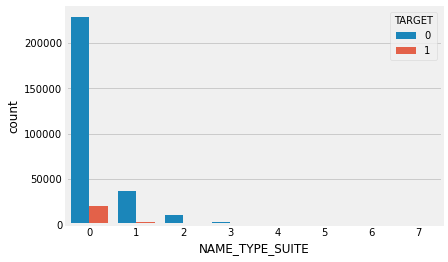

In [1029]:
### ヒストグラム(TARGET比較)
%matplotlib inline
sns.countplot(x='NAME_TYPE_SUITE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [1030]:
app_train[['NAME_TYPE_SUITE', 'TARGET']].corr()

NAME_TYPE_SUITE    TARGET
NAME_TYPE_SUITE         1.000000 -0.004329
TARGET                 -0.004329  1.000000

In [1031]:
#app_train.drop(['NAME_TYPE_SUITE'], axis=1, inplace=True)
#app_test.drop(['NAME_TYPE_SUITE'], axis=1, inplace=True)

### ローン支払額

In [1032]:
### Originから切り戻し
app_train['AMT_ANNUITY'] = app_train_origin['AMT_ANNUITY'].copy()
app_test['AMT_ANNUITY'] = app_test_origin['AMT_ANNUITY'].copy()
app_train['AMT_ANNUITY'].isnull().sum()

12

In [1033]:
app_train['AMT_ANNUITY'].value_counts()

9000.0      6385
13500.0     5514
6750.0      2279
10125.0     2035
37800.0     1602
            ... 
79902.0        1
106969.5       1
60885.0        1
59661.0        1
77809.5        1
Name: AMT_ANNUITY, Length: 13672, dtype: int64

In [1034]:
## 目的変数との相関
app_train[['TARGET', 'AMT_ANNUITY']].corr()

TARGET  AMT_ANNUITY
TARGET       1.000000    -0.012817
AMT_ANNUITY -0.012817     1.000000

In [1035]:
### -999埋めで欠損値補完
app_train['AMT_ANNUITY'] = app_train['AMT_ANNUITY'].fillna(-999)
app_test['AMT_ANNUITY'] = app_test['AMT_ANNUITY'].fillna(-999)
app_train['AMT_ANNUITY'].isnull().sum()

0

In [1036]:
## 目的変数との相関
app_train[['TARGET', 'AMT_ANNUITY']].corr()

TARGET  AMT_ANNUITY
TARGET       1.000000    -0.012793
AMT_ANNUITY -0.012793     1.000000

The correlation between AMT_ANNUITY and the TARGET is -0.0128
Median value for loan that was not repaid = 25263.0000
Median value for loan that was repaid =     24876.0000


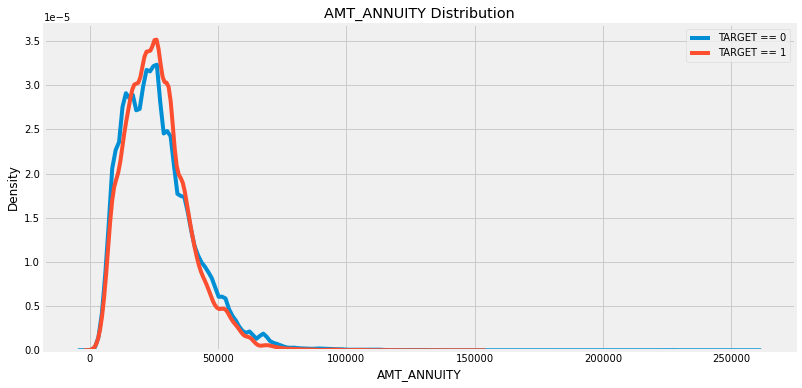

In [1037]:
## 特徴量の分布
kde_target('AMT_ANNUITY', app_train)

In [1038]:
## Yao-Johnson変換
num_cols = ['AMT_ANNUITY']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['AMT_ANNUITY'] = pt.transform(app_train[num_cols])
app_test['AMT_ANNUITY'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'AMT_ANNUITY']].corr()

TARGET  AMT_ANNUITY
TARGET       1.000000    -0.008144
AMT_ANNUITY -0.008144     1.000000

In [1039]:
## 標準化
num_cols = ['AMT_ANNUITY']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['AMT_ANNUITY', 'TARGET']].corr()

AMT_ANNUITY    TARGET
AMT_ANNUITY     1.000000 -0.008144
TARGET         -0.008144  1.000000

### credit_annuity_ratio (AMT_CREDIT / AMT_ANNUITY)

In [1040]:
#### credit_annuity_ratioを導出

In [1041]:
app_train['credit_annuity_ratio'] = app_train['AMT_CREDIT']/app_train['AMT_ANNUITY']
app_test['credit_annuity_ratio'] = app_train['AMT_CREDIT']/app_test['AMT_ANNUITY']
app_train[['TARGET', 'credit_annuity_ratio']].corr()

TARGET  credit_annuity_ratio
TARGET                1.000000             -0.003064
credit_annuity_ratio -0.003064              1.000000

In [1042]:
app_train['credit_annuity_ratio'].isnull().sum()

0

The correlation between credit_annuity_ratio and the TARGET is -0.0031
Median value for loan that was not repaid = 0.8233
Median value for loan that was repaid =     0.8252


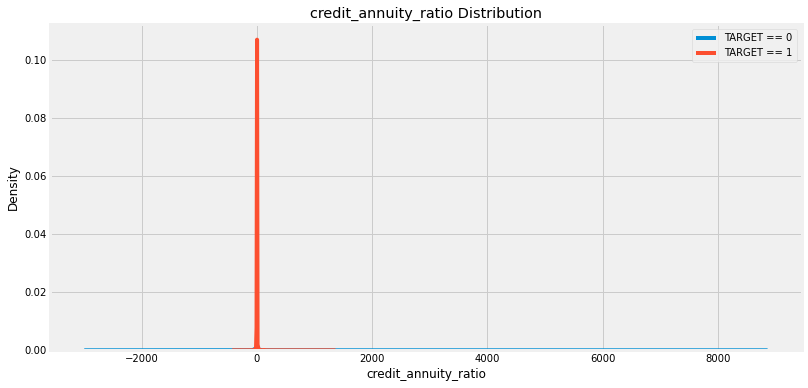

In [1043]:
### 目的変数との関係を可視化
kde_target('credit_annuity_ratio', app_train)

### 家族の人数

In [1044]:
app_train['CNT_FAM_MEMBERS'].isnull().sum()

0

In [1045]:
app_train['CNT_FAM_MEMBERS'].value_counts()

2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
0.0          2
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [1046]:
app_train['CNT_FAM_MEMBERS'].fillna(app_train['CNT_FAM_MEMBERS'].median(), inplace=True)
app_test['CNT_FAM_MEMBERS'].fillna(app_train['CNT_FAM_MEMBERS'].median(), inplace=True)

In [1047]:
app_train[['TARGET', 'CNT_FAM_MEMBERS']].corr()

TARGET  CNT_FAM_MEMBERS
TARGET           1.000000         0.009312
CNT_FAM_MEMBERS  0.009312         1.000000

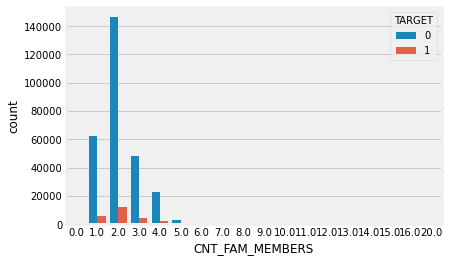

In [1048]:
%matplotlib inline
sns.countplot(x='CNT_FAM_MEMBERS', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [1049]:
#app_train.drop(['CNT_FAM_MEMBERS'], axis=1, inplace=True)
#app_test.drop(['CNT_FAM_MEMBERS'], axis=1, inplace=True)

### 居住地域の人口

In [1050]:
app_train['REGION_POPULATION_RELATIVE'].isnull().sum()

0

In [1051]:
app_train['REGION_POPULATION_RELATIVE'].value_counts()

0.035792    16408
0.046220    13442
0.030755    12163
0.025164    11950
0.026392    11601
            ...  
0.001417      467
0.001333      235
0.000533       39
0.000938       28
0.000290        2
Name: REGION_POPULATION_RELATIVE, Length: 81, dtype: int64

In [1052]:
app_train[['TARGET', 'REGION_POPULATION_RELATIVE']].corr()

TARGET  REGION_POPULATION_RELATIVE
TARGET                      1.000000                   -0.037227
REGION_POPULATION_RELATIVE -0.037227                    1.000000

The correlation between REGION_POPULATION_RELATIVE and the TARGET is -0.0372
Median value for loan that was not repaid = 0.0186
Median value for loan that was repaid =     0.0188


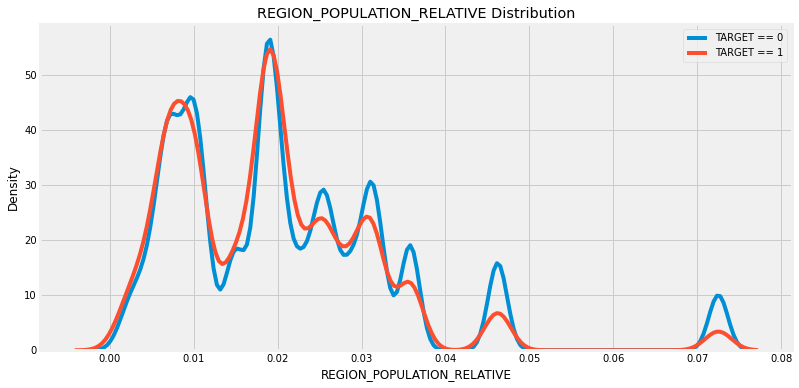

In [1053]:
kde_target('REGION_POPULATION_RELATIVE', app_train)

In [1054]:
#app_train['REGION_POPULATION_RELATIVE'] = pd.cut(app_train['REGION_POPULATION_RELATIVE'], bins=20, labels=False)
#app_test['REGION_POPULATION_RELATIVE'] =  pd.cut(app_test['REGION_POPULATION_RELATIVE'], bins=20, labels=False)

In [1055]:
## Yao-Johnson変換
#num_cols = ['REGION_POPULATION_RELATIVE']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['REGION_POPULATION_RELATIVE'] = pt.transform(app_train[num_cols])
#app_test['REGION_POPULATION_RELATIVE'] = pt.transform(app_test[num_cols])

#app_train[['REGION_POPULATION_RELATIVE', 'TARGET']].corr()

In [1056]:
## 標準化
num_cols = ['REGION_POPULATION_RELATIVE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['REGION_POPULATION_RELATIVE', 'TARGET']].corr()

REGION_POPULATION_RELATIVE    TARGET
REGION_POPULATION_RELATIVE                    1.000000 -0.037227
TARGET                                       -0.037227  1.000000

### DAYS_BIRTH

In [1057]:
app_train['DAYS_BIRTH'].isnull().sum()

0

In [1058]:
app_train[['DAYS_BIRTH', 'TARGET']].corr()

DAYS_BIRTH    TARGET
DAYS_BIRTH    1.000000 -0.078239
TARGET       -0.078239  1.000000

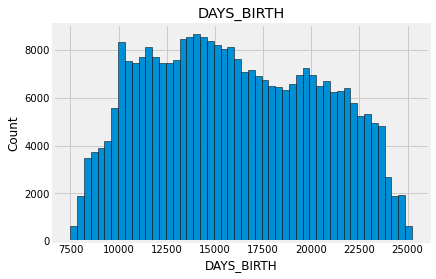

In [1059]:
### ヒストグラム(変数の分布)
plt.hist(app_train['DAYS_BIRTH'], edgecolor = 'k', bins = 50)
plt.title('DAYS_BIRTH'); plt.xlabel('DAYS_BIRTH'); plt.ylabel('Count');

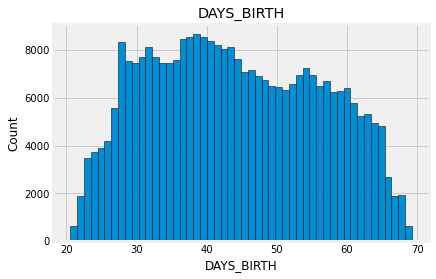

In [1060]:
### ヒストグラム(変数の分布)
### 年齢
plt.hist(abs(app_train['DAYS_BIRTH'])/364.25 , edgecolor = 'k', bins = 50)
plt.title('DAYS_BIRTH'); plt.xlabel('DAYS_BIRTH'); plt.ylabel('Count');

In [1061]:
# 申し込んだ人の年齢を変数化
app_train['USER_AGE'] = abs(app_train['DAYS_BIRTH'])/364.25
app_test['USER_AGE'] = abs(app_test['DAYS_BIRTH'])/364.25
app_train[['USER_AGE', 'TARGET']].corr()

USER_AGE    TARGET
USER_AGE  1.000000 -0.078239
TARGET   -0.078239  1.000000

The correlation between DAYS_BIRTH and the TARGET is -0.0782
Median value for loan that was not repaid = 14282.0000
Median value for loan that was repaid =     15877.0000


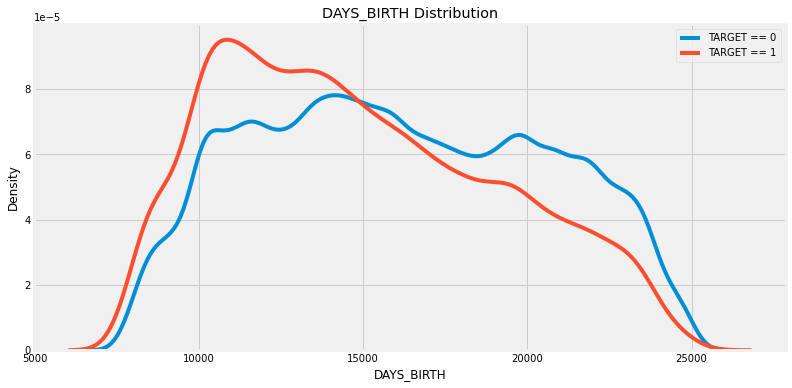

In [1062]:
kde_target('DAYS_BIRTH', app_train)

The correlation between USER_AGE and the TARGET is -0.0782
Median value for loan that was not repaid = 39.2093
Median value for loan that was repaid =     43.5882


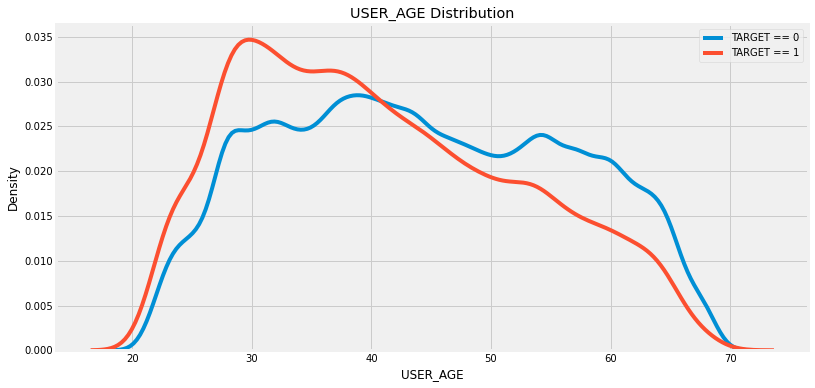

In [1063]:
kde_target('USER_AGE', app_train)

In [1064]:
## 標準化
num_cols = ['DAYS_BIRTH']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['DAYS_BIRTH', 'TARGET']].corr()

DAYS_BIRTH    TARGET
DAYS_BIRTH    1.000000 -0.078239
TARGET       -0.078239  1.000000

In [1065]:
## 標準化
num_cols = ['USER_AGE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['DAYS_BIRTH', 'TARGET']].corr()

DAYS_BIRTH    TARGET
DAYS_BIRTH    1.000000 -0.078239
TARGET       -0.078239  1.000000

### DAYS_EMPLOYED

In [1066]:
app_train['DAYS_EMPLOYED'].isnull().sum()

0

In [1067]:
app_train['DAYS_EMPLOYED'].value_counts()

 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

In [1068]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

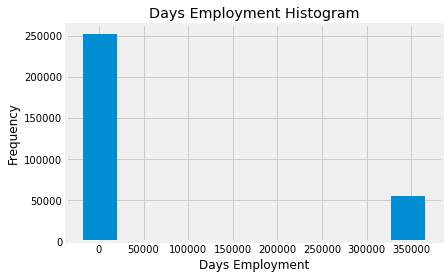

In [1069]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [1070]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


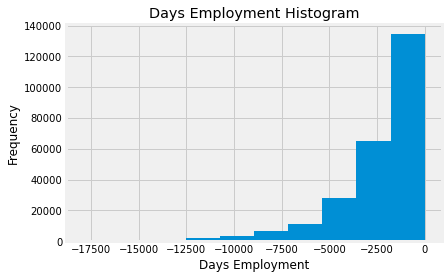

In [1071]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [1072]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


The correlation between DAYS_EMPLOYED and the TARGET is 0.0750
Median value for loan that was not repaid = -1230.0000
Median value for loan that was repaid =     -1691.0000


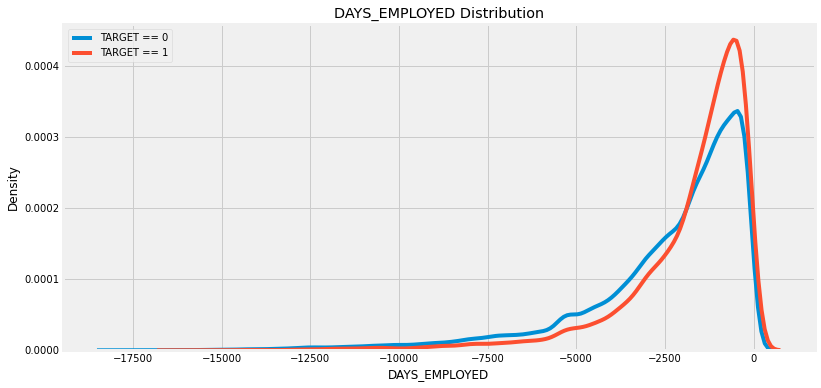

In [1073]:
kde_target('DAYS_EMPLOYED', app_train)

In [1074]:
app_train[['TARGET', 'DAYS_EMPLOYED']].corr()

TARGET  DAYS_EMPLOYED
TARGET         1.000000       0.074958
DAYS_EMPLOYED  0.074958       1.000000

### DAYS_REGISTRATION

In [1075]:
### Originから切り戻し
app_train['DAYS_REGISTRATION'] = app_train_origin['DAYS_REGISTRATION'].copy()
app_test['DAYS_REGISTRATION'] = app_test_origin['DAYS_REGISTRATION'].copy()
app_train['DAYS_REGISTRATION'].isnull().sum()

0

In [1076]:
app_train['DAYS_REGISTRATION'].value_counts()

-1.0        113
-7.0         98
-6.0         96
-4.0         92
-2.0         92
           ... 
-15581.0      1
-15031.0      1
-14804.0      1
-15008.0      1
-14798.0      1
Name: DAYS_REGISTRATION, Length: 15688, dtype: int64

In [1077]:
app_train[['TARGET', 'DAYS_REGISTRATION']].corr()

TARGET  DAYS_REGISTRATION
TARGET             1.000000           0.041975
DAYS_REGISTRATION  0.041975           1.000000

In [1078]:
## Yao-Johnson変換
#num_cols = ['DAYS_REGISTRATION']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['DAYS_REGISTRATION'] = pt.transform(app_train[num_cols])
#app_test['DAYS_REGISTRATION'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'DAYS_REGISTRATION']].corr()

In [1079]:
## 標準化
num_cols = ['DAYS_REGISTRATION']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['DAYS_REGISTRATION', 'TARGET']].corr()

DAYS_REGISTRATION    TARGET
DAYS_REGISTRATION           1.000000  0.041975
TARGET                      0.041975  1.000000

The correlation between DAYS_REGISTRATION and the TARGET is 0.0420
Median value for loan that was not repaid = 0.2640
Median value for loan that was repaid =     0.1255


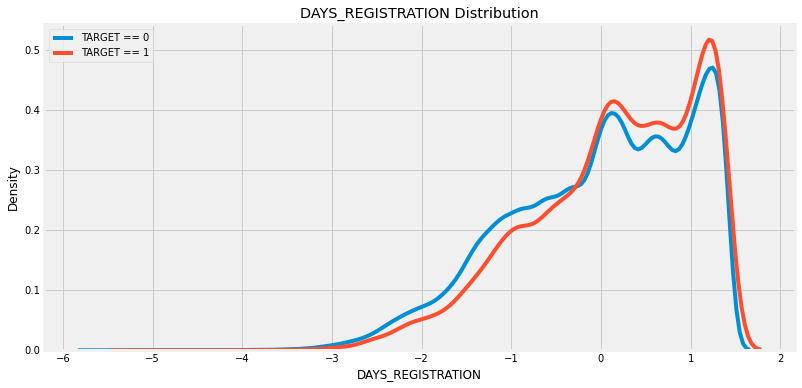

In [1080]:
## Yao-Johnson変換後の特徴量の分布
kde_target('DAYS_REGISTRATION', app_train)

### DAYS_ID_PUBLISH

In [1081]:
### Originから切り戻し
app_train['DAYS_ID_PUBLISH'] = app_train_origin['DAYS_ID_PUBLISH'].copy()
app_test['DAYS_ID_PUBLISH'] = app_test_origin['DAYS_ID_PUBLISH'].copy()
app_train['DAYS_ID_PUBLISH'].isnull().sum()

0

In [1082]:
app_train['DAYS_ID_PUBLISH'].value_counts()

-4053    169
-4095    162
-4046    161
-4417    159
-4256    158
        ... 
-5896      1
-5921      1
-5753      1
-5960      1
-6211      1
Name: DAYS_ID_PUBLISH, Length: 6168, dtype: int64

In [1083]:
app_train[['TARGET', 'DAYS_ID_PUBLISH']].corr()

TARGET  DAYS_ID_PUBLISH
TARGET           1.000000         0.051457
DAYS_ID_PUBLISH  0.051457         1.000000

In [1084]:
## Yao-Johnson変換
#num_cols = ['DAYS_ID_PUBLISH']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['DAYS_ID_PUBLISH'] = pt.transform(app_train[num_cols])
#app_test['DAYS_ID_PUBLISH'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'DAYS_ID_PUBLISH']].corr()

In [1085]:
## 標準化
num_cols = ['DAYS_ID_PUBLISH']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['DAYS_ID_PUBLISH', 'TARGET']].corr()

DAYS_ID_PUBLISH    TARGET
DAYS_ID_PUBLISH         1.000000  0.051457
TARGET                  0.051457  1.000000

The correlation between DAYS_ID_PUBLISH and the TARGET is 0.0515
Median value for loan that was not repaid = 0.1306
Median value for loan that was repaid =     -0.1993


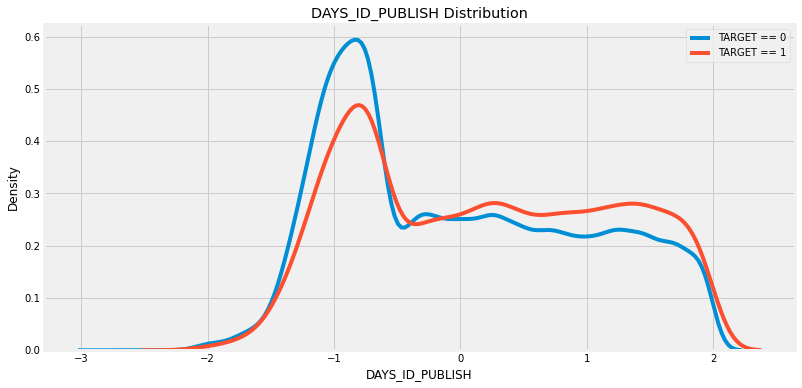

In [1086]:
## Yao-Johnson変換後の特徴量の分布
kde_target('DAYS_ID_PUBLISH', app_train)

### unique_key_1

In [42]:
app_train['unique_key_1'] = app_train["DAYS_REGISTRATION"] - app_train["DAYS_BIRTH"]
app_test['unique_key_1'] = app_test["DAYS_REGISTRATION"] - app_test["DAYS_BIRTH"]
app_train['unique_key_1'].isnull().sum()

0

In [43]:
app_train['unique_key_1'].value_counts()

0.0        905
31.0       186
30.0       142
5896.0     128
5873.0     124
          ... 
3830.0       1
1435.0       1
22149.0      1
3606.0       1
22494.0      1
Name: unique_key_1, Length: 22799, dtype: int64

The correlation between unique_key_1 and the TARGET is -0.0420
Median value for loan that was not repaid = 10000.0000
Median value for loan that was repaid =     10751.0000


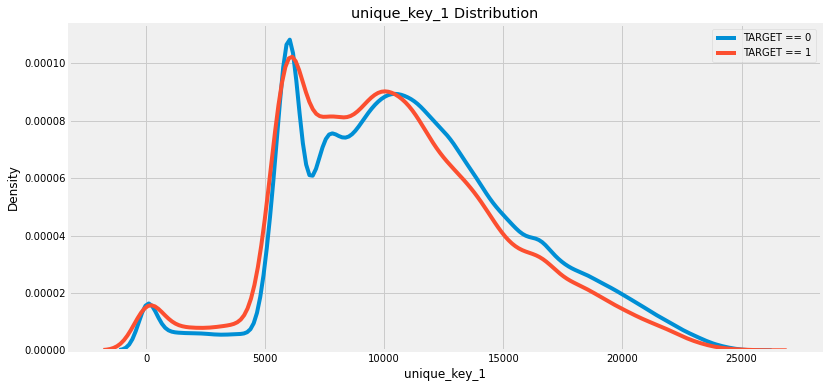

In [44]:
### 目的変数との関係を可視化
kde_target('unique_key_1', app_train)

In [45]:
app_train[['TARGET', 'unique_key_1']].corr()

TARGET  unique_key_1
TARGET        1.00000      -0.04199
unique_key_1 -0.04199       1.00000

### unique_key_2

In [46]:
app_train['unique_key_2'] = app_train["DAYS_ID_PUBLISH"] - app_train["DAYS_BIRTH"]
app_test['unique_key_2'] = app_test["DAYS_ID_PUBLISH"] - app_test["DAYS_BIRTH"]
app_test['unique_key_2'].isnull().sum()

0

In [47]:
app_train['unique_key_2'].value_counts()

16454    1636
16449    1626
16452    1576
16448    1571
16453    1563
         ... 
15714       1
21199       1
15877       1
23016       1
22468       1
Name: unique_key_2, Length: 14314, dtype: int64

The correlation between unique_key_2 and the TARGET is -0.0626
Median value for loan that was not repaid = 10904.0000
Median value for loan that was repaid =     12390.0000


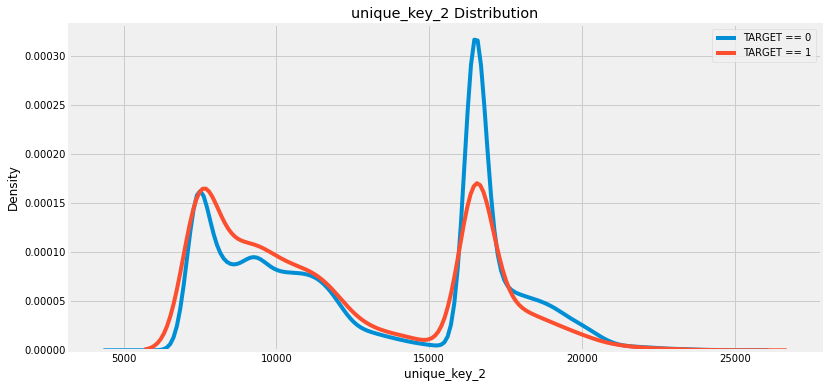

In [48]:
### 目的変数との関係を可視化
kde_target('unique_key_2', app_train)

In [50]:
app_train[['TARGET', 'unique_key_2']].corr()

TARGET  unique_key_2
TARGET        1.000000     -0.062641
unique_key_2 -0.062641      1.000000

### gender_key

In [51]:
app_train['gender_key'] = app_train_origin['CODE_GENDER'].copy()
app_test['gender_key'] = app_test_origin['CODE_GENDER'].copy()
app_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0  ...                0                        0.0                       0.0   
1  ...                0                        0.0                       0.0   
2  ...                0                        0.0                       0.0   
3  ...                0                        0.0                       0.0   
4  ...                0                        NaN                       NaN   

  AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        NaN                       NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  unique_key_1  \
0                        0.0                         0.0       14071.0   
1                        0.0                         3.0        8946.0   
2                        1.0                         4.0       17863.0   
3                        0.0                         3.0       11976.0   
4                        NaN                         NaN        9040.0   

   unique_key_2  gender_key  
0         18429           F  
1         16441           M  
2         16535           M  
3          9768           F  
4          8778           M  

[5 rows x 124 columns]

In [52]:
app_train['gender_key'].replace(['M', 'F', 'XNA'], [0, 1, 2], inplace=True)
app_test['gender_key'].replace(['M', 'F', 'XNA'], [0, 1, 2], inplace=True)
app_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0  ...                0                        0.0                       0.0   
1  ...                0                        0.0                       0.0   
2  ...                0                        0.0                       0.0   
3  ...                0                        0.0                       0.0   
4  ...                0                        NaN                       NaN   

  AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        NaN                       NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  unique_key_1  \
0                        0.0                         0.0       14071.0   
1                        0.0                         3.0        8946.0   
2                        1.0                         4.0       17863.0   
3                        0.0                         3.0       11976.0   
4                        NaN                         NaN        9040.0   

   unique_key_2  gender_key  
0         18429           1  
1         16441           0  
2         16535           0  
3          9768           1  
4          8778           0  

[5 rows x 124 columns]

### OWN_CAR_AGE

In [1087]:
### Originから切り戻し
app_train['OWN_CAR_AGE'] = app_train_origin['OWN_CAR_AGE'].copy()
app_test['OWN_CAR_AGE'] = app_test_origin['OWN_CAR_AGE'].copy()
app_train['OWN_CAR_AGE'].isnull().sum()

202929

In [1088]:
app_train['OWN_CAR_AGE'].value_counts()

7.0     7424
6.0     6382
3.0     6370
8.0     5887
2.0     5852
        ... 
69.0       1
50.0       1
47.0       1
48.0       1
52.0       1
Name: OWN_CAR_AGE, Length: 62, dtype: int64

In [1089]:
app_train[['TARGET', 'OWN_CAR_AGE']].corr()

TARGET  OWN_CAR_AGE
TARGET       1.000000     0.037612
OWN_CAR_AGE  0.037612     1.000000

In [1090]:
### 中央値で欠損値補完
app_train['OWN_CAR_AGE'].fillna(app_train['OWN_CAR_AGE'].median(), inplace=True)
app_test['OWN_CAR_AGE'].fillna(app_train['OWN_CAR_AGE'].median(), inplace=True)
app_train['OWN_CAR_AGE'].isnull().sum()

0

In [1091]:
app_train[['TARGET', 'OWN_CAR_AGE']].corr()

TARGET  OWN_CAR_AGE
TARGET       1.000000     0.015982
OWN_CAR_AGE  0.015982     1.000000

In [1092]:
## Yao-Johnson変換
num_cols = ['OWN_CAR_AGE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['OWN_CAR_AGE'] = pt.transform(app_train[num_cols])
app_test['OWN_CAR_AGE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'OWN_CAR_AGE']].corr()

TARGET  OWN_CAR_AGE
TARGET       1.000000     0.025402
OWN_CAR_AGE  0.025402     1.000000

In [1093]:
## 標準化
num_cols = ['OWN_CAR_AGE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['OWN_CAR_AGE', 'TARGET']].corr()

OWN_CAR_AGE    TARGET
OWN_CAR_AGE     1.000000  0.025402
TARGET          0.025402  1.000000

The correlation between OWN_CAR_AGE and the TARGET is 0.0254
Median value for loan that was not repaid = 0.0051
Median value for loan that was repaid =     0.0051


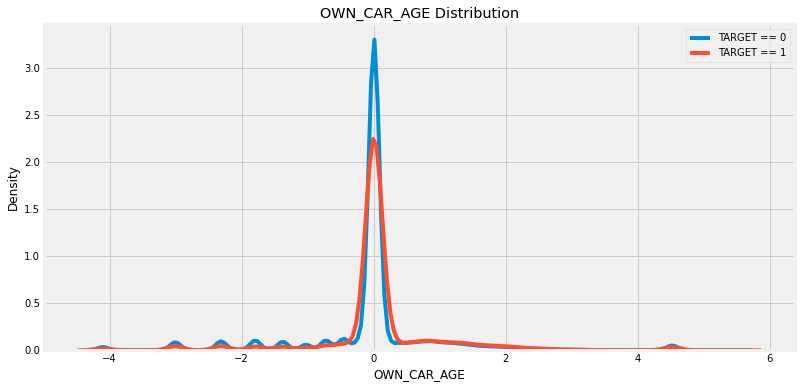

In [1094]:
## Yao-Johnson変換後の特徴量の分布
kde_target('OWN_CAR_AGE', app_train)

### LIVINGAPARTMENTS_MODE

In [1095]:
### Originから切り戻し
app_train['LIVINGAPARTMENTS_MODE'] = app_train_origin['LIVINGAPARTMENTS_MODE'].copy()
app_test['LIVINGAPARTMENTS_MODE'] = app_test_origin['LIVINGAPARTMENTS_MODE'].copy()
app_train['LIVINGAPARTMENTS_MODE'].isnull().sum()

210199

In [1096]:
app_train['LIVINGAPARTMENTS_MODE'].value_counts()

0.0551    4931
0.0735    4797
0.0826    2966
0.0643    2853
0.0918    2069
          ... 
0.7062       1
0.6042       1
0.5638       1
0.6795       1
0.6538       1
Name: LIVINGAPARTMENTS_MODE, Length: 736, dtype: int64

In [1097]:
app_train[['TARGET', 'LIVINGAPARTMENTS_MODE']].corr()

TARGET  LIVINGAPARTMENTS_MODE
TARGET                 1.000000              -0.023393
LIVINGAPARTMENTS_MODE -0.023393               1.000000

In [1098]:
### 0埋めで欠損値補完
app_train['LIVINGAPARTMENTS_MODE'] = app_train['LIVINGAPARTMENTS_MODE'].fillna(0)
app_test['LIVINGAPARTMENTS_MODE'] = app_test['LIVINGAPARTMENTS_MODE'].fillna(0)
app_train['LIVINGAPARTMENTS_MODE'].isnull().sum()

0

In [1099]:
app_train[['TARGET', 'LIVINGAPARTMENTS_MODE']].corr()

TARGET  LIVINGAPARTMENTS_MODE
TARGET                 1.000000              -0.028829
LIVINGAPARTMENTS_MODE -0.028829               1.000000

In [1100]:
## Yao-Johnson変換
num_cols = ['LIVINGAPARTMENTS_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAPARTMENTS_MODE'] = pt.transform(app_train[num_cols])
app_test['LIVINGAPARTMENTS_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAPARTMENTS_MODE']].corr()

TARGET  LIVINGAPARTMENTS_MODE
TARGET                 1.000000              -0.033311
LIVINGAPARTMENTS_MODE -0.033311               1.000000

In [1101]:
## 標準化
num_cols = ['LIVINGAPARTMENTS_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['LIVINGAPARTMENTS_MODE', 'TARGET']].corr()

LIVINGAPARTMENTS_MODE    TARGET
LIVINGAPARTMENTS_MODE               1.000000 -0.033311
TARGET                             -0.033311  1.000000

The correlation between LIVINGAPARTMENTS_MODE and the TARGET is -0.0333
Median value for loan that was not repaid = -0.6394
Median value for loan that was repaid =     -0.6394


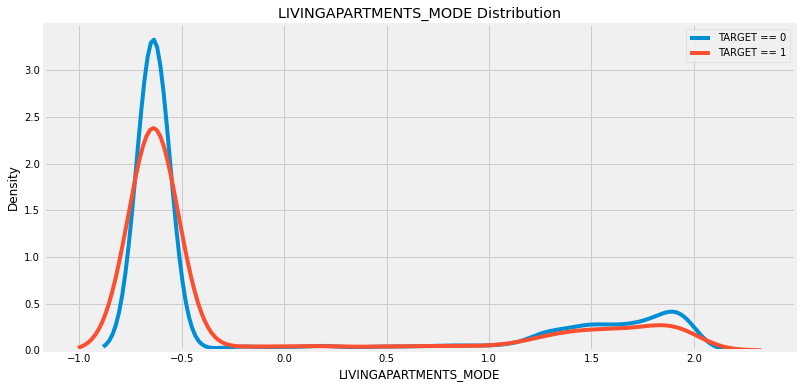

In [1102]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAPARTMENTS_MODE', app_train)

### REGION_RATING_CLIENT

In [1103]:
app_train['REGION_RATING_CLIENT'].isnull().sum()

0

In [1104]:
app_train['REGION_RATING_CLIENT'].value_counts()

2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64

In [1105]:
app_train[['TARGET', 'REGION_RATING_CLIENT']].corr()

TARGET  REGION_RATING_CLIENT
TARGET                1.000000              0.058899
REGION_RATING_CLIENT  0.058899              1.000000

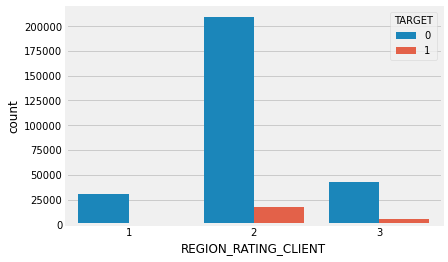

In [1106]:
%matplotlib inline
sns.countplot(x='REGION_RATING_CLIENT', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 居住地域の正規化された人口

In [1107]:
app_train['REGION_RATING_CLIENT'].isnull().sum()

0

In [1108]:
app_train[['REGION_RATING_CLIENT','TARGET']].corr()

REGION_RATING_CLIENT    TARGET
REGION_RATING_CLIENT              1.000000  0.058899
TARGET                            0.058899  1.000000

The correlation between REGION_RATING_CLIENT and the TARGET is 0.0589
Median value for loan that was not repaid = 2.0000
Median value for loan that was repaid =     2.0000


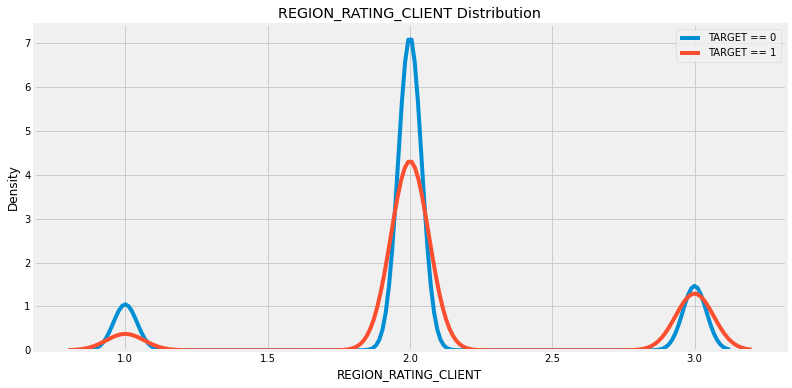

In [1109]:
### 目的変数との関係を可視化
kde_target('REGION_RATING_CLIENT', app_train)

### WEEKDAY_APPR_PROCESS_START

In [1110]:
app_train['WEEKDAY_APPR_PROCESS_START'].isnull().sum()

0

In [1111]:
app_train['WEEKDAY_APPR_PROCESS_START'].value_counts()

TUESDAY      53901
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50591
FRIDAY       50338
SATURDAY     33852
SUNDAY       16181
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

In [1112]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'WEEKDAY_APPR_PROCESS_START')

In [1113]:
app_train[['WEEKDAY_APPR_PROCESS_START', 'TARGET']].corr()

WEEKDAY_APPR_PROCESS_START    TARGET
WEEKDAY_APPR_PROCESS_START                    1.000000  0.003478
TARGET                                        0.003478  1.000000

In [1114]:
#columns = ['WEEKDAY_APPR_PROCESS_START']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### 居住地域のレーティング(市を考慮)

In [1115]:
app_train['REGION_RATING_CLIENT_W_CITY'].isnull().sum()

0

In [1116]:
app_train['REGION_RATING_CLIENT_W_CITY'].value_counts()

2    229484
3     43860
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

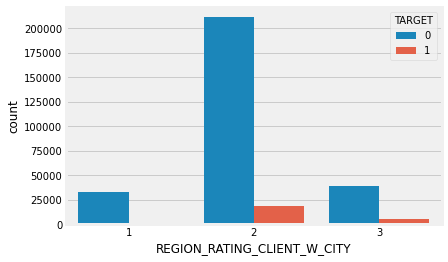

In [1117]:
%matplotlib inline
sns.countplot(x='REGION_RATING_CLIENT_W_CITY', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [1118]:
app_train[['REGION_RATING_CLIENT_W_CITY', 'TARGET']].corr()

REGION_RATING_CLIENT_W_CITY    TARGET
REGION_RATING_CLIENT_W_CITY                     1.000000  0.060893
TARGET                                          0.060893  1.000000

### credit_goods_price_ratio

In [1119]:
app_train['credit_goods_price_ratio'] = app_train['AMT_CREDIT']/app_train['AMT_GOODS_PRICE']
app_test['credit_goods_price_ratio'] = app_test['AMT_CREDIT']/app_test['AMT_GOODS_PRICE']

In [1120]:
app_train['credit_goods_price_ratio'].isnull().sum()

0

In [1121]:
app_train['credit_goods_price_ratio'].value_counts()

1.556833    9686
0.508948    8862
1.097738    8094
1.075186    7245
1.127867    7153
            ... 
0.905710       1
0.996180       1
0.997905       1
0.888397       1
0.948312       1
Name: credit_goods_price_ratio, Length: 5812, dtype: int64

In [1122]:
app_train[['credit_goods_price_ratio', 'TARGET']].corr()

credit_goods_price_ratio    TARGET
credit_goods_price_ratio                  1.000000  0.002224
TARGET                                    0.002224  1.000000

The correlation between credit_goods_price_ratio and the TARGET is 0.0022
Median value for loan that was not repaid = 1.0106
Median value for loan that was repaid =     1.0274


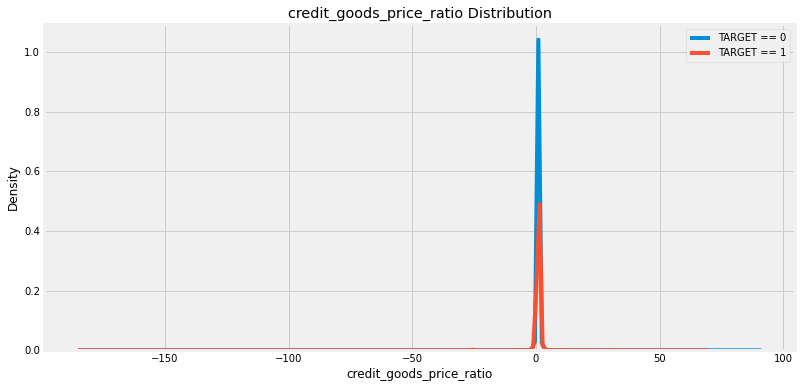

In [1123]:
### 目的変数との関係を可視化
kde_target('credit_goods_price_ratio', app_train)

### credit_downpayment 

In [1124]:
app_train['credit_downpayment'] = app_train['AMT_GOODS_PRICE'] - app_train['AMT_CREDIT']
app_test['credit_downpayment'] = app_test['AMT_GOODS_PRICE'] - app_test['AMT_CREDIT']

In [1125]:
app_train['credit_downpayment'].isnull().sum()

0

In [1126]:
app_train['credit_downpayment'].value_counts()

0.132431    9686
0.182123    8862
0.082739    8094
0.072801    7245
0.092678    7153
            ... 
0.115324       1
0.010021       1
0.006720       1
0.258781       1
0.107267       1
Name: credit_downpayment, Length: 5812, dtype: int64

In [1127]:
app_train[['credit_downpayment', 'TARGET']].corr()

credit_downpayment    TARGET
credit_downpayment            1.000000 -0.056358
TARGET                       -0.056358  1.000000

The correlation between credit_downpayment and the TARGET is -0.0564
Median value for loan that was not repaid = -0.0231
Median value for loan that was repaid =     0.0125


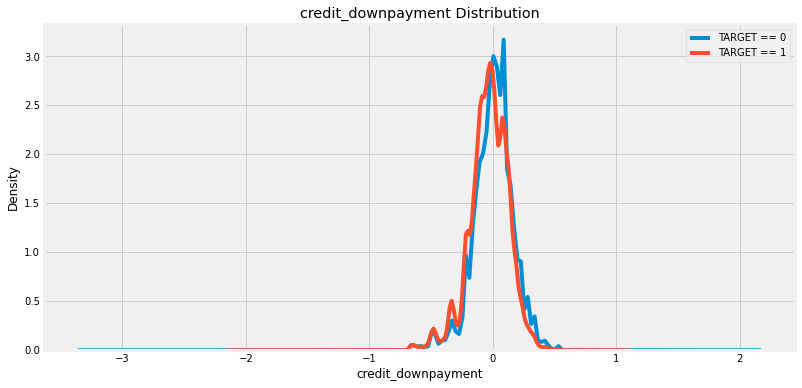

In [1128]:
### 目的変数との関係を可視化
kde_target('credit_downpayment', app_train)

In [1129]:
## 標準化
num_cols = ['credit_downpayment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['credit_downpayment', 'TARGET']].corr()

credit_downpayment    TARGET
credit_downpayment            1.000000 -0.056358
TARGET                       -0.056358  1.000000

### EXT_SOURCE_1

In [1130]:
app_train['EXT_SOURCE_1'].isnull().sum()

173378

In [1131]:
app_train['EXT_SOURCE_1'].value_counts()

0.622707    5
0.443982    5
0.546426    5
0.581015    5
0.499002    5
           ..
0.658473    1
0.318295    1
0.834644    1
0.485406    1
0.734460    1
Name: EXT_SOURCE_1, Length: 114584, dtype: int64

In [1132]:
app_train[['EXT_SOURCE_1', 'TARGET']].corr()

EXT_SOURCE_1    TARGET
EXT_SOURCE_1      1.000000 -0.155317
TARGET           -0.155317  1.000000

In [1133]:
### 欠損値補完
#replace_columns = list(app_test.select_dtypes(include='number').columns)
#replace_columns.remove('SK_ID_CURR')
#result = modules.process_imputer(app_train, app_test, replace_columns, 'EXT_SOURCE_1')
#if result != True:
#    print("Can not Process: \n")

In [1134]:
app_train['EXT_SOURCE_1'].isnull().sum()

173378

In [1135]:
#app_train[['EXT_SOURCE_1', 'TARGET']].corr()

<AxesSubplot:xlabel='EXT_SOURCE_1', ylabel='Count'>

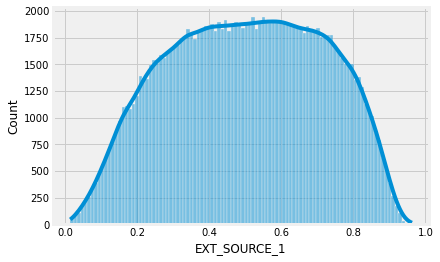

In [1136]:
sns.histplot(
    app_train['EXT_SOURCE_1']
    ,kde = True
    ,bins = 100
)

In [1137]:
min(app_train['EXT_SOURCE_1'])

0.0145681324124455

In [1138]:
max(app_train['EXT_SOURCE_1'])

0.962692770561306

In [1139]:
app_train[['EXT_SOURCE_1', 'TARGET']].corr()

EXT_SOURCE_1    TARGET
EXT_SOURCE_1      1.000000 -0.155317
TARGET           -0.155317  1.000000

The correlation between EXT_SOURCE_1 and the TARGET is -0.1553
Median value for loan that was not repaid = 0.3617
Median value for loan that was repaid =     0.5175


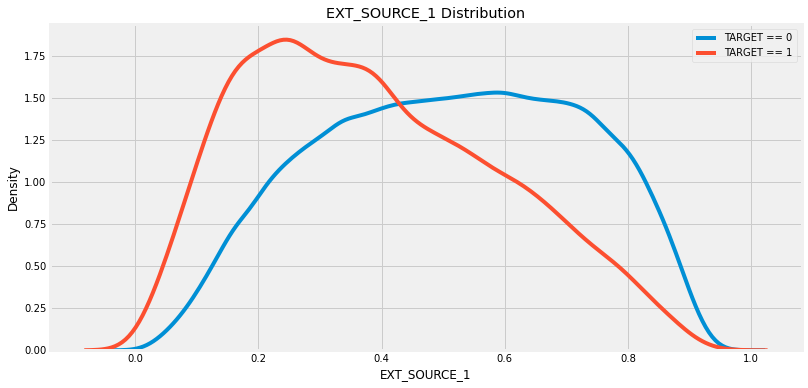

In [1140]:
### 目的変数との関係を可視化
kde_target('EXT_SOURCE_1', app_train)

### EXT_SOURCE_2

In [1141]:
app_train['EXT_SOURCE_2'].isnull().sum()

660

In [1142]:
app_train['EXT_SOURCE_2'].value_counts()

0.285898    721
0.262258    417
0.265256    343
0.159679    322
0.265312    306
           ... 
0.004725      1
0.257313      1
0.282030      1
0.181540      1
0.267834      1
Name: EXT_SOURCE_2, Length: 119831, dtype: int64

In [1143]:
app_train[['TARGET', 'EXT_SOURCE_2']].corr()

TARGET  EXT_SOURCE_2
TARGET        1.000000     -0.160472
EXT_SOURCE_2 -0.160472      1.000000

The correlation between EXT_SOURCE_2 and the TARGET is -0.1605
Median value for loan that was not repaid = 0.4404
Median value for loan that was repaid =     0.5739


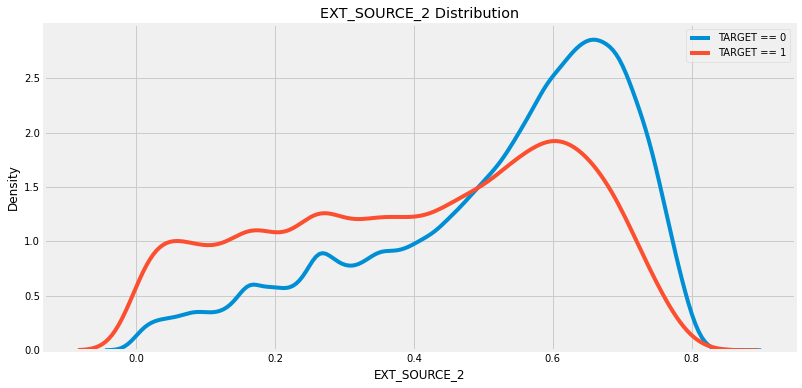

In [1144]:
### 目的変数との関係を可視化
kde_target('EXT_SOURCE_2', app_train)

### EXT_SOURCE_3

In [1145]:
app_train['EXT_SOURCE_3'].isnull().sum()

60965

In [1146]:
app_train['EXT_SOURCE_3'].value_counts()

0.746300    1460
0.713631    1315
0.694093    1276
0.670652    1191
0.652897    1154
            ... 
0.021492       1
0.019468       1
0.023062       1
0.014556       1
0.043227       1
Name: EXT_SOURCE_3, Length: 814, dtype: int64

In [1147]:
app_train[['TARGET', 'EXT_SOURCE_3']].corr()

TARGET  EXT_SOURCE_3
TARGET        1.000000     -0.178919
EXT_SOURCE_3 -0.178919      1.000000

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


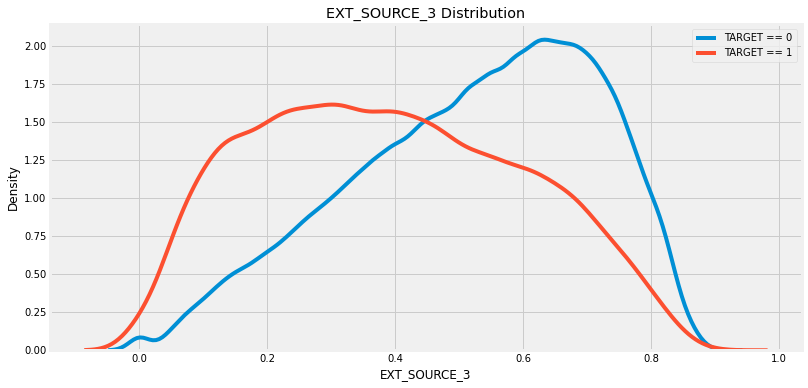

In [1148]:
### 目的変数との関係を可視化
kde_target('EXT_SOURCE_3', app_train)

### ORGANIZATION_TYPE

In [1149]:
app_train['ORGANIZATION_TYPE'].isnull().sum()

0

In [1150]:
app_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

In [1151]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'ORGANIZATION_TYPE')

In [1152]:
app_train[['ORGANIZATION_TYPE', 'TARGET']].corr()

ORGANIZATION_TYPE    TARGET
ORGANIZATION_TYPE           1.000000  0.004532
TARGET                      0.004532  1.000000

### FLAG_MOBIL

In [1153]:
app_train['FLAG_MOBIL'].value_counts()

1    307510
0         1
Name: FLAG_MOBIL, dtype: int64

In [1154]:
app_train[['FLAG_MOBIL', 'TARGET']].corr()

FLAG_MOBIL    TARGET
FLAG_MOBIL    1.000000  0.000534
TARGET        0.000534  1.000000

In [1155]:
#columns = ['FLAG_MOBIL']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### FLAG_EMP_PHONE

In [1156]:
app_train['FLAG_EMP_PHONE'].isnull().sum()

0

In [1157]:
app_train['FLAG_EMP_PHONE'].value_counts()

1    252125
0     55386
Name: FLAG_EMP_PHONE, dtype: int64

In [1158]:
app_train[['FLAG_EMP_PHONE', 'TARGET']].corr()

FLAG_EMP_PHONE    TARGET
FLAG_EMP_PHONE        1.000000  0.045982
TARGET                0.045982  1.000000

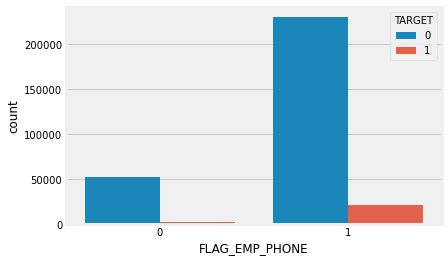

In [1159]:
### ヒストグラム(TARGET比較)
%matplotlib inline
sns.countplot(x='FLAG_EMP_PHONE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### FLAG_WORK_PHONE

In [1160]:
app_train['FLAG_WORK_PHONE'].isnull().sum()

0

In [1161]:
app_train['FLAG_WORK_PHONE'].value_counts()

0    246203
1     61308
Name: FLAG_WORK_PHONE, dtype: int64

In [1162]:
app_train[['FLAG_WORK_PHONE', 'TARGET']].corr()

FLAG_WORK_PHONE    TARGET
FLAG_WORK_PHONE         1.000000  0.028524
TARGET                  0.028524  1.000000

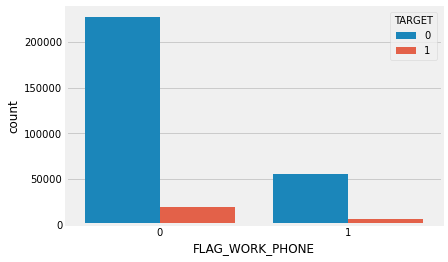

In [1163]:
### ヒストグラム(TARGET比較)
%matplotlib inline
sns.countplot(x='FLAG_WORK_PHONE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### FLAG_CONT_MOBILE

In [1164]:
app_train['FLAG_CONT_MOBILE'].isnull().sum()

0

In [1165]:
app_train['FLAG_CONT_MOBILE'].value_counts()

1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64

In [1166]:
app_train[['FLAG_CONT_MOBILE', 'TARGET']].corr()

FLAG_CONT_MOBILE   TARGET
FLAG_CONT_MOBILE           1.00000  0.00037
TARGET                     0.00037  1.00000

In [1167]:
#columns = ['FLAG_CONT_MOBILE']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### FLAG_PHONE

In [1168]:
app_train['FLAG_PHONE'].isnull().sum()

0

In [1169]:
app_train['FLAG_PHONE'].value_counts()

0    221080
1     86431
Name: FLAG_PHONE, dtype: int64

In [1170]:
app_train[['FLAG_PHONE', 'TARGET']].corr()

FLAG_PHONE    TARGET
FLAG_PHONE    1.000000 -0.023806
TARGET       -0.023806  1.000000

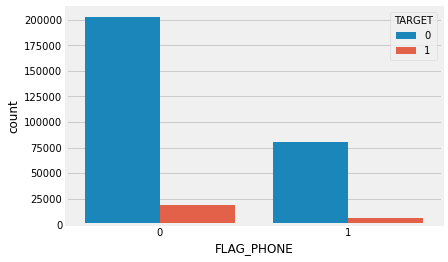

In [1171]:
### ヒストグラム(TARGET比較)
%matplotlib inline
sns.countplot(x='FLAG_PHONE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### FLAG_EMAIL

In [1172]:
app_train['FLAG_EMAIL'].isnull().sum()

0

In [1173]:
app_train['FLAG_EMAIL'].value_counts()

0    290069
1     17442
Name: FLAG_EMAIL, dtype: int64

In [1174]:
app_train[['FLAG_EMAIL', 'TARGET']].corr()

FLAG_EMAIL    TARGET
FLAG_EMAIL    1.000000 -0.001758
TARGET       -0.001758  1.000000

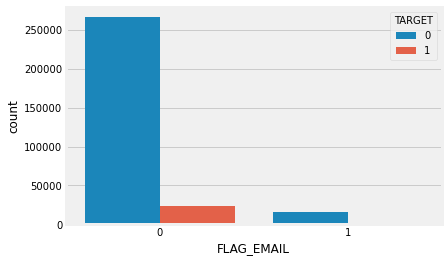

In [1175]:
### ヒストグラム(TARGET比較)
%matplotlib inline
sns.countplot(x='FLAG_EMAIL', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### APARTMENTS_AVG

In [1176]:
### Originから切り戻し
app_train['APARTMENTS_AVG'] = app_train_origin['APARTMENTS_AVG'].copy()
app_test['APARTMENTS_AVG'] = app_test_origin['APARTMENTS_AVG'].copy()
app_train['APARTMENTS_AVG'].isnull().sum()

156061

In [1177]:
app_train['APARTMENTS_AVG'].isnull().sum()

156061

In [1178]:
app_train[['APARTMENTS_AVG', 'TARGET']].value_counts()

APARTMENTS_AVG  TARGET
0.0825          0         6192
0.0619          0         5934
0.0928          0         4100
0.0722          0         3687
0.0082          0         3182
                          ... 
0.2606          0            1
0.0294          1            1
0.0908          1            1
0.2624          1            1
0.0750          0            1
Length: 3272, dtype: int64

In [1179]:
## 目的変数との相関
app_train[['TARGET', 'APARTMENTS_AVG']].corr()

TARGET  APARTMENTS_AVG
TARGET          1.000000       -0.029498
APARTMENTS_AVG -0.029498        1.000000

In [1180]:
### 0埋めで欠損値補完
app_train['APARTMENTS_AVG'] = app_train['APARTMENTS_AVG'].fillna(-999)
app_test['APARTMENTS_AVG'] = app_test['APARTMENTS_AVG'].fillna(-999)
app_train['APARTMENTS_AVG'].isnull().sum()

0

In [1181]:
## 目的変数との相関
app_train[['TARGET', 'APARTMENTS_AVG']].corr()

TARGET  APARTMENTS_AVG
TARGET          1.000000       -0.040269
APARTMENTS_AVG -0.040269        1.000000

The correlation between APARTMENTS_AVG and the TARGET is -0.0403
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


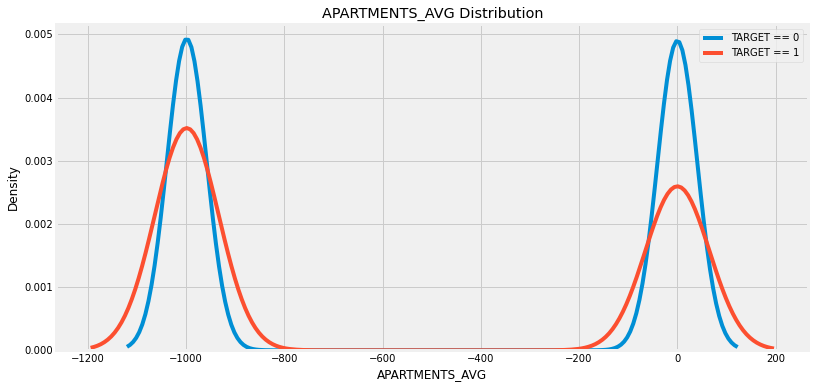

In [1182]:
## 特徴量の分布
kde_target('APARTMENTS_AVG', app_train)

In [1183]:
## Yao-Johnson変換
num_cols = ['APARTMENTS_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['APARTMENTS_AVG'] = pt.transform(app_train[num_cols])
app_test['APARTMENTS_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'APARTMENTS_AVG']].corr()

TARGET  APARTMENTS_AVG
TARGET          1.000000       -0.040716
APARTMENTS_AVG -0.040716        1.000000

In [1184]:
## 標準化
num_cols = ['APARTMENTS_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['APARTMENTS_AVG', 'TARGET']].corr()

APARTMENTS_AVG    TARGET
APARTMENTS_AVG        1.000000 -0.040716
TARGET               -0.040716  1.000000

### BASEMENTAREA_AVG

In [1185]:
### Originから切り戻し
app_train['BASEMENTAREA_AVG'] = app_train_origin['BASEMENTAREA_AVG'].copy()
app_test['BASEMENTAREA_AVG'] = app_test_origin['BASEMENTAREA_AVG'].copy()
app_train['BASEMENTAREA_AVG'].isnull().sum()

179943

In [1186]:
app_train['BASEMENTAREA_AVG'].isnull().sum()

179943

In [1187]:
app_train['BASEMENTAREA_AVG'].value_counts()

0.0000    14745
0.0545      251
0.0818      251
0.0727      248
0.1091      246
          ...  
0.2999        1
0.2737        1
0.4696        1
0.2992        1
0.6360        1
Name: BASEMENTAREA_AVG, Length: 3780, dtype: int64

In [1188]:
## 目的変数との相関
app_train[['TARGET', 'BASEMENTAREA_AVG']].corr()

TARGET  BASEMENTAREA_AVG
TARGET            1.000000         -0.022746
BASEMENTAREA_AVG -0.022746          1.000000

In [1189]:
### 0埋めで欠損値補完
app_train['BASEMENTAREA_AVG'] = app_train['BASEMENTAREA_AVG'].fillna(-999)
app_test['BASEMENTAREA_AVG'] = app_test['BASEMENTAREA_AVG'].fillna(-999)
app_train['BASEMENTAREA_AVG'].isnull().sum()

0

In [1190]:
## 目的変数との相関
app_train[['TARGET', 'BASEMENTAREA_AVG']].corr()

TARGET  BASEMENTAREA_AVG
TARGET            1.000000         -0.036621
BASEMENTAREA_AVG -0.036621          1.000000

The correlation between BASEMENTAREA_AVG and the TARGET is -0.0366
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


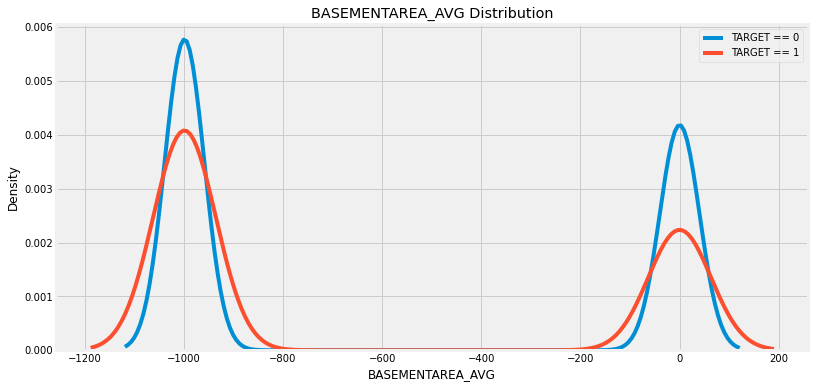

In [1191]:
### 目的変数との関係を可視化
kde_target('BASEMENTAREA_AVG', app_train)

In [1192]:
## Yao-Johnson変換
num_cols = ['BASEMENTAREA_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['BASEMENTAREA_AVG'] = pt.transform(app_train[num_cols])
app_test['BASEMENTAREA_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'BASEMENTAREA_AVG']].corr()

TARGET  BASEMENTAREA_AVG
TARGET            1.000000         -0.036755
BASEMENTAREA_AVG -0.036755          1.000000

In [1193]:
## 標準化
num_cols = ['BASEMENTAREA_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['BASEMENTAREA_AVG', 'TARGET']].corr()

BASEMENTAREA_AVG    TARGET
BASEMENTAREA_AVG          1.000000 -0.036755
TARGET                   -0.036755  1.000000

### YEARS_BEGINEXPLUATATION_AVG

In [1194]:
### Originから切り戻し
app_train['YEARS_BEGINEXPLUATATION_AVG'] = app_train_origin['YEARS_BEGINEXPLUATATION_AVG'].copy()
app_test['YEARS_BEGINEXPLUATATION_AVG'] = app_test_origin['YEARS_BEGINEXPLUATATION_AVG'].copy()
app_train['YEARS_BEGINEXPLUATATION_AVG'].isnull().sum()

150007

In [1195]:
app_train['YEARS_BEGINEXPLUATATION_AVG'].isnull().sum()

150007

In [1196]:
app_train['YEARS_BEGINEXPLUATATION_AVG'].value_counts()

0.9871    4311
0.9856    4189
0.9861    4171
0.9801    4123
0.9866    4114
          ... 
0.8992       1
0.8276       1
0.3279       1
0.6577       1
0.8629       1
Name: YEARS_BEGINEXPLUATATION_AVG, Length: 285, dtype: int64

In [1197]:
app_train[['YEARS_BEGINEXPLUATATION_AVG', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_AVG    TARGET
YEARS_BEGINEXPLUATATION_AVG                     1.000000 -0.009728
TARGET                                         -0.009728  1.000000

In [1198]:
### 0埋めで欠損値補完
app_train['YEARS_BEGINEXPLUATATION_AVG'] = app_train['YEARS_BEGINEXPLUATATION_AVG'].fillna(-999)
app_test['YEARS_BEGINEXPLUATATION_AVG'] = app_test['YEARS_BEGINEXPLUATATION_AVG'].fillna(-999)
app_train['YEARS_BEGINEXPLUATATION_AVG'].isnull().sum()

0

In [1199]:
app_train[['YEARS_BEGINEXPLUATATION_AVG', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_AVG    TARGET
YEARS_BEGINEXPLUATATION_AVG                     1.000000 -0.040554
TARGET                                         -0.040554  1.000000

The correlation between YEARS_BEGINEXPLUATATION_AVG and the TARGET is -0.0406
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     0.9642


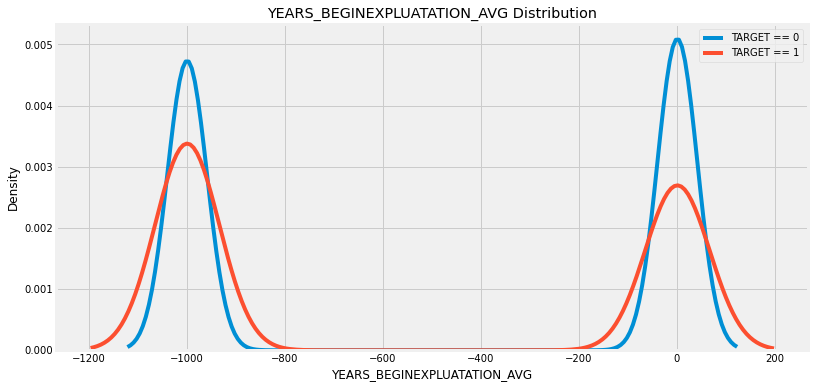

In [1200]:
## 特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_AVG', app_train)

In [1201]:
## Yao-Johnson変換
num_cols = ['YEARS_BEGINEXPLUATATION_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BEGINEXPLUATATION_AVG'] = pt.transform(app_train[num_cols])
app_test['YEARS_BEGINEXPLUATATION_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BEGINEXPLUATATION_AVG']].corr()

TARGET  YEARS_BEGINEXPLUATATION_AVG
TARGET                       1.000000                    -0.040645
YEARS_BEGINEXPLUATATION_AVG -0.040645                     1.000000

In [1202]:
## 標準化
num_cols = ['YEARS_BEGINEXPLUATATION_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['YEARS_BEGINEXPLUATATION_AVG', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_AVG    TARGET
YEARS_BEGINEXPLUATATION_AVG                     1.000000 -0.040645
TARGET                                         -0.040645  1.000000

The correlation between YEARS_BEGINEXPLUATATION_AVG and the TARGET is -0.0406
Median value for loan that was not repaid = -1.0246
Median value for loan that was repaid =     0.9700


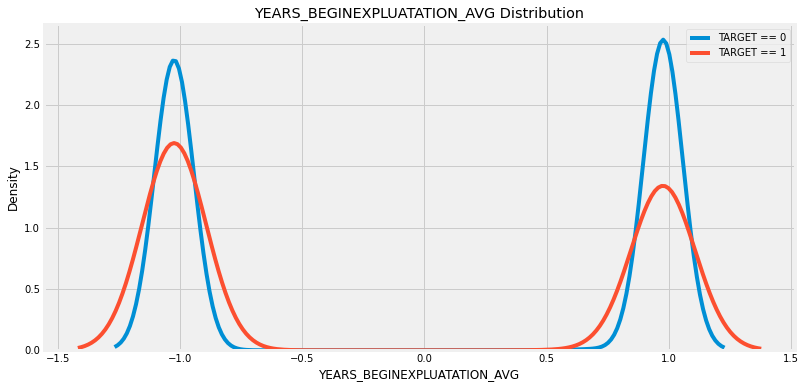

In [1203]:
## 特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_AVG', app_train)

### YEARS_BUILD_AVG

In [1204]:
### Originから切り戻し
app_train['YEARS_BUILD_AVG'] = app_train_origin['YEARS_BUILD_AVG'].copy()
app_test['YEARS_BUILD_AVG'] = app_test_origin['YEARS_BUILD_AVG'].copy()
app_train['YEARS_BUILD_AVG'].isnull().sum()

204488

In [1205]:
app_train['YEARS_BUILD_AVG'].isnull().sum()

204488

In [1206]:
app_train['YEARS_BUILD_AVG'].value_counts()

0.8232    2999
0.8164    2864
0.8028    2848
0.7280    2802
0.7348    2761
          ... 
0.1976       2
0.3744       2
0.0004       2
0.0276       1
0.0208       1
Name: YEARS_BUILD_AVG, Length: 149, dtype: int64

In [1207]:
## 目的変数との相関
app_train[['TARGET', 'YEARS_BUILD_AVG']].corr()

TARGET  YEARS_BUILD_AVG
TARGET           1.000000        -0.022149
YEARS_BUILD_AVG -0.022149         1.000000

In [1208]:
### 0埋めで欠損値補完
app_train['YEARS_BUILD_AVG'] = app_train['YEARS_BUILD_AVG'].fillna(-999)
app_test['YEARS_BUILD_AVG'] = app_test['YEARS_BUILD_AVG'].fillna(-999)
app_train['YEARS_BUILD_AVG'].isnull().sum()

0

In [1209]:
## 目的変数との相関
app_train[['TARGET', 'YEARS_BUILD_AVG']].corr()

TARGET  YEARS_BUILD_AVG
TARGET           1.000000        -0.031436
YEARS_BUILD_AVG -0.031436         1.000000

The correlation between YEARS_BUILD_AVG and the TARGET is -0.0314
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


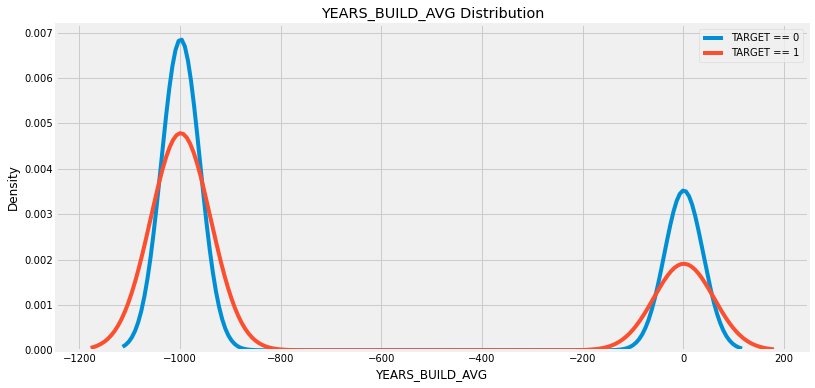

In [1210]:
## 特徴量の分布
kde_target('YEARS_BUILD_AVG', app_train)

In [1211]:
## Yao-Johnson変換
#num_cols = ['YEARS_BUILD_AVG']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['YEARS_BUILD_AVG'] = pt.transform(app_train[num_cols])
#app_test['YEARS_BUILD_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'YEARS_BUILD_AVG']].corr()

In [1212]:
## 標準化
num_cols = ['YEARS_BUILD_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['YEARS_BUILD_AVG', 'TARGET']].corr()

YEARS_BUILD_AVG    TARGET
YEARS_BUILD_AVG         1.000000 -0.031436
TARGET                 -0.031436  1.000000

The correlation between YEARS_BUILD_AVG and the TARGET is -0.0314
Median value for loan that was not repaid = -0.7098
Median value for loan that was repaid =     -0.7098


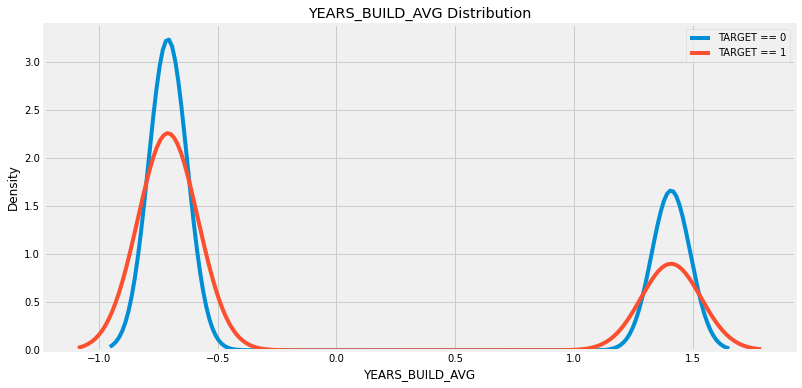

In [1213]:
kde_target('YEARS_BUILD_AVG', app_train)

### COMMONAREA_AVG

In [1214]:
### Originから切り戻し
app_train['COMMONAREA_AVG'] = app_train_origin['COMMONAREA_AVG'].copy()
app_test['COMMONAREA_AVG'] = app_test_origin['COMMONAREA_AVG'].copy()
app_train['COMMONAREA_AVG'].isnull().sum()

214865

In [1215]:
app_train['COMMONAREA_AVG'].value_counts()

0.0000    8442
0.0079     544
0.0078     475
0.0080     446
0.0077     414
          ... 
0.2299       1
0.2496       1
0.2737       1
0.3814       1
0.1620       1
Name: COMMONAREA_AVG, Length: 3181, dtype: int64

In [1216]:
app_train[['COMMONAREA_AVG', 'TARGET']].corr()

COMMONAREA_AVG   TARGET
COMMONAREA_AVG         1.00000 -0.01855
TARGET                -0.01855  1.00000

In [1217]:
### 0埋めで欠損値補完
app_train['COMMONAREA_AVG'] = app_train['COMMONAREA_AVG'].fillna(-999)
app_test['COMMONAREA_AVG'] = app_test['COMMONAREA_AVG'].fillna(-999)
app_train['COMMONAREA_AVG'].isnull().sum()

0

In [1218]:
app_train[['COMMONAREA_AVG', 'TARGET']].corr()

COMMONAREA_AVG    TARGET
COMMONAREA_AVG        1.000000 -0.028027
TARGET               -0.028027  1.000000

The correlation between COMMONAREA_AVG and the TARGET is -0.0280
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


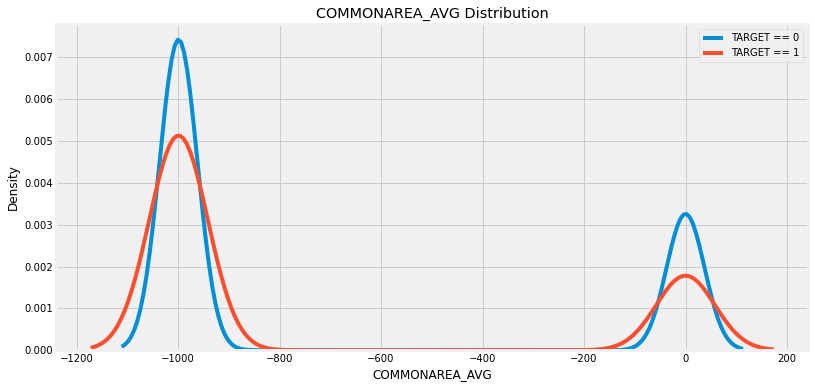

In [1219]:
## 特徴量の分布
kde_target('COMMONAREA_AVG', app_train)

In [1220]:
## Yao-Johnson変換
num_cols = ['COMMONAREA_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['COMMONAREA_AVG'] = pt.transform(app_train[num_cols])
app_test['COMMONAREA_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'COMMONAREA_AVG']].corr()

TARGET  COMMONAREA_AVG
TARGET          1.000000       -0.028054
COMMONAREA_AVG -0.028054        1.000000

In [1221]:
## 標準化
num_cols = ['COMMONAREA_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['COMMONAREA_AVG', 'TARGET']].corr()

COMMONAREA_AVG    TARGET
COMMONAREA_AVG        1.000000 -0.028054
TARGET               -0.028054  1.000000

The correlation between COMMONAREA_AVG and the TARGET is -0.0281
Median value for loan that was not repaid = -0.6566
Median value for loan that was repaid =     -0.6566


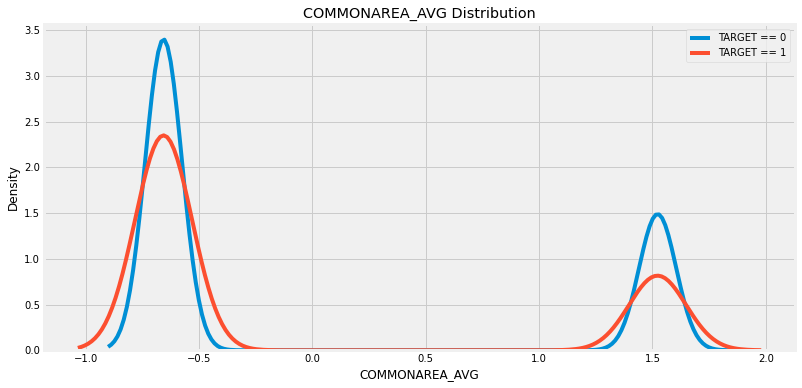

In [1222]:
## Yao-Johnson変換後の特徴量の分布
kde_target('COMMONAREA_AVG', app_train)

### ELEVATORS_AVG

In [1223]:
### Originから切り戻し
app_train['ELEVATORS_AVG'] = app_train_origin['ELEVATORS_AVG'].copy()
app_test['ELEVATORS_AVG'] = app_test_origin['ELEVATORS_AVG'].copy()
app_train['ELEVATORS_AVG'].isnull().sum()

163891

In [1224]:
app_train['ELEVATORS_AVG'].isnull().sum()

163891

In [1225]:
app_train['ELEVATORS_AVG'].value_counts()

0.0000    85718
0.0800     9886
0.1600     8806
0.2400     6071
0.1200     5593
          ...  
0.2284        1
0.0828        1
0.0232        1
0.0180        1
0.0528        1
Name: ELEVATORS_AVG, Length: 257, dtype: int64

In [1226]:
app_train[['ELEVATORS_AVG', 'TARGET']].corr()

ELEVATORS_AVG    TARGET
ELEVATORS_AVG       1.000000 -0.034199
TARGET             -0.034199  1.000000

In [1227]:
### 0埋めで欠損値補完
app_train['ELEVATORS_AVG'] = app_train['ELEVATORS_AVG'].fillna(-999)
app_test['ELEVATORS_AVG'] = app_test['ELEVATORS_AVG'].fillna(-999)
app_train['ELEVATORS_AVG'].isnull().sum()

0

In [1228]:
app_train[['ELEVATORS_AVG', 'TARGET']].corr()

ELEVATORS_AVG    TARGET
ELEVATORS_AVG       1.000000 -0.040303
TARGET             -0.040303  1.000000

The correlation between ELEVATORS_AVG and the TARGET is -0.0403
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


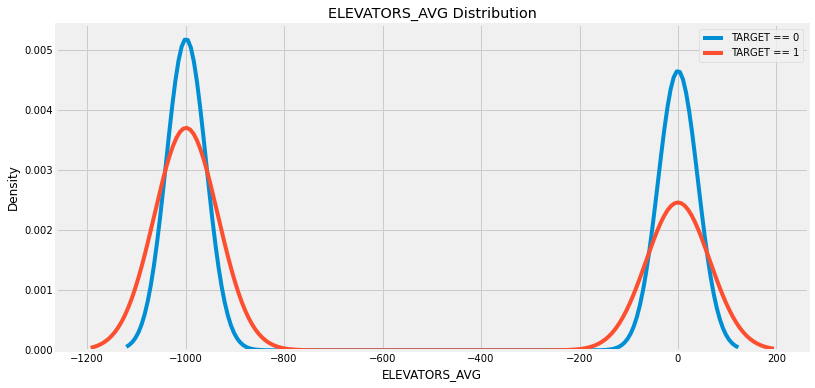

In [1229]:
## 特徴量の分布
kde_target('ELEVATORS_AVG', app_train)

In [1230]:
## Yao-Johnson変換
num_cols = ['ELEVATORS_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ELEVATORS_AVG'] = pt.transform(app_train[num_cols])
app_test['ELEVATORS_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ELEVATORS_AVG']].corr()

TARGET  ELEVATORS_AVG
TARGET         1.000000      -0.040828
ELEVATORS_AVG -0.040828       1.000000

In [1231]:
## 標準化
num_cols = ['ELEVATORS_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['ELEVATORS_AVG', 'TARGET']].corr()

ELEVATORS_AVG    TARGET
ELEVATORS_AVG       1.000000 -0.040828
TARGET             -0.040828  1.000000

The correlation between ELEVATORS_AVG and the TARGET is -0.0408
Median value for loan that was not repaid = -0.9358
Median value for loan that was repaid =     -0.9358


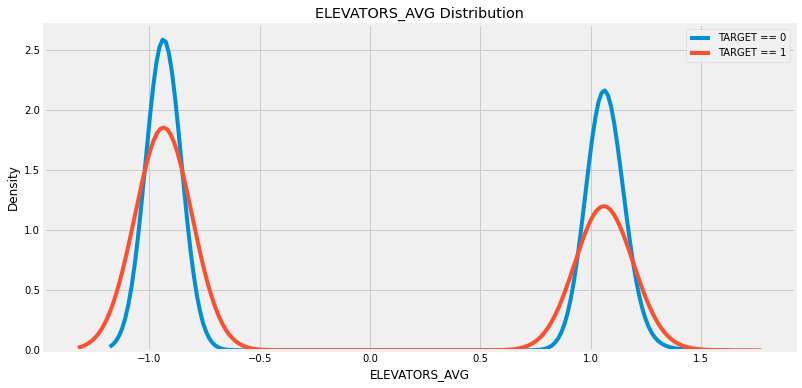

In [1232]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ELEVATORS_AVG', app_train)

### ENTRANCES_AVG

In [1233]:
### Originから切り戻し
app_train['ENTRANCES_AVG'] = app_train_origin['ENTRANCES_AVG'].copy()
app_test['ENTRANCES_AVG'] = app_test_origin['ENTRANCES_AVG'].copy()
app_train['ENTRANCES_AVG'].isnull().sum()

154828

In [1234]:
app_train['ENTRANCES_AVG'].value_counts()

0.1379    34007
0.0690    22956
0.1034    19533
0.2069    19062
0.0345    15380
          ...  
0.0355        1
0.1645        1
0.2145        1
0.1341        1
0.1059        1
Name: ENTRANCES_AVG, Length: 285, dtype: int64

In [1235]:
app_train[['ENTRANCES_AVG', 'TARGET']].corr()

ENTRANCES_AVG    TARGET
ENTRANCES_AVG       1.000000 -0.019172
TARGET             -0.019172  1.000000

In [1236]:
### 0埋めで欠損値補完
app_train['ENTRANCES_AVG'] = app_train['ENTRANCES_AVG'].fillna(-999)
app_test['ENTRANCES_AVG'] = app_test['ENTRANCES_AVG'].fillna(-999)
app_train['ENTRANCES_AVG'].isnull().sum()

0

In [1237]:
app_train[['ENTRANCES_AVG', 'TARGET']].corr()

ENTRANCES_AVG    TARGET
ENTRANCES_AVG       1.000000 -0.040874
TARGET             -0.040874  1.000000

In [1238]:
## Yao-Johnson変換
num_cols = ['ENTRANCES_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ENTRANCES_AVG'] = pt.transform(app_train[num_cols])
app_test['ENTRANCES_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ENTRANCES_AVG']].corr()

TARGET  ENTRANCES_AVG
TARGET         1.000000      -0.041144
ENTRANCES_AVG -0.041144       1.000000

In [1239]:
## 標準化
num_cols = ['ENTRANCES_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['ENTRANCES_AVG', 'TARGET']].corr()

ENTRANCES_AVG    TARGET
ENTRANCES_AVG       1.000000 -0.041144
TARGET             -0.041144  1.000000

The correlation between ENTRANCES_AVG and the TARGET is -0.0411
Median value for loan that was not repaid = -0.9927
Median value for loan that was repaid =     0.9710


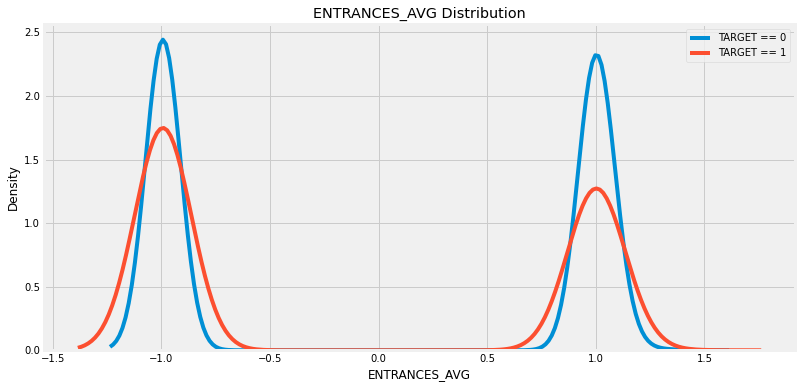

In [1240]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ENTRANCES_AVG', app_train)

### FLOORSMAX_AVG

In [1241]:
### Originから切り戻し
app_train['FLOORSMAX_AVG'] = app_train_origin['FLOORSMAX_AVG'].copy()
app_test['FLOORSMAX_AVG'] = app_test_origin['FLOORSMAX_AVG'].copy()
app_train['FLOORSMAX_AVG'].isnull().sum()

153020

In [1242]:
app_train['FLOORSMAX_AVG'].value_counts()

0.1667    61875
0.3333    31909
0.0417    14600
0.3750     7926
0.1250     6974
          ...  
0.1792        1
0.2200        1
0.1133        1
0.0900        1
0.2042        1
Name: FLOORSMAX_AVG, Length: 403, dtype: int64

In [1243]:
app_train[['FLOORSMAX_AVG', 'TARGET']].corr()

FLOORSMAX_AVG    TARGET
FLOORSMAX_AVG       1.000000 -0.044003
TARGET             -0.044003  1.000000

In [1244]:
### 0埋めで欠損値補完
app_train['FLOORSMAX_AVG'] = app_train['FLOORSMAX_AVG'].fillna(0)
app_test['FLOORSMAX_AVG'] = app_test['FLOORSMAX_AVG'].fillna(0)
app_train['FLOORSMAX_AVG'].isnull().sum()

0

In [1245]:
app_train[['FLOORSMAX_AVG', 'TARGET']].corr()

FLOORSMAX_AVG    TARGET
FLOORSMAX_AVG       1.000000 -0.049839
TARGET             -0.049839  1.000000

The correlation between FLOORSMAX_AVG and the TARGET is -0.0498
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


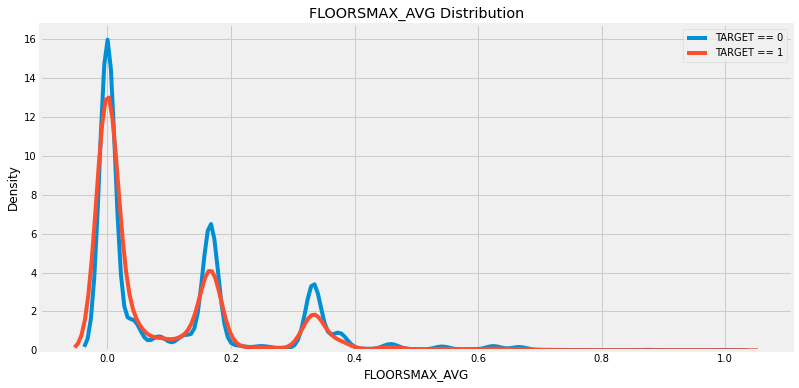

In [1246]:
## 特徴量の分布
kde_target('FLOORSMAX_AVG', app_train)

In [1247]:
## Yao-Johnson変換
num_cols = ['FLOORSMAX_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['FLOORSMAX_AVG'] = pt.transform(app_train[num_cols])
app_test['FLOORSMAX_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'FLOORSMAX_AVG']].corr()

TARGET  FLOORSMAX_AVG
TARGET         1.000000      -0.050041
FLOORSMAX_AVG -0.050041       1.000000

In [1248]:
## 標準化
num_cols = ['FLOORSMAX_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['FLOORSMAX_AVG', 'TARGET']].corr()

FLOORSMAX_AVG    TARGET
FLOORSMAX_AVG       1.000000 -0.050041
TARGET             -0.050041  1.000000

The correlation between FLOORSMAX_AVG and the TARGET is -0.0500
Median value for loan that was not repaid = -0.9028
Median value for loan that was repaid =     -0.9028


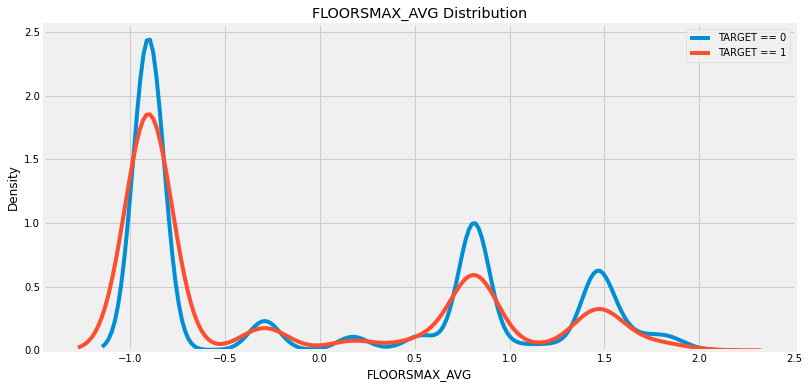

In [1249]:
## Yao-Johnson変換後の特徴量の分布
kde_target('FLOORSMAX_AVG', app_train)

### LANDAREA_AVG

In [1250]:
### Originから切り戻し
app_train['LANDAREA_AVG'] = app_train_origin['LANDAREA_AVG'].copy()
app_test['LANDAREA_AVG'] = app_test_origin['LANDAREA_AVG'].copy()
app_train['LANDAREA_AVG'].isnull().sum()

182590

In [1251]:
app_train['LANDAREA_AVG'].value_counts()

0.0000    15600
0.0631      189
0.0316      187
0.0473      186
0.0174      180
          ...  
0.2617        1
0.2539        1
0.2416        1
0.3417        1
0.3130        1
Name: LANDAREA_AVG, Length: 3527, dtype: int64

In [1252]:
app_train[['LANDAREA_AVG', 'TARGET']].corr()

LANDAREA_AVG    TARGET
LANDAREA_AVG      1.000000 -0.010885
TARGET           -0.010885  1.000000

In [1253]:
### 0埋めで欠損値補完
app_train['LANDAREA_AVG'] = app_train['LANDAREA_AVG'].fillna(-999)
app_test['LANDAREA_AVG'] = app_test['LANDAREA_AVG'].fillna(-999)
app_train['LANDAREA_AVG'].isnull().sum()

0

In [1254]:
app_train[['LANDAREA_AVG', 'TARGET']].corr()

LANDAREA_AVG    TARGET
LANDAREA_AVG      1.000000 -0.033147
TARGET           -0.033147  1.000000

The correlation between LANDAREA_AVG and the TARGET is -0.0331
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


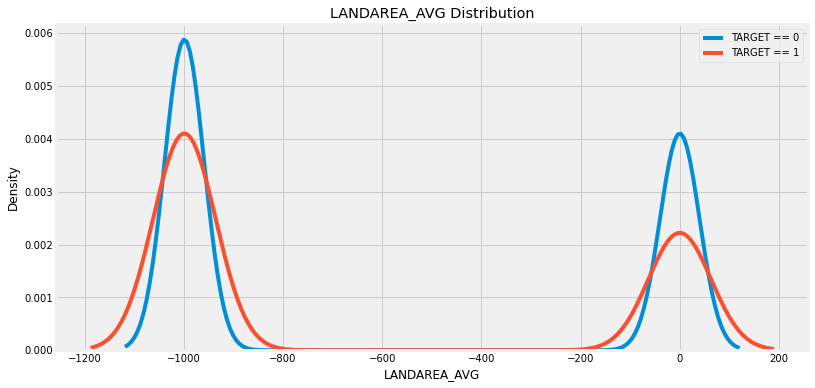

In [1255]:
## 特徴量の分布
kde_target('LANDAREA_AVG', app_train)

In [1256]:
## Yao-Johnson変換
num_cols = ['LANDAREA_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LANDAREA_AVG'] = pt.transform(app_train[num_cols])
app_test['LANDAREA_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LANDAREA_AVG']].corr()

TARGET  LANDAREA_AVG
TARGET        1.0000       -0.0332
LANDAREA_AVG -0.0332        1.0000

In [1257]:
## 標準化
num_cols = ['LANDAREA_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['LANDAREA_AVG', 'TARGET']].corr()

LANDAREA_AVG  TARGET
LANDAREA_AVG        1.0000 -0.0332
TARGET             -0.0332  1.0000

The correlation between LANDAREA_AVG and the TARGET is -0.0332
Median value for loan that was not repaid = -0.8271
Median value for loan that was repaid =     -0.8271


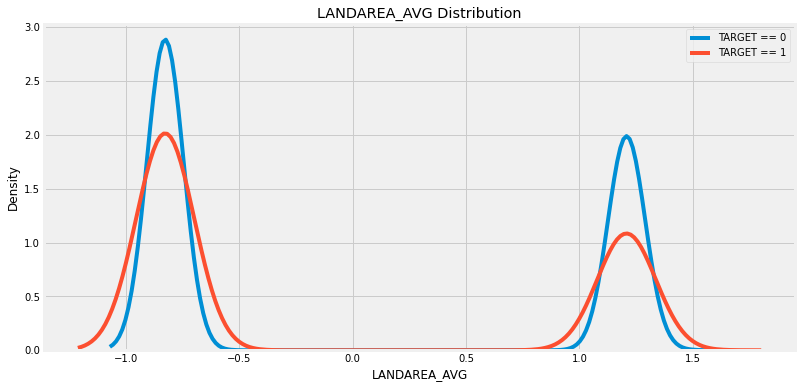

In [1258]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LANDAREA_AVG', app_train)

### LIVINGAPARTMENTS_AVG

In [1259]:
### Originから切り戻し
app_train['LIVINGAPARTMENTS_AVG'] = app_train_origin['LIVINGAPARTMENTS_AVG'].copy()
app_test['LIVINGAPARTMENTS_AVG'] = app_test_origin['LIVINGAPARTMENTS_AVG'].copy()
app_train['LIVINGAPARTMENTS_AVG'].isnull().sum()

210199

In [1260]:
app_train['LIVINGAPARTMENTS_AVG'].value_counts()

0.0504    4272
0.0672    4231
0.0756    2778
0.0588    2586
0.0841    1864
          ... 
0.7128       1
0.1401       1
0.5085       1
0.1575       1
0.1543       1
Name: LIVINGAPARTMENTS_AVG, Length: 1868, dtype: int64

In [1261]:
app_train[['LIVINGAPARTMENTS_AVG', 'TARGET']].corr()

LIVINGAPARTMENTS_AVG    TARGET
LIVINGAPARTMENTS_AVG              1.000000 -0.025031
TARGET                           -0.025031  1.000000

In [1262]:
### -999埋めで欠損値補完
app_train['LIVINGAPARTMENTS_AVG'] = app_train['LIVINGAPARTMENTS_AVG'].fillna(-999)
app_test['LIVINGAPARTMENTS_AVG'] = app_test['LIVINGAPARTMENTS_AVG'].fillna(-999)
app_train['LIVINGAPARTMENTS_AVG'].isnull().sum()

0

In [1263]:
app_train[['LIVINGAPARTMENTS_AVG', 'TARGET']].corr()

LIVINGAPARTMENTS_AVG    TARGET
LIVINGAPARTMENTS_AVG              1.000000 -0.029592
TARGET                           -0.029592  1.000000

The correlation between LIVINGAPARTMENTS_AVG and the TARGET is -0.0296
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


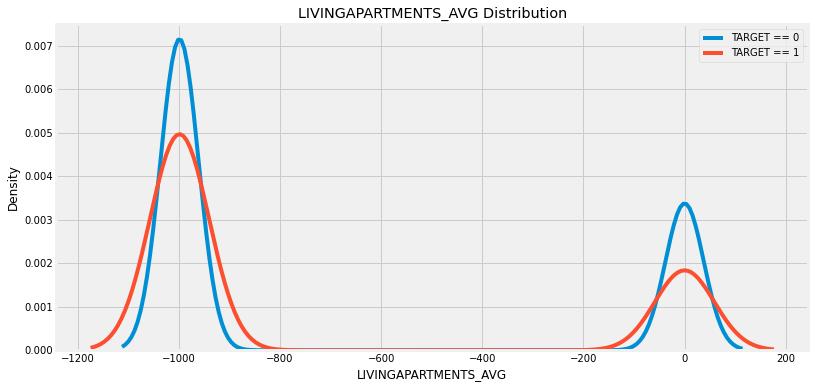

In [1264]:
## 特徴量の分布
kde_target('LIVINGAPARTMENTS_AVG', app_train)

In [1265]:
## Yao-Johnson変換
num_cols = ['LIVINGAPARTMENTS_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAPARTMENTS_AVG'] = pt.transform(app_train[num_cols])
app_test['LIVINGAPARTMENTS_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAPARTMENTS_AVG']].corr()

TARGET  LIVINGAPARTMENTS_AVG
TARGET                1.000000             -0.029646
LIVINGAPARTMENTS_AVG -0.029646              1.000000

In [1266]:
## 標準化
num_cols = ['LIVINGAPARTMENTS_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['LIVINGAPARTMENTS_AVG', 'TARGET']].corr()

LIVINGAPARTMENTS_AVG    TARGET
LIVINGAPARTMENTS_AVG              1.000000 -0.029646
TARGET                           -0.029646  1.000000

The correlation between LIVINGAPARTMENTS_AVG and the TARGET is -0.0296
Median value for loan that was not repaid = -0.6804
Median value for loan that was repaid =     -0.6804


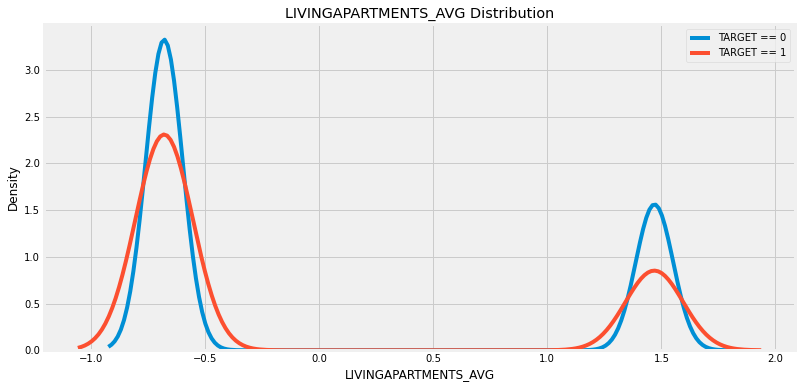

In [1267]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAPARTMENTS_AVG', app_train)

### LIVINGAREA_AVG

In [1268]:
### Originから切り戻し
app_train['LIVINGAREA_AVG'] = app_train_origin['LIVINGAREA_AVG'].copy()
app_test['LIVINGAREA_AVG'] = app_test_origin['LIVINGAREA_AVG'].copy()
app_train['LIVINGAREA_AVG'].isnull().sum()

154350

In [1269]:
app_train['LIVINGAREA_AVG'].isnull().sum()

154350

In [1270]:
app_train['LIVINGAREA_AVG'].value_counts()

0.0000    284
0.0512    243
0.0510    223
0.0702    223
0.0509    221
         ... 
0.3750      1
0.5441      1
0.4038      1
0.3755      1
0.9279      1
Name: LIVINGAREA_AVG, Length: 5199, dtype: int64

In [1271]:
app_train[['LIVINGAREA_AVG', 'TARGET']].corr()

LIVINGAREA_AVG    TARGET
LIVINGAREA_AVG        1.000000 -0.032997
TARGET               -0.032997  1.000000

In [1272]:
### -999埋めで欠損値補完
app_train['LIVINGAREA_AVG'] = app_train['LIVINGAREA_AVG'].fillna(-999)
app_test['LIVINGAREA_AVG'] = app_test['LIVINGAREA_AVG'].fillna(-999)
app_train['LIVINGAREA_AVG'].isnull().sum()

0

In [1273]:
app_train[['LIVINGAREA_AVG', 'TARGET']].corr()

LIVINGAREA_AVG    TARGET
LIVINGAREA_AVG        1.000000 -0.039409
TARGET               -0.039409  1.000000

The correlation between LIVINGAREA_AVG and the TARGET is -0.0394
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     0.0019


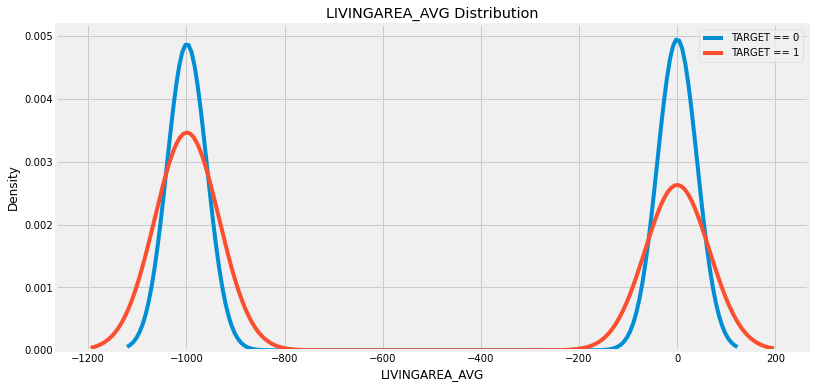

In [1274]:
## 特徴量の分布
kde_target('LIVINGAREA_AVG', app_train)

In [1275]:
## Yao-Johnson変換
num_cols = ['LIVINGAREA_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAREA_AVG'] = pt.transform(app_train[num_cols])
app_test['LIVINGAREA_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAREA_AVG']].corr()

TARGET  LIVINGAREA_AVG
TARGET          1.000000       -0.039948
LIVINGAREA_AVG -0.039948        1.000000

In [1276]:
## 標準化
num_cols = ['LIVINGAREA_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['LIVINGAREA_AVG', 'TARGET']].corr()

LIVINGAREA_AVG    TARGET
LIVINGAREA_AVG        1.000000 -0.039948
TARGET               -0.039948  1.000000

The correlation between LIVINGAREA_AVG and the TARGET is -0.0399
Median value for loan that was not repaid = -0.9958
Median value for loan that was repaid =     0.9709


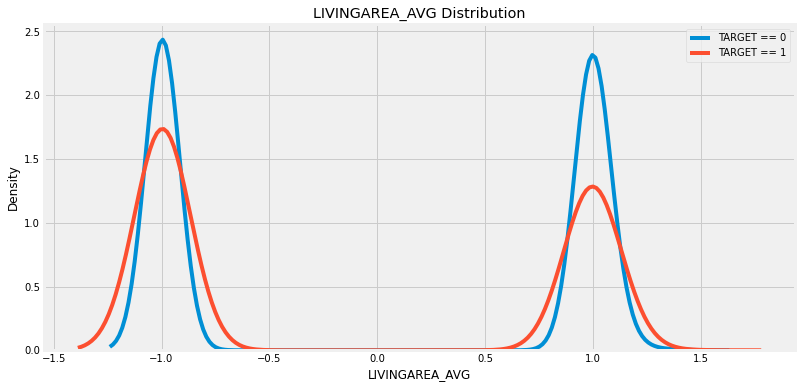

In [1277]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAREA_AVG', app_train)

### NONLIVINGAPARTMENTS_AVG

In [1278]:
### Originから切り戻し
app_train['NONLIVINGAPARTMENTS_AVG'] = app_train_origin['NONLIVINGAPARTMENTS_AVG'].copy()
app_test['NONLIVINGAPARTMENTS_AVG'] = app_test_origin['NONLIVINGAPARTMENTS_AVG'].copy()
app_train['NONLIVINGAPARTMENTS_AVG'].isnull().sum()

213514

In [1279]:
app_train['NONLIVINGAPARTMENTS_AVG'].isnull().sum()

213514

In [1280]:
app_train['NONLIVINGAPARTMENTS_AVG'].value_counts()

0.0000    54549
0.0039    13606
0.0077     6351
0.0116     3714
0.0154     2533
          ...  
0.2664        1
0.0323        1
0.0946        1
0.0091        1
0.0319        1
Name: NONLIVINGAPARTMENTS_AVG, Length: 386, dtype: int64

In [1281]:
app_train[['NONLIVINGAPARTMENTS_AVG', 'TARGET']].corr()

NONLIVINGAPARTMENTS_AVG    TARGET
NONLIVINGAPARTMENTS_AVG                 1.000000 -0.003176
TARGET                                 -0.003176  1.000000

In [1282]:
### -999埋めで欠損値補完
app_train['NONLIVINGAPARTMENTS_AVG'] = app_train['NONLIVINGAPARTMENTS_AVG'].fillna(-99999)
app_test['NONLIVINGAPARTMENTS_AVG'] = app_test['NONLIVINGAPARTMENTS_AVG'].fillna(-99999)
app_train['NONLIVINGAPARTMENTS_AVG'].isnull().sum()

0

In [1283]:
app_train[['NONLIVINGAPARTMENTS_AVG', 'TARGET']].corr()

NONLIVINGAPARTMENTS_AVG    TARGET
NONLIVINGAPARTMENTS_AVG                 1.000000 -0.028251
TARGET                                 -0.028251  1.000000

The correlation between NONLIVINGAPARTMENTS_AVG and the TARGET is -0.0283
Median value for loan that was not repaid = -99999.0000
Median value for loan that was repaid =     -99999.0000


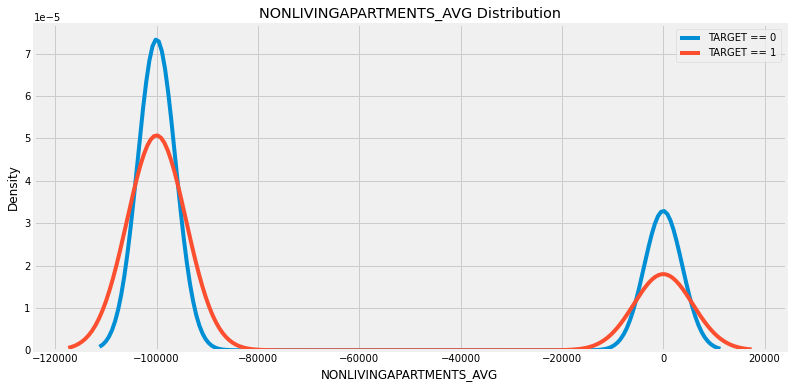

In [1284]:
## 特徴量の分布
kde_target('NONLIVINGAPARTMENTS_AVG', app_train)

In [1285]:
## Yao-Johnson変換
num_cols = ['NONLIVINGAPARTMENTS_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['NONLIVINGAPARTMENTS_AVG'] = pt.transform(app_train[num_cols])
app_test['NONLIVINGAPARTMENTS_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'NONLIVINGAPARTMENTS_AVG']].corr()

TARGET  NONLIVINGAPARTMENTS_AVG
TARGET                   1.000000                -0.028252
NONLIVINGAPARTMENTS_AVG -0.028252                 1.000000

In [1286]:
## 標準化
num_cols = ['NONLIVINGAPARTMENTS_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['NONLIVINGAPARTMENTS_AVG', 'TARGET']].corr()

NONLIVINGAPARTMENTS_AVG    TARGET
NONLIVINGAPARTMENTS_AVG                 1.000000 -0.028252
TARGET                                 -0.028252  1.000000

The correlation between NONLIVINGAPARTMENTS_AVG and the TARGET is -0.0283
Median value for loan that was not repaid = -0.6635
Median value for loan that was repaid =     -0.6635


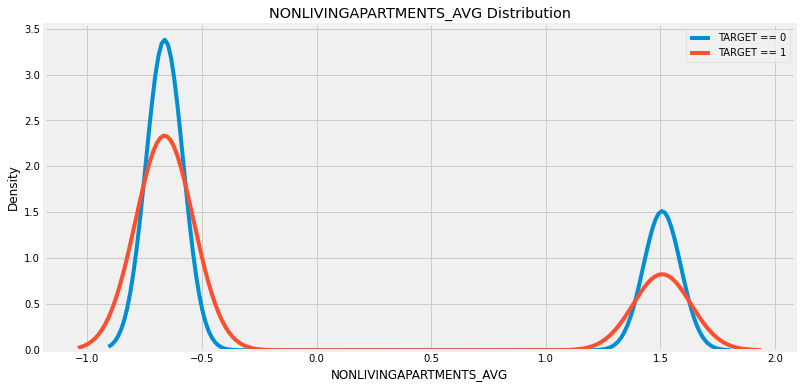

In [1287]:
## Yao-Johnson変換後の特徴量の分布
kde_target('NONLIVINGAPARTMENTS_AVG', app_train)

### NONLIVINGAREA_AVG

In [1288]:
### Originから切り戻し
app_train['NONLIVINGAREA_AVG'] = app_train_origin['NONLIVINGAREA_AVG'].copy()
app_test['NONLIVINGAREA_AVG'] = app_test_origin['NONLIVINGAREA_AVG'].copy()
app_train['NONLIVINGAREA_AVG'].isnull().sum()

169682

In [1289]:
app_train['NONLIVINGAREA_AVG'].isnull().sum()

169682

In [1290]:
app_train['NONLIVINGAREA_AVG'].value_counts()

0.0000    58735
0.0012      546
0.0044      454
0.0022      440
0.0031      415
          ...  
0.2989        1
0.1611        1
0.6946        1
0.2554        1
0.2879        1
Name: NONLIVINGAREA_AVG, Length: 3290, dtype: int64

In [1291]:
app_train[['NONLIVINGAREA_AVG', 'TARGET']].corr()

NONLIVINGAREA_AVG    TARGET
NONLIVINGAREA_AVG           1.000000 -0.013578
TARGET                     -0.013578  1.000000

In [1292]:
### -999埋めで欠損値補完
app_train['NONLIVINGAREA_AVG'] = app_train['NONLIVINGAREA_AVG'].fillna(-99999)
app_test['NONLIVINGAREA_AVG'] = app_test['NONLIVINGAREA_AVG'].fillna(-99999)
app_train['NONLIVINGAREA_AVG'].isnull().sum()

0

In [1293]:
app_train[['NONLIVINGAREA_AVG', 'TARGET']].corr()

NONLIVINGAREA_AVG    TARGET
NONLIVINGAREA_AVG           1.000000 -0.039168
TARGET                     -0.039168  1.000000

The correlation between NONLIVINGAREA_AVG and the TARGET is -0.0392
Median value for loan that was not repaid = -99999.0000
Median value for loan that was repaid =     -99999.0000


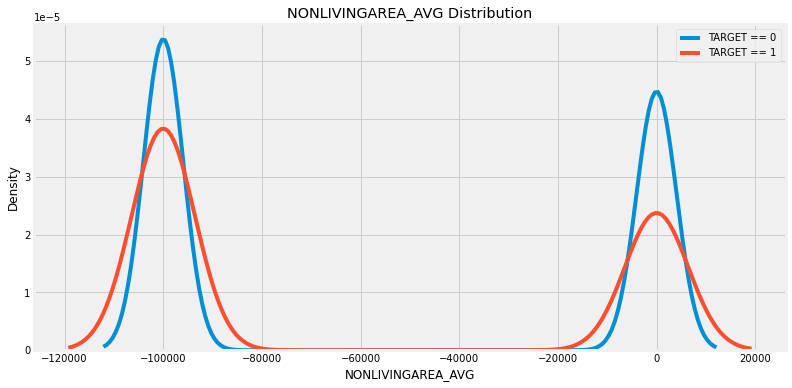

In [1294]:
## 特徴量の分布
kde_target('NONLIVINGAREA_AVG', app_train)

In [1295]:
## Yao-Johnson変換
num_cols = ['NONLIVINGAREA_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['NONLIVINGAREA_AVG'] = pt.transform(app_train[num_cols])
app_test['NONLIVINGAREA_AVG'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'NONLIVINGAREA_AVG']].corr()

TARGET  NONLIVINGAREA_AVG
TARGET             1.000000          -0.039224
NONLIVINGAREA_AVG -0.039224           1.000000

In [1296]:
## 標準化
num_cols = ['NONLIVINGAREA_AVG']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['NONLIVINGAREA_AVG', 'TARGET']].corr()

NONLIVINGAREA_AVG    TARGET
NONLIVINGAREA_AVG           1.000000 -0.039224
TARGET                     -0.039224  1.000000

The correlation between NONLIVINGAREA_AVG and the TARGET is -0.0392
Median value for loan that was not repaid = -0.9012
Median value for loan that was repaid =     -0.9012


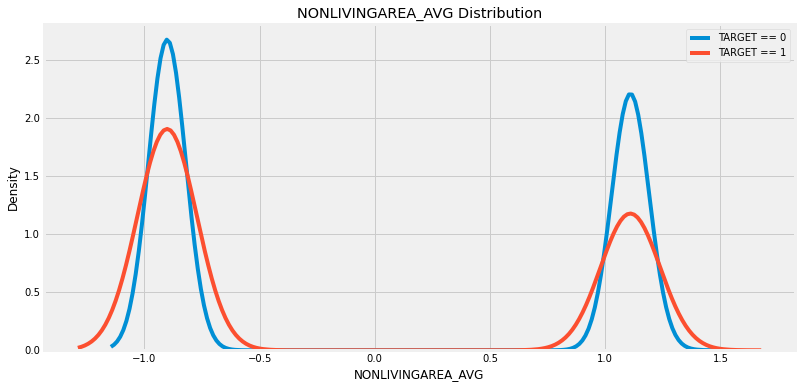

In [1297]:
## Yao-Johnson変換後の特徴量の分布
kde_target('NONLIVINGAREA_AVG', app_train)

### APARTMENTS_MODE

In [1298]:
### Originから切り戻し
app_train['APARTMENTS_MODE'] = app_train_origin['APARTMENTS_MODE'].copy()
app_test['APARTMENTS_MODE'] = app_test_origin['APARTMENTS_MODE'].copy()
app_train['APARTMENTS_MODE'].isnull().sum()

156061

In [1299]:
app_train['APARTMENTS_MODE'].isnull().sum()

156061

In [1300]:
app_train['APARTMENTS_MODE'].value_counts()

0.0840    7522
0.0630    7451
0.0945    4757
0.0735    4388
0.0084    3970
          ... 
0.8445       1
0.9181       1
0.7458       1
0.8971       1
0.6586       1
Name: APARTMENTS_MODE, Length: 760, dtype: int64

In [1301]:
app_train[['APARTMENTS_MODE', 'TARGET']].corr()

APARTMENTS_MODE    TARGET
APARTMENTS_MODE         1.000000 -0.027284
TARGET                 -0.027284  1.000000

In [1302]:
### -999埋めで欠損値補完
app_train['APARTMENTS_MODE'] = app_train['APARTMENTS_MODE'].fillna(-999)
app_test['APARTMENTS_MODE'] = app_test['APARTMENTS_MODE'].fillna(-999)
app_train['APARTMENTS_MODE'].isnull().sum()

0

In [1303]:
app_train[['APARTMENTS_MODE', 'TARGET']].corr()

APARTMENTS_MODE    TARGET
APARTMENTS_MODE         1.000000 -0.040269
TARGET                 -0.040269  1.000000

The correlation between APARTMENTS_MODE and the TARGET is -0.0403
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


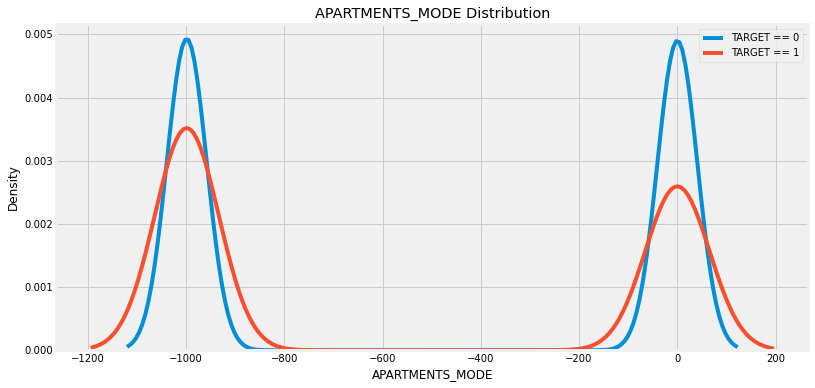

In [1304]:
## 特徴量の分布
kde_target('APARTMENTS_MODE', app_train)

In [1305]:
## Yao-Johnson変換
num_cols = ['APARTMENTS_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['APARTMENTS_MODE'] = pt.transform(app_train[num_cols])
app_test['APARTMENTS_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'APARTMENTS_MODE']].corr()

TARGET  APARTMENTS_MODE
TARGET           1.000000        -0.040679
APARTMENTS_MODE -0.040679         1.000000

In [1306]:
## 標準化
num_cols = ['APARTMENTS_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['APARTMENTS_MODE', 'TARGET']].corr()

APARTMENTS_MODE    TARGET
APARTMENTS_MODE         1.000000 -0.040679
TARGET                 -0.040679  1.000000

The correlation between APARTMENTS_MODE and the TARGET is -0.0407
Median value for loan that was not repaid = -0.9848
Median value for loan that was repaid =     -0.9848


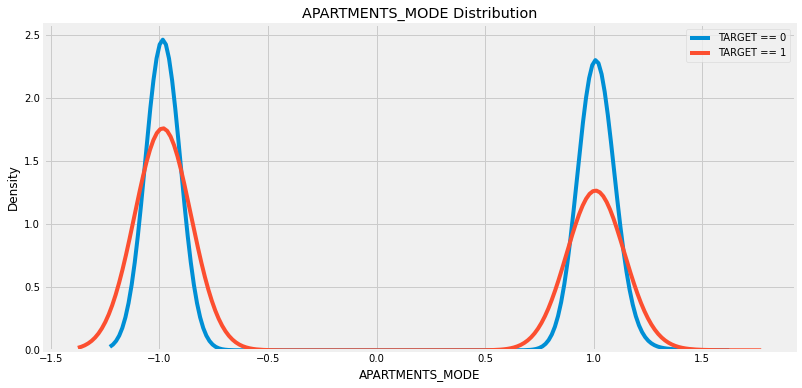

In [1307]:
## Yao-Johnson変換後の特徴量の分布
kde_target('APARTMENTS_MODE', app_train)

### BASEMENTAREA_MODE

In [1308]:
### Originから切り戻し
app_train['BASEMENTAREA_MODE'] = app_train_origin['BASEMENTAREA_MODE'].copy()
app_test['BASEMENTAREA_MODE'] = app_test_origin['BASEMENTAREA_MODE'].copy()
app_train['BASEMENTAREA_MODE'].isnull().sum()

179943

In [1309]:
app_train['BASEMENTAREA_MODE'].isnull().sum()

179943

In [1310]:
app_train['YEARS_BEGINEXPLUATATION_AVG'].value_counts()

-1.024594    150007
 0.979267      4311
 0.978659      4189
 0.978862      4171
 0.976434      4123
              ...  
 0.944392         1
 0.917099         1
 0.754654         1
 0.856353         1
 0.930429         1
Name: YEARS_BEGINEXPLUATATION_AVG, Length: 286, dtype: int64

In [1311]:
app_train[['BASEMENTAREA_MODE', 'TARGET']].corr()

BASEMENTAREA_MODE    TARGET
BASEMENTAREA_MODE           1.000000 -0.019952
TARGET                     -0.019952  1.000000

In [1312]:
### -999埋めで欠損値補完
app_train['BASEMENTAREA_MODE'] = app_train['BASEMENTAREA_MODE'].fillna(-999)
app_test['BASEMENTAREA_MODE'] = app_test['BASEMENTAREA_MODE'].fillna(-999)
app_train['BASEMENTAREA_MODE'].isnull().sum()

0

In [1313]:
app_train[['BASEMENTAREA_MODE', 'TARGET']].corr()

BASEMENTAREA_MODE    TARGET
BASEMENTAREA_MODE           1.000000 -0.036621
TARGET                     -0.036621  1.000000

The correlation between BASEMENTAREA_MODE and the TARGET is -0.0366
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


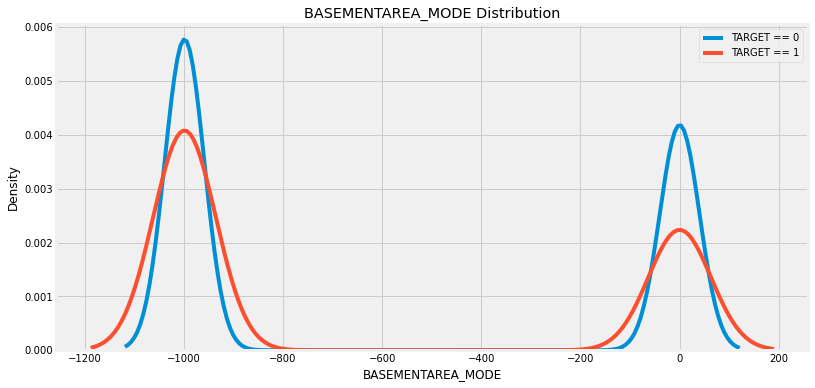

In [1314]:
## 特徴量の分布
kde_target('BASEMENTAREA_MODE', app_train)

In [1315]:
## Yao-Johnson変換
num_cols = ['BASEMENTAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['BASEMENTAREA_MODE'] = pt.transform(app_train[num_cols])
app_test['BASEMENTAREA_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'BASEMENTAREA_MODE']].corr()

TARGET  BASEMENTAREA_MODE
TARGET             1.000000          -0.036742
BASEMENTAREA_MODE -0.036742           1.000000

In [1316]:
## 標準化
num_cols = ['BASEMENTAREA_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['BASEMENTAREA_MODE', 'TARGET']].corr()

BASEMENTAREA_MODE    TARGET
BASEMENTAREA_MODE           1.000000 -0.036742
TARGET                     -0.036742  1.000000

The correlation between BASEMENTAREA_MODE and the TARGET is -0.0367
Median value for loan that was not repaid = -0.8419
Median value for loan that was repaid =     -0.8419


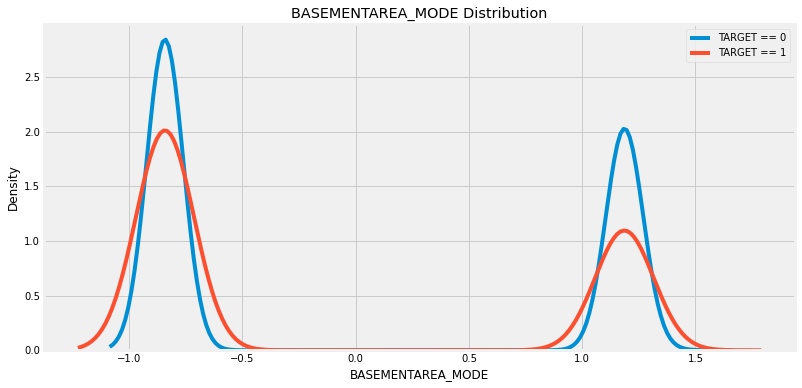

In [1317]:
## Yao-Johnson変換後の特徴量の分布
kde_target('BASEMENTAREA_MODE', app_train)

### YEARS_BEGINEXPLUATATION_MODE

In [1318]:
### Originから切り戻し
app_train['YEARS_BEGINEXPLUATATION_MODE'] = app_train_origin['YEARS_BEGINEXPLUATATION_MODE'].copy()
app_test['YEARS_BEGINEXPLUATATION_MODE'] = app_test_origin['YEARS_BEGINEXPLUATATION_MODE'].copy()
app_train['YEARS_BEGINEXPLUATATION_MODE'].isnull().sum()

150007

In [1319]:
app_train['YEARS_BEGINEXPLUATATION_MODE'].isnull().sum()

150007

In [1320]:
app_train['YEARS_BEGINEXPLUATATION_MODE'].value_counts()

0.9871    4291
0.9866    4173
0.9861    4167
0.9801    4110
0.9806    4083
          ... 
0.4518       1
0.4359       1
0.8987       1
0.9166       1
0.8937       1
Name: YEARS_BEGINEXPLUATATION_MODE, Length: 221, dtype: int64

In [1321]:
app_train[['YEARS_BEGINEXPLUATATION_MODE', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_MODE    TARGET
YEARS_BEGINEXPLUATATION_MODE                      1.000000 -0.009036
TARGET                                           -0.009036  1.000000

In [1322]:
### -999埋めで欠損値補完
app_train['YEARS_BEGINEXPLUATATION_MODE'] = app_train['YEARS_BEGINEXPLUATATION_MODE'].fillna(-999)
app_test['YEARS_BEGINEXPLUATATION_MODE'] = app_test['YEARS_BEGINEXPLUATATION_MODE'].fillna(-999)
app_train['YEARS_BEGINEXPLUATATION_MODE'].isnull().sum()

0

In [1323]:
app_train[['YEARS_BEGINEXPLUATATION_MODE', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_MODE    TARGET
YEARS_BEGINEXPLUATATION_MODE                      1.000000 -0.040554
TARGET                                           -0.040554  1.000000

The correlation between YEARS_BEGINEXPLUATATION_MODE and the TARGET is -0.0406
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     0.9633


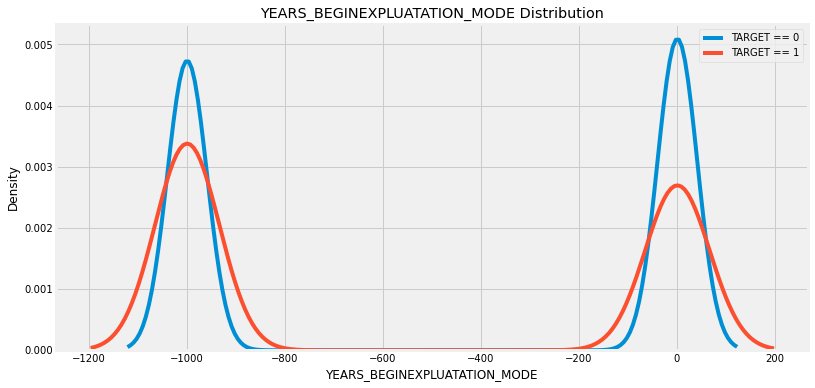

In [1324]:
## 特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_MODE', app_train)

In [1325]:
## Yao-Johnson変換
num_cols = ['YEARS_BEGINEXPLUATATION_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BEGINEXPLUATATION_MODE'] = pt.transform(app_train[num_cols])
app_test['YEARS_BEGINEXPLUATATION_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BEGINEXPLUATATION_MODE']].corr()

TARGET  YEARS_BEGINEXPLUATATION_MODE
TARGET                        1.000000                     -0.040646
YEARS_BEGINEXPLUATATION_MODE -0.040646                      1.000000

In [1326]:
## 標準化
num_cols = ['YEARS_BEGINEXPLUATATION_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['YEARS_BEGINEXPLUATATION_MODE', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_MODE    TARGET
YEARS_BEGINEXPLUATATION_MODE                      1.000000 -0.040646
TARGET                                           -0.040646  1.000000

The correlation between YEARS_BEGINEXPLUATATION_MODE and the TARGET is -0.0406
Median value for loan that was not repaid = -1.0246
Median value for loan that was repaid =     0.9699


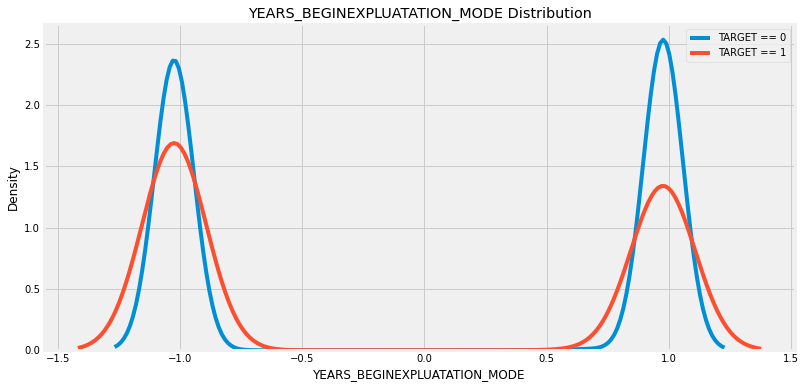

In [1327]:
## Yao-Johnson変換後の特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_MODE', app_train)

### YEARS_BUILD_MODE

In [1328]:
### Originから切り戻し
app_train['YEARS_BUILD_MODE'] = app_train_origin['YEARS_BUILD_MODE'].copy()
app_test['YEARS_BUILD_MODE'] = app_test_origin['YEARS_BUILD_MODE'].copy()
app_train['YEARS_BUILD_MODE'].isnull().sum()

204488

In [1329]:
app_train['YEARS_BUILD_MODE'].isnull().sum()

204488

In [1330]:
app_train['YEARS_BUILD_MODE'].value_counts()

0.8301    2960
0.8236    2879
0.7387    2789
0.8171    2763
0.8105    2755
          ... 
0.0853       2
0.0591       1
0.0983       1
0.0657       1
0.0330       1
Name: YEARS_BUILD_MODE, Length: 154, dtype: int64

In [1331]:
app_train[['YEARS_BUILD_MODE', 'TARGET']].corr()

YEARS_BUILD_MODE    TARGET
YEARS_BUILD_MODE          1.000000 -0.022068
TARGET                   -0.022068  1.000000

In [1332]:
### -999埋めで欠損値補完
app_train['YEARS_BUILD_MODE'] = app_train['YEARS_BUILD_MODE'].fillna(-999)
app_test['YEARS_BUILD_MODE'] = app_test['YEARS_BUILD_MODE'].fillna(-999)
app_train['YEARS_BUILD_MODE'].isnull().sum()

0

In [1333]:
app_train[['YEARS_BUILD_MODE', 'TARGET']].corr()

YEARS_BUILD_MODE    TARGET
YEARS_BUILD_MODE          1.000000 -0.031436
TARGET                   -0.031436  1.000000

The correlation between YEARS_BUILD_MODE and the TARGET is -0.0314
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


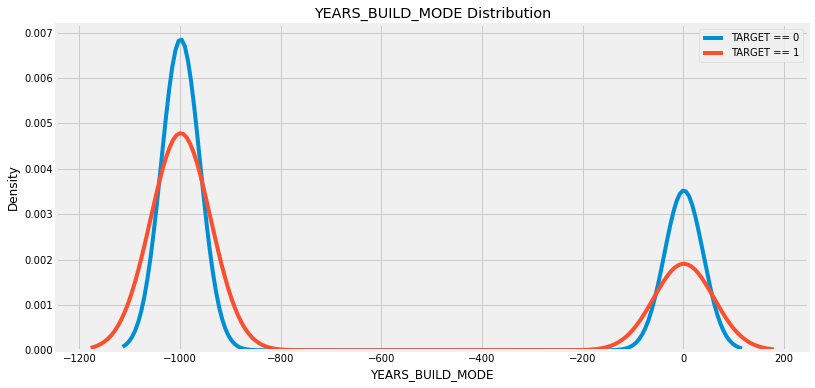

In [1334]:
## 特徴量の分布
kde_target('YEARS_BUILD_MODE', app_train)

In [1335]:
## Yao-Johnson変換
num_cols = ['YEARS_BUILD_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BUILD_MODE'] = pt.transform(app_train[num_cols])
app_test['YEARS_BUILD_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BUILD_MODE']].corr()

TARGET  YEARS_BUILD_MODE
TARGET            1.000000         -0.031529
YEARS_BUILD_MODE -0.031529          1.000000

In [1336]:
## 標準化
num_cols = ['YEARS_BUILD_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['YEARS_BUILD_MODE', 'TARGET']].corr()

YEARS_BUILD_MODE    TARGET
YEARS_BUILD_MODE          1.000000 -0.031529
TARGET                   -0.031529  1.000000

The correlation between YEARS_BUILD_MODE and the TARGET is -0.0315
Median value for loan that was not repaid = -0.7098
Median value for loan that was repaid =     -0.7098


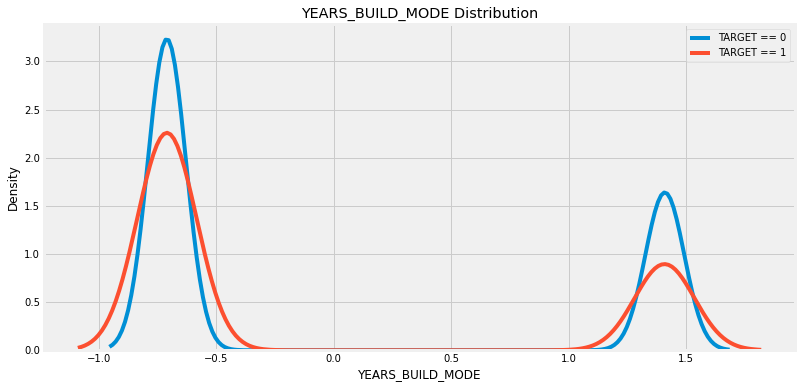

In [1337]:
## Yao-Johnson変換後の特徴量の分布
kde_target('YEARS_BUILD_MODE', app_train)

### COMMONAREA_MODE

In [1338]:
### Originから切り戻し
app_train['COMMONAREA_MODE'] = app_train_origin['COMMONAREA_MODE'].copy()
app_test['COMMONAREA_MODE'] = app_test_origin['COMMONAREA_MODE'].copy()
app_train['COMMONAREA_MODE'].isnull().sum()

214865

In [1339]:
app_train['COMMONAREA_MODE'].isnull().sum()

214865

In [1340]:
app_train['COMMONAREA_MODE'].value_counts()

0.0000    9690
0.0080     546
0.0079     543
0.0078     518
0.0081     416
          ... 
0.2154       1
0.2090       1
0.2568       1
0.2995       1
0.1635       1
Name: COMMONAREA_MODE, Length: 3128, dtype: int64

In [1341]:
app_train[['COMMONAREA_MODE', 'TARGET']].corr()

COMMONAREA_MODE   TARGET
COMMONAREA_MODE          1.00000 -0.01634
TARGET                  -0.01634  1.00000

In [1342]:
### -999埋めで欠損値補完
app_train['COMMONAREA_MODE'] = app_train['COMMONAREA_MODE'].fillna(-999)
app_test['COMMONAREA_MODE'] = app_test['COMMONAREA_MODE'].fillna(-999)
app_train['COMMONAREA_MODE'].isnull().sum()

0

In [1343]:
app_train[['COMMONAREA_MODE', 'TARGET']].corr()

COMMONAREA_MODE    TARGET
COMMONAREA_MODE         1.000000 -0.028027
TARGET                 -0.028027  1.000000

The correlation between COMMONAREA_MODE and the TARGET is -0.0280
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


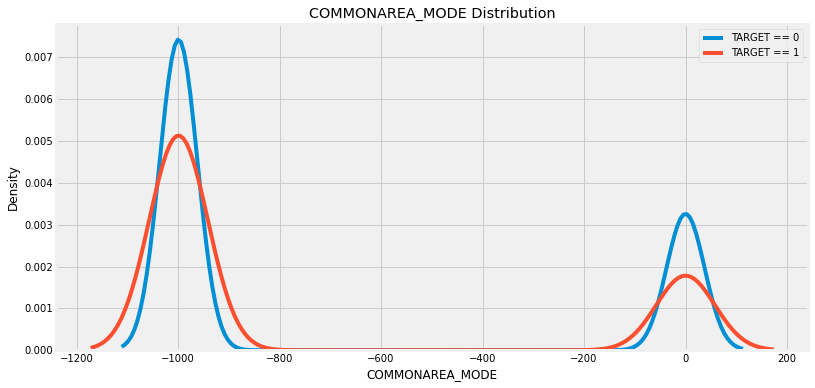

In [1344]:
## 特徴量の分布
kde_target('COMMONAREA_MODE', app_train)

In [1345]:
## Yao-Johnson変換
num_cols = ['COMMONAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['COMMONAREA_MODE'] = pt.transform(app_train[num_cols])
app_test['COMMONAREA_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'COMMONAREA_MODE']].corr()

TARGET  COMMONAREA_MODE
TARGET           1.00000         -0.02805
COMMONAREA_MODE -0.02805          1.00000

In [1346]:
## 標準化
num_cols = ['COMMONAREA_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['COMMONAREA_MODE', 'TARGET']].corr()

COMMONAREA_MODE   TARGET
COMMONAREA_MODE          1.00000 -0.02805
TARGET                  -0.02805  1.00000

The correlation between COMMONAREA_MODE and the TARGET is -0.0281
Median value for loan that was not repaid = -0.6566
Median value for loan that was repaid =     -0.6566


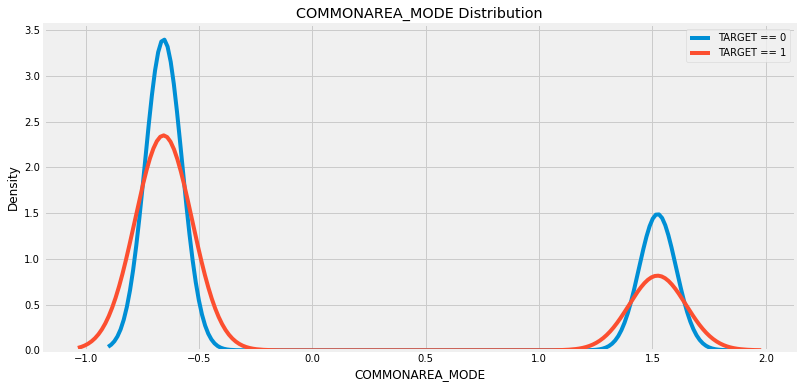

In [1347]:
## Yao-Johnson変換後の特徴量の分布
kde_target('COMMONAREA_MODE', app_train)

### ELEVATORS_MODE

In [1348]:
### Originから切り戻し
app_train['ELEVATORS_MODE'] = app_train_origin['ELEVATORS_MODE'].copy()
app_test['ELEVATORS_MODE'] = app_test_origin['ELEVATORS_MODE'].copy()
app_train['ELEVATORS_MODE'].isnull().sum()

163891

In [1349]:
app_train['ELEVATORS_MODE'].isnull().sum()

163891

In [1350]:
app_train['ELEVATORS_MODE'].value_counts()

0.0000    89498
0.0806    11629
0.1611     9675
0.2417     6379
0.1208     5734
0.0403     4876
0.2014     3962
0.3222     2887
0.2820     2135
0.4028     1554
0.3625     1308
0.4834     1094
0.4431      628
0.5639      491
0.6445      447
0.5236      253
0.6042      226
0.7250      219
1.0000      144
0.8056      137
0.6848       99
0.9667       87
0.8862       66
0.7653       38
0.8459       34
0.9264       20
Name: ELEVATORS_MODE, dtype: int64

In [1351]:
app_train[['ELEVATORS_MODE', 'TARGET']].corr()

ELEVATORS_MODE    TARGET
ELEVATORS_MODE        1.000000 -0.032131
TARGET               -0.032131  1.000000

In [1352]:
### -999埋めで欠損値補完
app_train['ELEVATORS_MODE'] = app_train['ELEVATORS_MODE'].fillna(-999)
app_test['ELEVATORS_MODE'] = app_test['ELEVATORS_MODE'].fillna(-999)
app_train['ELEVATORS_MODE'].isnull().sum()

0

In [1353]:
app_train[['ELEVATORS_MODE', 'TARGET']].corr()

ELEVATORS_MODE    TARGET
ELEVATORS_MODE        1.000000 -0.040302
TARGET               -0.040302  1.000000

The correlation between ELEVATORS_MODE and the TARGET is -0.0403
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


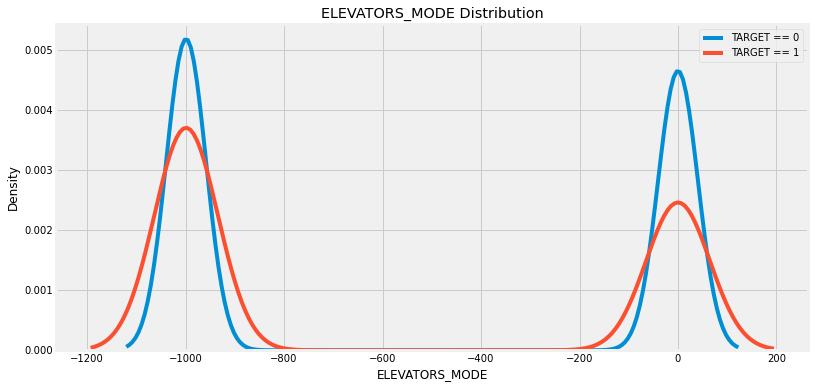

In [1354]:
## 特徴量の分布
kde_target('ELEVATORS_MODE', app_train)

In [1355]:
## Yao-Johnson変換
num_cols = ['ELEVATORS_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ELEVATORS_MODE'] = pt.transform(app_train[num_cols])
app_test['ELEVATORS_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ELEVATORS_MODE']].corr()

TARGET  ELEVATORS_MODE
TARGET          1.000000       -0.040787
ELEVATORS_MODE -0.040787        1.000000

In [1356]:
## 標準化
num_cols = ['ELEVATORS_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['ELEVATORS_MODE', 'TARGET']].corr()

ELEVATORS_MODE    TARGET
ELEVATORS_MODE        1.000000 -0.040787
TARGET               -0.040787  1.000000

The correlation between ELEVATORS_MODE and the TARGET is -0.0408
Median value for loan that was not repaid = -0.9358
Median value for loan that was repaid =     -0.9358


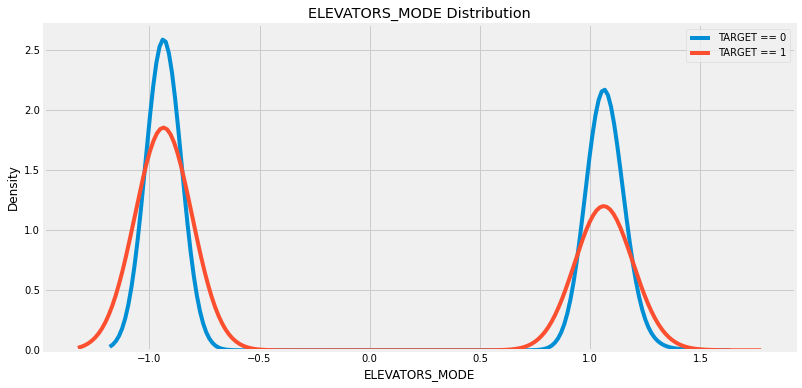

In [1357]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ELEVATORS_MODE', app_train)

### ENTRANCES_MODE

In [1358]:
### Originから切り戻し
app_train['ENTRANCES_MODE'] = app_train_origin['ENTRANCES_MODE'].copy()
app_test['ENTRANCES_MODE'] = app_test_origin['ENTRANCES_MODE'].copy()
app_train['ENTRANCES_MODE'].isnull().sum()

154828

In [1359]:
app_train['ENTRANCES_MODE'].isnull().sum()

154828

In [1360]:
app_train['ENTRANCES_MODE'].value_counts()

0.1379    36041
0.0690    26704
0.1034    20533
0.2069    19678
0.0345    19428
0.1724     8986
0.2759     8036
0.2414     4013
0.3448     2046
0.3103     2014
0.4138     1212
0.3793      977
0.4828      500
0.4483      431
0.0000      387
0.5517      351
0.5172      301
0.6207      241
0.5862      186
1.0000      152
0.6897      116
0.6552       65
0.8966       52
0.7586       48
0.7241       44
0.8276       42
0.7931       39
0.9655       25
0.9310       21
0.8621       14
Name: ENTRANCES_MODE, dtype: int64

In [1361]:
app_train[['ENTRANCES_MODE', 'TARGET']].corr()

ENTRANCES_MODE    TARGET
ENTRANCES_MODE        1.000000 -0.017387
TARGET               -0.017387  1.000000

In [1362]:
### -999埋めで欠損値補完
app_train['ENTRANCES_MODE'] = app_train['ENTRANCES_MODE'].fillna(-999)
app_test['ENTRANCES_MODE'] = app_test['ENTRANCES_MODE'].fillna(-999)
app_train['ENTRANCES_MODE'].isnull().sum()

0

In [1363]:
app_train[['ENTRANCES_MODE', 'TARGET']].corr()

ENTRANCES_MODE    TARGET
ENTRANCES_MODE        1.000000 -0.040874
TARGET               -0.040874  1.000000

The correlation between ENTRANCES_MODE and the TARGET is -0.0409
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     0.0345


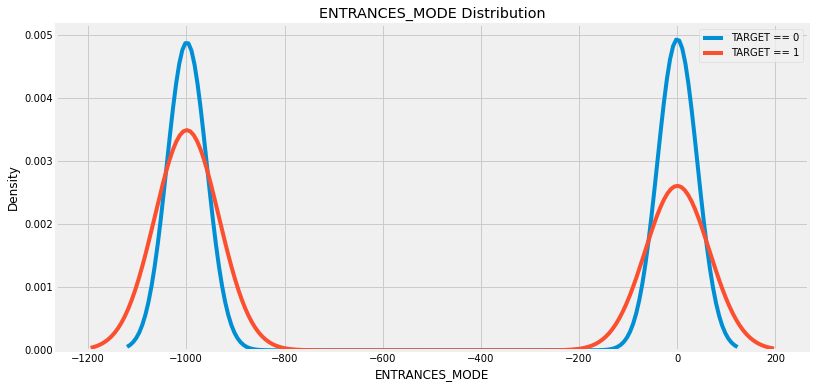

In [1364]:
## 特徴量の分布
kde_target('ENTRANCES_MODE', app_train)

In [1365]:
## Yao-Johnson変換
num_cols = ['ENTRANCES_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ENTRANCES_MODE'] = pt.transform(app_train[num_cols])
app_test['ENTRANCES_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ENTRANCES_MODE']].corr()

TARGET  ENTRANCES_MODE
TARGET          1.00000        -0.04112
ENTRANCES_MODE -0.04112         1.00000

In [1366]:
## 標準化
num_cols = ['ENTRANCES_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['ENTRANCES_MODE', 'TARGET']].corr()

ENTRANCES_MODE   TARGET
ENTRANCES_MODE         1.00000 -0.04112
TARGET                -0.04112  1.00000

The correlation between ENTRANCES_MODE and the TARGET is -0.0411
Median value for loan that was not repaid = -0.9927
Median value for loan that was repaid =     0.9724


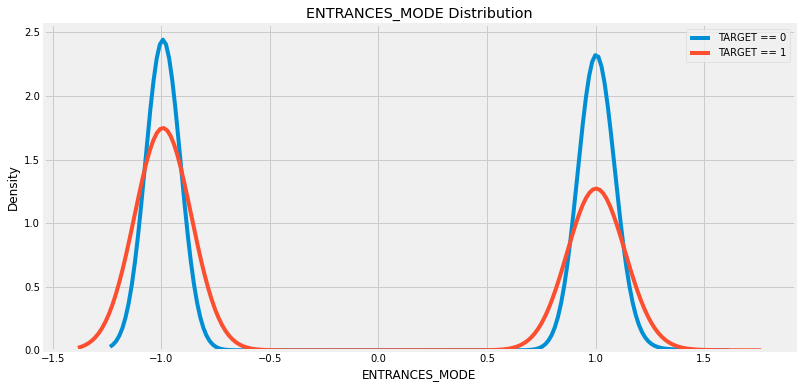

In [1367]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ENTRANCES_MODE', app_train)

### FLOORSMAX_MODE

In [1368]:
### Originから切り戻し
app_train['FLOORSMAX_MODE'] = app_train_origin['FLOORSMAX_MODE'].copy()
app_test['FLOORSMAX_MODE'] = app_test_origin['FLOORSMAX_MODE'].copy()
app_train['FLOORSMAX_MODE'].isnull().sum()

153020

In [1369]:
app_train['FLOORSMAX_MODE'].isnull().sum()

153020

In [1370]:
app_train['FLOORSMAX_MODE'].value_counts()

0.1667    65550
0.3333    34373
0.0417    15616
0.3750     8321
0.1250     7267
0.0833     6785
0.0000     3415
0.4583     3216
0.6250     2075
0.5417     1836
0.6667     1710
0.2083     1505
0.2500      572
0.2917      511
0.5833      391
0.4167      236
0.8750      229
0.7083      199
0.5000      184
1.0000      164
0.7500      124
0.9583       94
0.7917       58
0.9167       38
0.8333       22
Name: FLOORSMAX_MODE, dtype: int64

In [1371]:
app_train[['FLOORSMAX_MODE', 'TARGET']].corr()

FLOORSMAX_MODE    TARGET
FLOORSMAX_MODE        1.000000 -0.043226
TARGET               -0.043226  1.000000

In [1372]:
### 0埋めで欠損値補完
app_train['FLOORSMAX_MODE'] = app_train['FLOORSMAX_MODE'].fillna(0)
app_test['FLOORSMAX_MODE'] = app_test['FLOORSMAX_MODE'].fillna(0)
app_train['FLOORSMAX_MODE'].isnull().sum()

0

In [1373]:
app_train[['FLOORSMAX_MODE', 'TARGET']].corr()

FLOORSMAX_MODE    TARGET
FLOORSMAX_MODE        1.000000 -0.049458
TARGET               -0.049458  1.000000

The correlation between FLOORSMAX_MODE and the TARGET is -0.0495
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


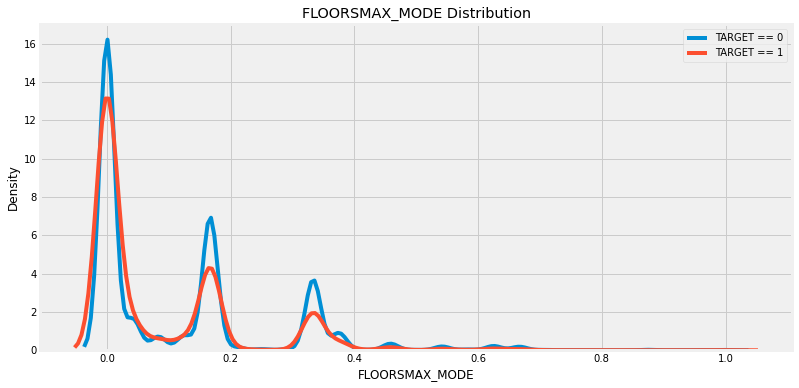

In [1374]:
## 特徴量の分布
kde_target('FLOORSMAX_MODE', app_train)

In [1375]:
## Yao-Johnson変換
num_cols = ['FLOORSMAX_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['FLOORSMAX_MODE'] = pt.transform(app_train[num_cols])
app_test['FLOORSMAX_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'FLOORSMAX_MODE']].corr()

TARGET  FLOORSMAX_MODE
TARGET          1.000000       -0.049823
FLOORSMAX_MODE -0.049823        1.000000

In [1376]:
## 標準化
num_cols = ['FLOORSMAX_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['FLOORSMAX_MODE', 'TARGET']].corr()

FLOORSMAX_MODE    TARGET
FLOORSMAX_MODE        1.000000 -0.049823
TARGET               -0.049823  1.000000

The correlation between FLOORSMAX_MODE and the TARGET is -0.0498
Median value for loan that was not repaid = -0.9004
Median value for loan that was repaid =     -0.9004


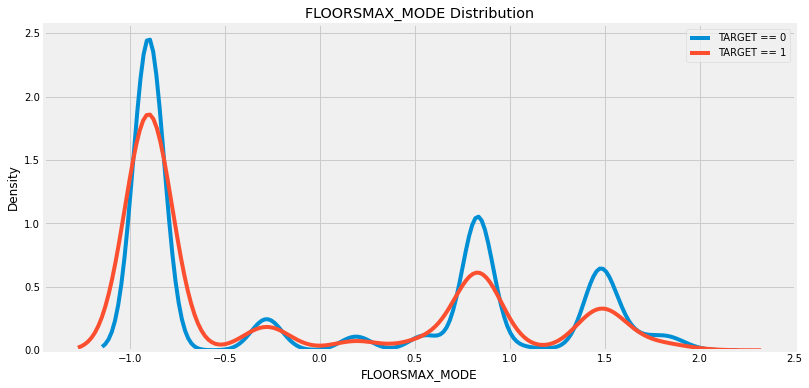

In [1377]:
## Yao-Johnson変換後の特徴量の分布
kde_target('FLOORSMAX_MODE', app_train)

### FLOORSMIN_MODE

In [1378]:
### Originから切り戻し
app_train['LANDAREA_MODE'] = app_train_origin['LANDAREA_MODE'].copy()
app_test['LANDAREA_MODE'] = app_test_origin['LANDAREA_MODE'].copy()
app_train['LANDAREA_MODE'].isnull().sum()

182590

In [1379]:
app_train['LANDAREA_MODE'].isnull().sum()

182590

In [1380]:
app_train['LANDAREA_MODE'].value_counts()

0.0000    17453
0.0194      208
0.0645      193
0.0484      192
0.0323      188
          ...  
0.2428        1
0.4716        1
0.6044        1
0.3757        1
0.2723        1
Name: LANDAREA_MODE, Length: 3563, dtype: int64

In [1381]:
app_train[['LANDAREA_MODE', 'TARGET']].corr()

LANDAREA_MODE    TARGET
LANDAREA_MODE       1.000000 -0.010174
TARGET             -0.010174  1.000000

In [1382]:
### -999埋めで欠損値補完
app_train['LANDAREA_MODE'] = app_train['LANDAREA_MODE'].fillna(-999)
app_test['LANDAREA_MODE'] = app_test['LANDAREA_MODE'].fillna(-999)
app_train['LANDAREA_MODE'].isnull().sum()

0

In [1383]:
app_train[['LANDAREA_MODE', 'TARGET']].corr()

LANDAREA_MODE    TARGET
LANDAREA_MODE       1.000000 -0.033147
TARGET             -0.033147  1.000000

The correlation between LANDAREA_MODE and the TARGET is -0.0331
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


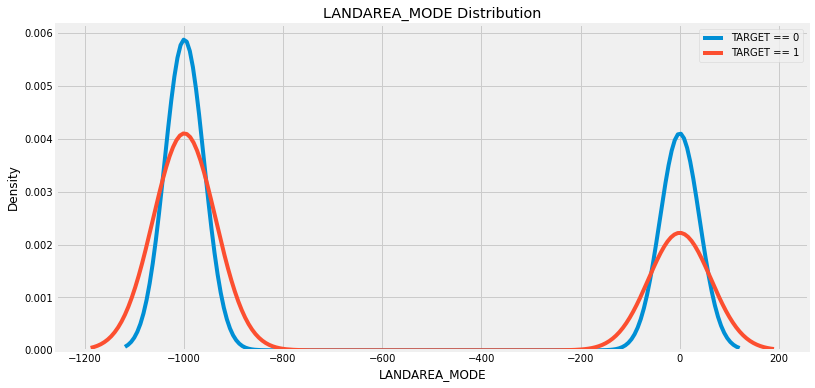

In [1384]:
## 特徴量の分布
kde_target('LANDAREA_MODE', app_train)

In [1385]:
## Yao-Johnson変換
num_cols = ['LANDAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LANDAREA_MODE'] = pt.transform(app_train[num_cols])
app_test['LANDAREA_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LANDAREA_MODE']].corr()

TARGET  LANDAREA_MODE
TARGET         1.000000      -0.033198
LANDAREA_MODE -0.033198       1.000000

In [1386]:
## 標準化
num_cols = ['LANDAREA_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['LANDAREA_MODE', 'TARGET']].corr()

LANDAREA_MODE    TARGET
LANDAREA_MODE       1.000000 -0.033198
TARGET             -0.033198  1.000000

The correlation between LANDAREA_MODE and the TARGET is -0.0332
Median value for loan that was not repaid = -0.8271
Median value for loan that was repaid =     -0.8271


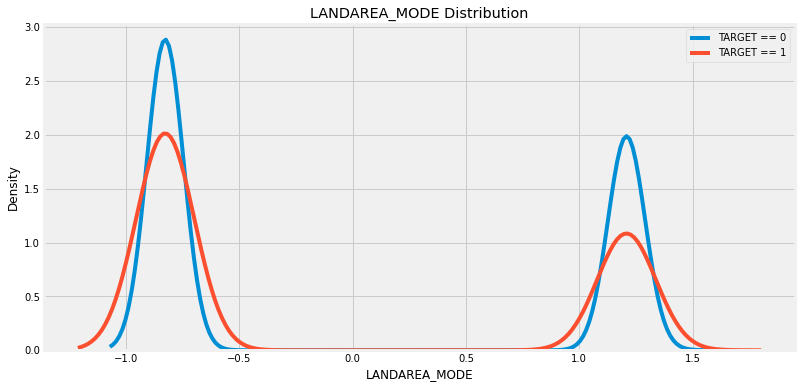

In [1387]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LANDAREA_MODE', app_train)

### LIVINGAPARTMENTS_MODE

In [1388]:
### Originから切り戻し
app_train['LANDAREA_MODE'] = app_train_origin['LANDAREA_MODE'].copy()
app_test['LANDAREA_MODE'] = app_test_origin['LANDAREA_MODE'].copy()
app_train['LANDAREA_MODE'].isnull().sum()

182590

In [1389]:
app_train['LANDAREA_MODE'].isnull().sum()

182590

In [1390]:
app_train['LIVINGAPARTMENTS_MODE'].value_counts()

-0.639447    210718
 1.278239      4931
 1.517218      4797
 1.601372      2966
 1.411074      2853
              ...  
 1.960430         1
 1.960415         1
 1.960397         1
 1.960428         1
 1.960425         1
Name: LIVINGAPARTMENTS_MODE, Length: 736, dtype: int64

In [1391]:
app_train[['LIVINGAPARTMENTS_MODE', 'TARGET']].corr()

LIVINGAPARTMENTS_MODE    TARGET
LIVINGAPARTMENTS_MODE               1.000000 -0.033311
TARGET                             -0.033311  1.000000

In [1392]:
### -999埋めで欠損値補完
app_train['LANDAREA_MODE'] = app_train['LANDAREA_MODE'].fillna(-999)
app_test['LANDAREA_MODE'] = app_test['LANDAREA_MODE'].fillna(-999)
app_train['LANDAREA_MODE'].isnull().sum()

0

In [1393]:
app_train[['LIVINGAPARTMENTS_MODE', 'TARGET']].corr()

LIVINGAPARTMENTS_MODE    TARGET
LIVINGAPARTMENTS_MODE               1.000000 -0.033311
TARGET                             -0.033311  1.000000

The correlation between LIVINGAPARTMENTS_MODE and the TARGET is -0.0333
Median value for loan that was not repaid = -0.6394
Median value for loan that was repaid =     -0.6394


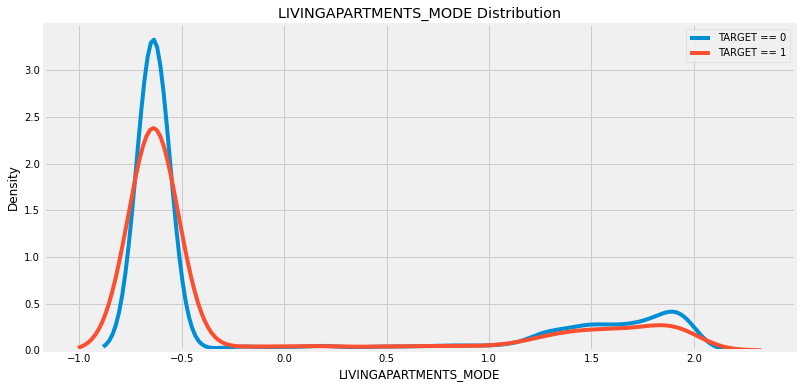

In [1394]:
## 特徴量の分布
kde_target('LIVINGAPARTMENTS_MODE', app_train)

In [1395]:
## Yao-Johnson変換
num_cols = ['LIVINGAPARTMENTS_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAPARTMENTS_MODE'] = pt.transform(app_train[num_cols])
app_test['LIVINGAPARTMENTS_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAPARTMENTS_MODE']].corr()

TARGET  LIVINGAPARTMENTS_MODE
TARGET                 1.000000              -0.031487
LIVINGAPARTMENTS_MODE -0.031487               1.000000

In [1396]:
## 標準化
num_cols = ['LANDAREA_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['LANDAREA_MODE', 'TARGET']].corr()

LANDAREA_MODE    TARGET
LANDAREA_MODE       1.000000 -0.033147
TARGET             -0.033147  1.000000

The correlation between LANDAREA_MODE and the TARGET is -0.0331
Median value for loan that was not repaid = -0.8271
Median value for loan that was repaid =     -0.8271


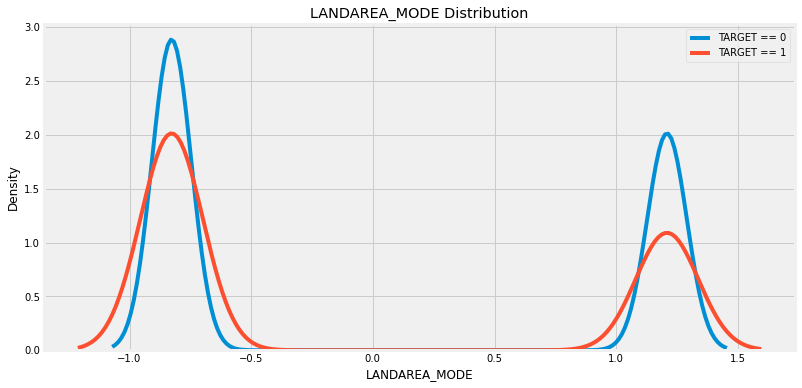

In [1397]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LANDAREA_MODE', app_train)

### LIVINGAREA_MODE

In [1398]:
### Originから切り戻し
app_train['LIVINGAREA_MODE'] = app_train_origin['LIVINGAREA_MODE'].copy()
app_test['LIVINGAREA_MODE'] = app_test_origin['LIVINGAREA_MODE'].copy()
app_train['LIVINGAREA_MODE'].isnull().sum()

154350

In [1399]:
app_train['LIVINGAREA_MODE'].isnull().sum()

154350

In [1400]:
app_train['LIVINGAREA_MODE'].value_counts()

0.0000    444
0.0530    272
0.0532    262
0.0529    249
0.0533    242
         ... 
0.3526      1
0.7223      1
0.4394      1
0.7364      1
0.9667      1
Name: LIVINGAREA_MODE, Length: 5301, dtype: int64

In [1401]:
app_train[['LIVINGAREA_MODE', 'TARGET']].corr()

LIVINGAREA_MODE    TARGET
LIVINGAREA_MODE         1.000000 -0.030685
TARGET                 -0.030685  1.000000

In [1402]:
### -999埋めで欠損値補完
app_train['LIVINGAREA_MODE'] = app_train['LIVINGAREA_MODE'].fillna(-999)
app_test['LIVINGAREA_MODE'] = app_test['LIVINGAREA_MODE'].fillna(-999)
app_train['LIVINGAREA_MODE'].isnull().sum()

0

In [1403]:
app_train[['LIVINGAREA_MODE', 'TARGET']].corr()

LIVINGAREA_MODE    TARGET
LIVINGAREA_MODE         1.000000 -0.039408
TARGET                 -0.039408  1.000000

The correlation between LIVINGAREA_MODE and the TARGET is -0.0394
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     0.0016


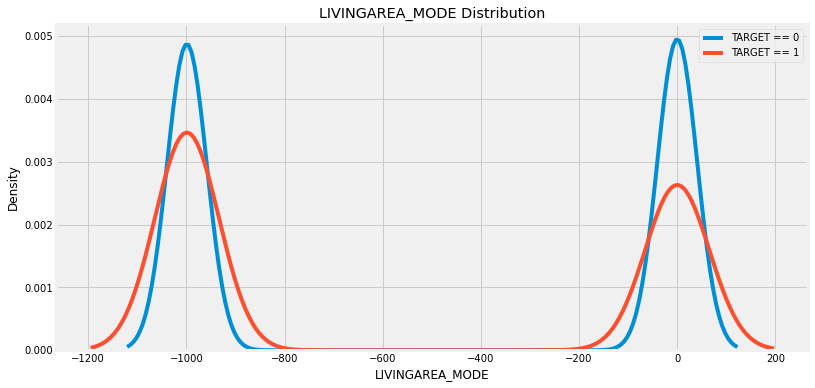

In [1404]:
## 特徴量の分布
kde_target('LIVINGAREA_MODE', app_train)

In [1405]:
## Yao-Johnson変換
num_cols = ['LIVINGAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAREA_MODE'] = pt.transform(app_train[num_cols])
app_test['LIVINGAREA_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAREA_MODE']].corr()

TARGET  LIVINGAREA_MODE
TARGET           1.000000        -0.039915
LIVINGAREA_MODE -0.039915         1.000000

In [1406]:
## 標準化
num_cols = ['LIVINGAREA_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['LIVINGAREA_MODE', 'TARGET']].corr()

LIVINGAREA_MODE    TARGET
LIVINGAREA_MODE         1.000000 -0.039915
TARGET                 -0.039915  1.000000

The correlation between LIVINGAREA_MODE and the TARGET is -0.0399
Median value for loan that was not repaid = -0.9958
Median value for loan that was repaid =     0.9712


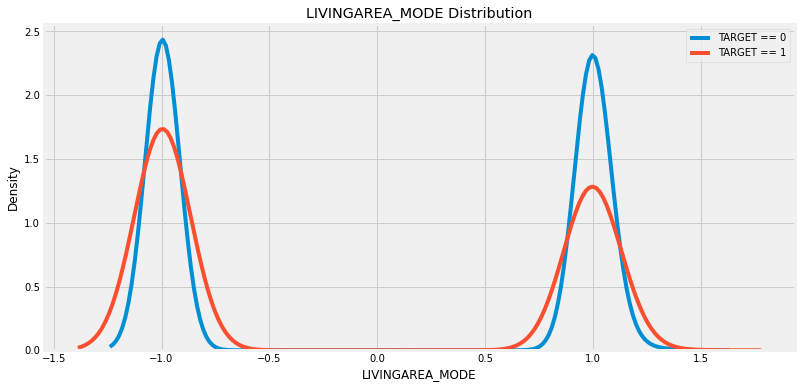

In [1407]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAREA_MODE', app_train)

### NONLIVINGAPARTMENTS_MODE

In [1408]:
### Originから切り戻し
app_train['NONLIVINGAPARTMENTS_MODE'] = app_train_origin['NONLIVINGAPARTMENTS_MODE'].copy()
app_test['NONLIVINGAPARTMENTS_MODE'] = app_test_origin['NONLIVINGAPARTMENTS_MODE'].copy()
app_train['NONLIVINGAPARTMENTS_MODE'].isnull().sum()

213514

In [1409]:
app_train['NONLIVINGAPARTMENTS_MODE'].isnull().sum()

213514

In [1410]:
app_train['NONLIVINGAPARTMENTS_MODE'].value_counts()

0.0000    59255
0.0039    14105
0.0078     6413
0.0117     3675
0.0156     2492
          ...  
0.5953        1
0.7626        1
0.7082        1
0.4708        1
0.6070        1
Name: NONLIVINGAPARTMENTS_MODE, Length: 167, dtype: int64

In [1411]:
app_train[['NONLIVINGAPARTMENTS_MODE', 'TARGET']].corr()

NONLIVINGAPARTMENTS_MODE    TARGET
NONLIVINGAPARTMENTS_MODE                  1.000000 -0.001557
TARGET                                   -0.001557  1.000000

In [1412]:
### -999埋めで欠損値補完
app_train['NONLIVINGAPARTMENTS_MODE'] = app_train['NONLIVINGAPARTMENTS_MODE'].fillna(-999)
app_test['NONLIVINGAPARTMENTS_MODE'] = app_test['NONLIVINGAPARTMENTS_MODE'].fillna(-999)
app_train['NONLIVINGAPARTMENTS_MODE'].isnull().sum()

0

In [1413]:
app_train[['NONLIVINGAPARTMENTS_MODE', 'TARGET']].corr()

NONLIVINGAPARTMENTS_MODE    TARGET
NONLIVINGAPARTMENTS_MODE                  1.000000 -0.028251
TARGET                                   -0.028251  1.000000

The correlation between NONLIVINGAPARTMENTS_MODE and the TARGET is -0.0283
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


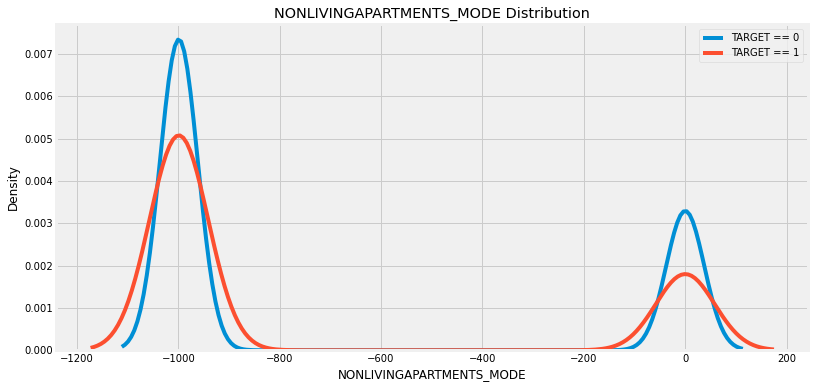

In [1414]:
## 特徴量の分布
kde_target('NONLIVINGAPARTMENTS_MODE', app_train)

In [1415]:
## Yao-Johnson変換
num_cols = ['NONLIVINGAPARTMENTS_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['NONLIVINGAPARTMENTS_MODE'] = pt.transform(app_train[num_cols])
app_test['NONLIVINGAPARTMENTS_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'NONLIVINGAPARTMENTS_MODE']].corr()

TARGET  NONLIVINGAPARTMENTS_MODE
TARGET                    1.000000                 -0.028252
NONLIVINGAPARTMENTS_MODE -0.028252                  1.000000

In [1416]:
## 標準化
num_cols = ['NONLIVINGAPARTMENTS_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['NONLIVINGAPARTMENTS_MODE', 'TARGET']].corr()

NONLIVINGAPARTMENTS_MODE    TARGET
NONLIVINGAPARTMENTS_MODE                  1.000000 -0.028252
TARGET                                   -0.028252  1.000000

The correlation between NONLIVINGAPARTMENTS_MODE and the TARGET is -0.0283
Median value for loan that was not repaid = -0.6635
Median value for loan that was repaid =     -0.6635


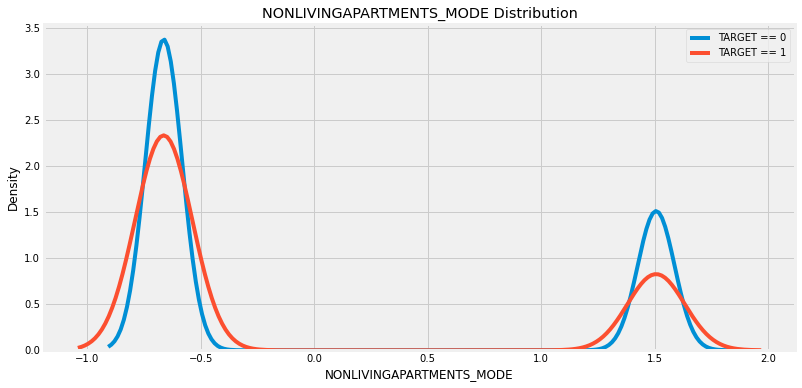

In [1417]:
## Yao-Johnson変換後の特徴量の分布
kde_target('NONLIVINGAPARTMENTS_MODE', app_train)

### NONLIVINGAREA_MODE

In [1418]:
### Originから切り戻し
app_train['NONLIVINGAREA_MODE'] = app_train_origin['NONLIVINGAREA_MODE'].copy()
app_test['NONLIVINGAREA_MODE'] = app_test_origin['NONLIVINGAREA_MODE'].copy()
app_train['NONLIVINGAREA_MODE'].isnull().sum()

169682

In [1419]:
app_train['NONLIVINGAREA_MODE'].isnull().sum()

169682

In [1420]:
app_train['NONLIVINGAREA_MODE'].value_counts()

0.0000    67126
0.0011      477
0.0046      466
0.0033      430
0.0012      427
          ...  
0.1908        1
0.5423        1
0.2705        1
0.2391        1
0.4109        1
Name: NONLIVINGAREA_MODE, Length: 3327, dtype: int64

In [1421]:
app_train[['NONLIVINGAREA_MODE', 'TARGET']].corr()

NONLIVINGAREA_MODE    TARGET
NONLIVINGAREA_MODE            1.000000 -0.012711
TARGET                       -0.012711  1.000000

In [1422]:
### -999埋めで欠損値補完
app_train['NONLIVINGAREA_MODE'] = app_train['NONLIVINGAREA_MODE'].fillna(-999)
app_test['NONLIVINGAREA_MODE'] = app_test['NONLIVINGAREA_MODE'].fillna(-999)
app_train['NONLIVINGAREA_MODE'].isnull().sum()

0

In [1423]:
app_train[['NONLIVINGAREA_MODE', 'TARGET']].corr()

NONLIVINGAREA_MODE    TARGET
NONLIVINGAREA_MODE            1.000000 -0.039169
TARGET                       -0.039169  1.000000

The correlation between NONLIVINGAREA_MODE and the TARGET is -0.0392
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


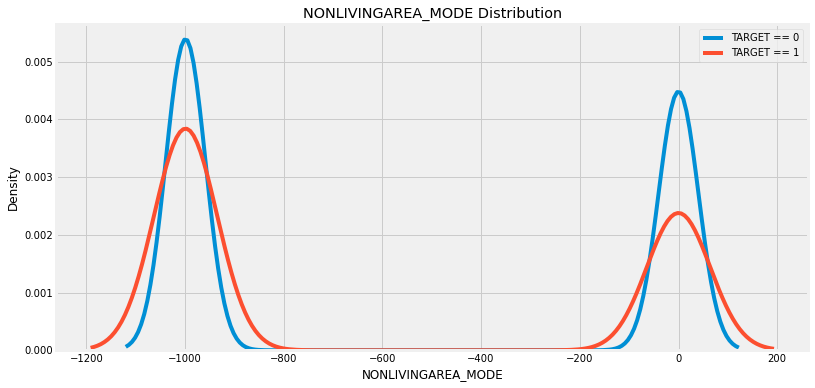

In [1424]:
## 特徴量の分布
kde_target('NONLIVINGAREA_MODE', app_train)

In [1425]:
## Yao-Johnson変換
num_cols = ['NONLIVINGAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['NONLIVINGAREA_MODE'] = pt.transform(app_train[num_cols])
app_test['NONLIVINGAREA_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'NONLIVINGAREA_MODE']].corr()

TARGET  NONLIVINGAREA_MODE
TARGET              1.000000           -0.039255
NONLIVINGAREA_MODE -0.039255            1.000000

In [1426]:
## 標準化
num_cols = ['NONLIVINGAREA_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['NONLIVINGAREA_MODE', 'TARGET']].corr()

NONLIVINGAREA_MODE    TARGET
NONLIVINGAREA_MODE            1.000000 -0.039255
TARGET                       -0.039255  1.000000

The correlation between NONLIVINGAREA_MODE and the TARGET is -0.0393
Median value for loan that was not repaid = -0.9012
Median value for loan that was repaid =     -0.9012


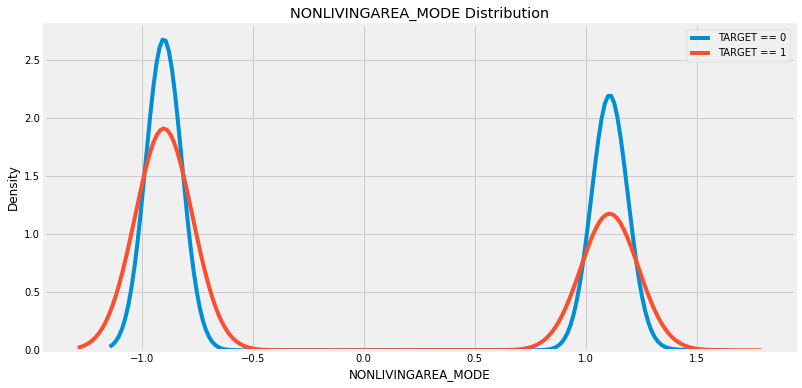

In [1427]:
## Yao-Johnson変換後の特徴量の分布
kde_target('NONLIVINGAREA_MODE', app_train)

### APARTMENTS_MEDI

In [1428]:
### Originから切り戻し
app_train['APARTMENTS_MEDI'] = app_train_origin['APARTMENTS_MEDI'].copy()
app_test['APARTMENTS_MEDI'] = app_test_origin['APARTMENTS_MEDI'].copy()
app_train['APARTMENTS_MEDI'].isnull().sum()

156061

In [1429]:
app_train['APARTMENTS_MEDI'].value_counts()

0.0833    7109
0.0625    6687
0.0937    4622
0.0729    4211
0.0083    3562
          ... 
0.6225       1
0.7724       1
0.7234       1
0.8889       1
0.3024       1
Name: APARTMENTS_MEDI, Length: 1148, dtype: int64

In [1430]:
app_train[['BASEMENTAREA_MEDI', 'TARGET']].corr()

BASEMENTAREA_MEDI    TARGET
BASEMENTAREA_MEDI           1.000000 -0.022081
TARGET                     -0.022081  1.000000

In [1431]:
### -999埋めで欠損値補完
app_train['APARTMENTS_MEDI'] = app_train['APARTMENTS_MEDI'].fillna(-999)
app_test['APARTMENTS_MEDI'] = app_test['APARTMENTS_MEDI'].fillna(-999)
app_train['APARTMENTS_MEDI'].isnull().sum()

0

In [1432]:
app_train[['BASEMENTAREA_MEDI', 'TARGET']].corr()

BASEMENTAREA_MEDI    TARGET
BASEMENTAREA_MEDI           1.000000 -0.022081
TARGET                     -0.022081  1.000000

The correlation between BASEMENTAREA_MEDI and the TARGET is -0.0221
Median value for loan that was not repaid = 0.0718
Median value for loan that was repaid =     0.0761


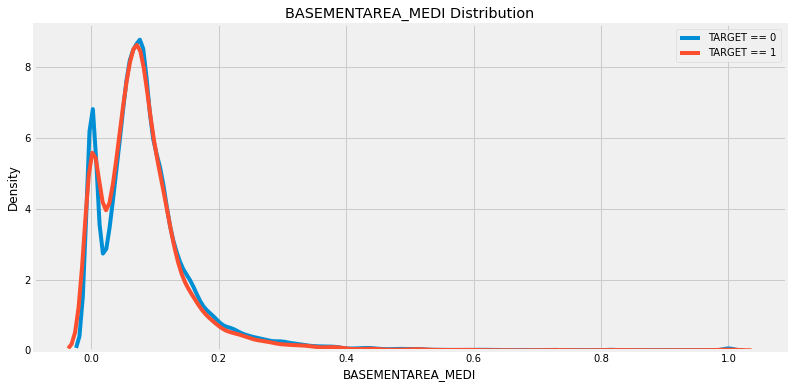

In [1433]:
## 特徴量の分布
kde_target('BASEMENTAREA_MEDI', app_train)

In [1434]:
## Yao-Johnson変換
num_cols = ['BASEMENTAREA_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['BASEMENTAREA_MEDI'] = pt.transform(app_train[num_cols])
app_test['BASEMENTAREA_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'BASEMENTAREA_MEDI']].corr()

TARGET  BASEMENTAREA_MEDI
TARGET             1.000000          -0.023256
BASEMENTAREA_MEDI -0.023256           1.000000

In [1435]:
## 標準化
num_cols = ['APARTMENTS_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['APARTMENTS_MEDI', 'TARGET']].corr()

APARTMENTS_MEDI    TARGET
APARTMENTS_MEDI         1.000000 -0.040269
TARGET                 -0.040269  1.000000

The correlation between BASEMENTAREA_MEDI and the TARGET is -0.0233
Median value for loan that was not repaid = -0.0131
Median value for loan that was repaid =     0.0632


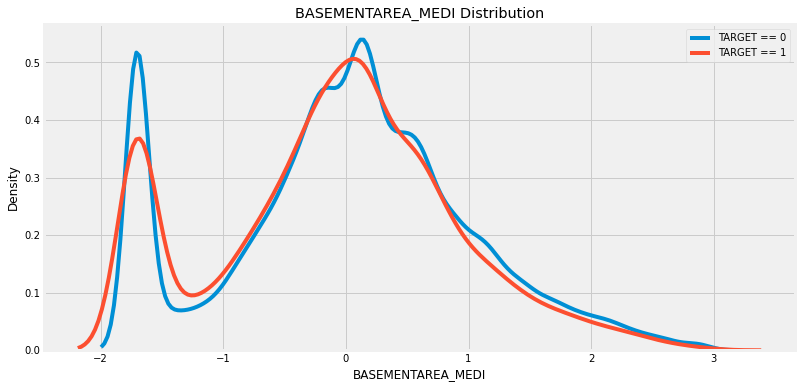

In [1436]:
## Yao-Johnson変換後の特徴量の分布
kde_target('BASEMENTAREA_MEDI', app_train)

### YEARS_BEGINEXPLUATATION_MEDI

In [1437]:
### Originから切り戻し
app_train['YEARS_BEGINEXPLUATATION_MEDI'] = app_train_origin['YEARS_BEGINEXPLUATATION_MEDI'].copy()
app_test['YEARS_BEGINEXPLUATATION_MEDI'] = app_test_origin['YEARS_BEGINEXPLUATATION_MEDI'].copy()
app_train['YEARS_BEGINEXPLUATATION_MEDI'].isnull().sum()

150007

In [1438]:
app_train['YEARS_BEGINEXPLUATATION_MEDI'].value_counts()

0.9871    4314
0.9861    4247
0.9856    4199
0.9866    4138
0.9801    4115
          ... 
0.9076       1
0.5315       1
0.4938       1
0.9056       1
0.8629       1
Name: YEARS_BEGINEXPLUATATION_MEDI, Length: 245, dtype: int64

In [1439]:
app_train[['YEARS_BEGINEXPLUATATION_MEDI', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_MEDI    TARGET
YEARS_BEGINEXPLUATATION_MEDI                      1.000000 -0.009993
TARGET                                           -0.009993  1.000000

In [1440]:
### -999埋めで欠損値補完
app_train['YEARS_BEGINEXPLUATATION_MEDI'] = app_train['YEARS_BEGINEXPLUATATION_MEDI'].fillna(-999)
app_test['YEARS_BEGINEXPLUATATION_MEDI'] = app_test['YEARS_BEGINEXPLUATATION_MEDI'].fillna(-999)
app_train['YEARS_BEGINEXPLUATATION_MEDI'].isnull().sum()

0

In [1441]:
app_train[['YEARS_BEGINEXPLUATATION_MEDI', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_MEDI    TARGET
YEARS_BEGINEXPLUATATION_MEDI                      1.000000 -0.040554
TARGET                                           -0.040554  1.000000

The correlation between YEARS_BEGINEXPLUATATION_MEDI and the TARGET is -0.0406
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     0.9642


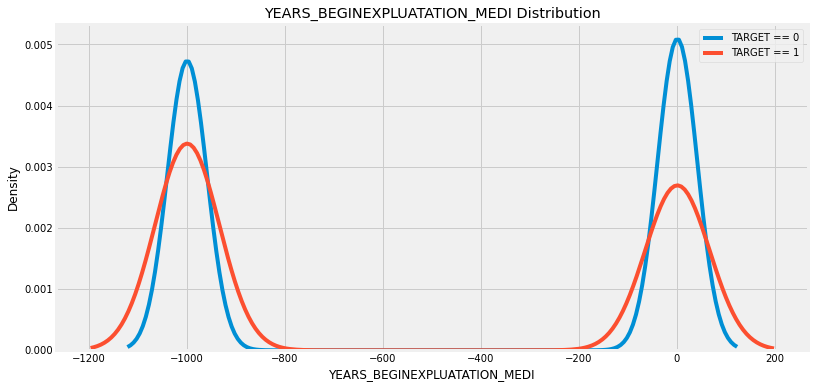

In [1442]:
## 特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_MEDI', app_train)

In [1443]:
## Yao-Johnson変換
num_cols = ['YEARS_BEGINEXPLUATATION_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BEGINEXPLUATATION_MEDI'] = pt.transform(app_train[num_cols])
app_test['YEARS_BEGINEXPLUATATION_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BEGINEXPLUATATION_MEDI']].corr()

TARGET  YEARS_BEGINEXPLUATATION_MEDI
TARGET                        1.000000                     -0.040648
YEARS_BEGINEXPLUATATION_MEDI -0.040648                      1.000000

In [1444]:
## 標準化
num_cols = ['YEARS_BEGINEXPLUATATION_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['YEARS_BEGINEXPLUATATION_MEDI', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_MEDI    TARGET
YEARS_BEGINEXPLUATATION_MEDI                      1.000000 -0.040648
TARGET                                           -0.040648  1.000000

The correlation between YEARS_BEGINEXPLUATATION_MEDI and the TARGET is -0.0406
Median value for loan that was not repaid = -1.0246
Median value for loan that was repaid =     0.9700


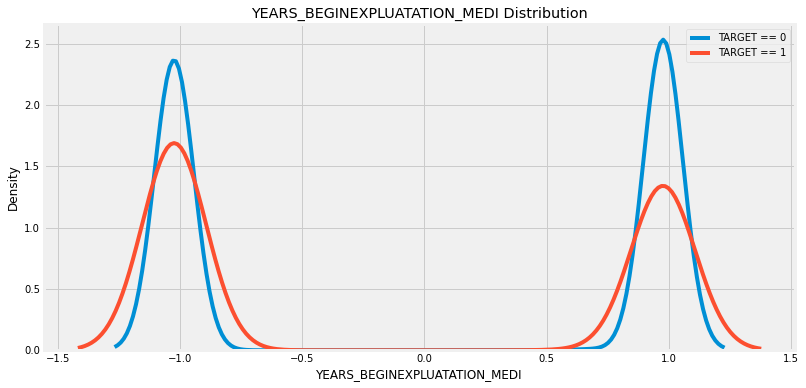

In [1445]:
## Yao-Johnson変換後の特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_MEDI', app_train)

### YEARS_BUILD_MEDI

In [1446]:
### Originから切り戻し
app_train['YEARS_BUILD_MEDI'] = app_train_origin['YEARS_BUILD_MEDI'].copy()
app_test['YEARS_BUILD_MEDI'] = app_test_origin['YEARS_BUILD_MEDI'].copy()
app_train['YEARS_BUILD_MEDI'].isnull().sum()

204488

In [1447]:
app_train['YEARS_BUILD_MEDI'].value_counts()

0.8256    2994
0.8189    2883
0.8054    2842
0.7316    2799
0.8121    2784
          ... 
0.0607       2
0.3828       2
0.0406       1
0.0339       1
0.0071       1
Name: YEARS_BUILD_MEDI, Length: 151, dtype: int64

In [1448]:
app_train[['YEARS_BUILD_MEDI', 'TARGET']].corr()

YEARS_BUILD_MEDI    TARGET
YEARS_BUILD_MEDI          1.000000 -0.022326
TARGET                   -0.022326  1.000000

In [1449]:
### -999埋めで欠損値補完
app_train['YEARS_BUILD_MEDI'] = app_train['YEARS_BUILD_MEDI'].fillna(-999)
app_test['YEARS_BUILD_MEDI'] = app_test['YEARS_BUILD_MEDI'].fillna(-999)
app_train['YEARS_BUILD_MEDI'].isnull().sum()

0

In [1450]:
app_train[['YEARS_BUILD_MEDI', 'TARGET']].corr()

YEARS_BUILD_MEDI    TARGET
YEARS_BUILD_MEDI          1.000000 -0.031436
TARGET                   -0.031436  1.000000

The correlation between YEARS_BUILD_MEDI and the TARGET is -0.0314
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


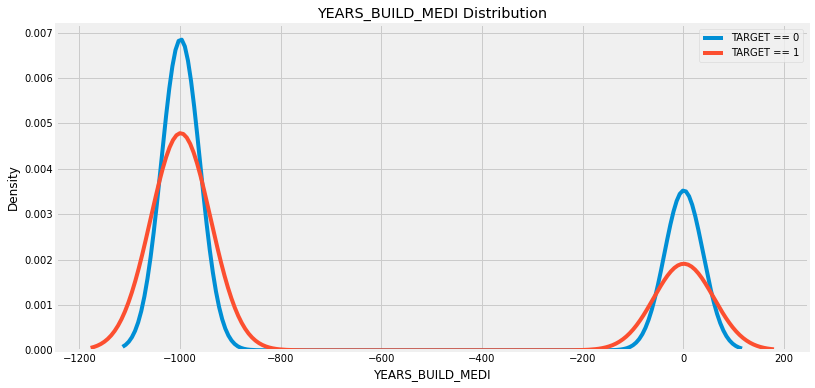

In [1451]:
## 特徴量の分布
kde_target('YEARS_BUILD_MEDI', app_train)

In [1452]:
## Yao-Johnson変換
num_cols = ['YEARS_BUILD_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BUILD_MEDI'] = pt.transform(app_train[num_cols])
app_test['YEARS_BUILD_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BUILD_MEDI']].corr()

TARGET  YEARS_BUILD_MEDI
TARGET            1.000000         -0.031532
YEARS_BUILD_MEDI -0.031532          1.000000

In [1453]:
## 標準化
num_cols = ['YEARS_BUILD_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['YEARS_BUILD_MEDI', 'TARGET']].corr()

YEARS_BUILD_MEDI    TARGET
YEARS_BUILD_MEDI          1.000000 -0.031532
TARGET                   -0.031532  1.000000

The correlation between YEARS_BUILD_MEDI and the TARGET is -0.0315
Median value for loan that was not repaid = -0.7098
Median value for loan that was repaid =     -0.7098


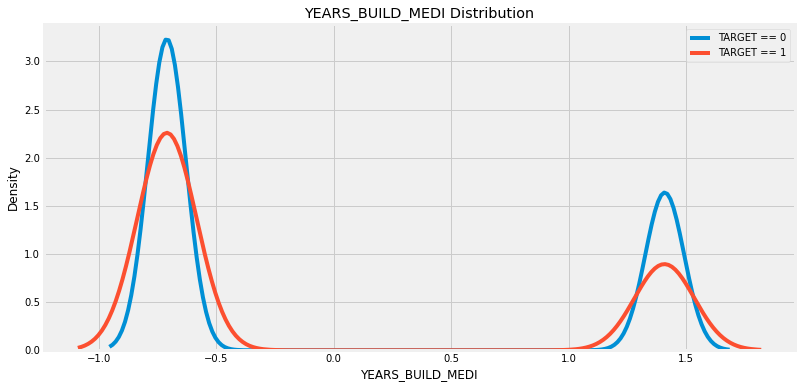

In [1454]:
## Yao-Johnson変換後の特徴量の分布
kde_target('YEARS_BUILD_MEDI', app_train)

### COMMONAREA_MEDI

In [1455]:
### Originから切り戻し
app_train['COMMONAREA_MEDI'] = app_train_origin['COMMONAREA_MEDI'].copy()
app_test['COMMONAREA_MEDI'] = app_test_origin['COMMONAREA_MEDI'].copy()
app_train['COMMONAREA_MEDI'].isnull().sum()

214865

In [1456]:
app_train['COMMONAREA_MEDI'].value_counts()

0.0000    8691
0.0079     581
0.0080     486
0.0078     481
0.0014     377
          ... 
0.6284       1
0.4041       1
0.2683       1
0.2733       1
0.1648       1
Name: COMMONAREA_MEDI, Length: 3202, dtype: int64

In [1457]:
app_train[['COMMONAREA_MEDI', 'TARGET']].corr()

COMMONAREA_MEDI    TARGET
COMMONAREA_MEDI         1.000000 -0.018573
TARGET                 -0.018573  1.000000

In [1458]:
### -999埋めで欠損値補完
app_train['COMMONAREA_MEDI'] = app_train['COMMONAREA_MEDI'].fillna(-999)
app_test['COMMONAREA_MEDI'] = app_test['COMMONAREA_MEDI'].fillna(-999)
app_train['COMMONAREA_MEDI'].isnull().sum()

0

In [1459]:
app_train[['COMMONAREA_MEDI', 'TARGET']].corr()

COMMONAREA_MEDI    TARGET
COMMONAREA_MEDI         1.000000 -0.028027
TARGET                 -0.028027  1.000000

The correlation between COMMONAREA_MEDI and the TARGET is -0.0280
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


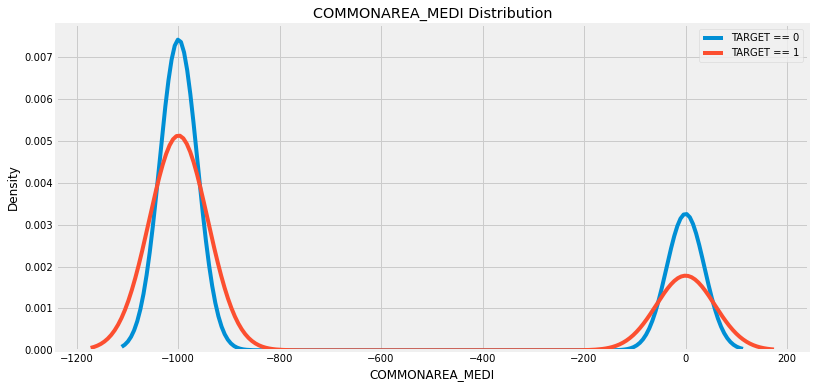

In [1460]:
## 特徴量の分布
kde_target('COMMONAREA_MEDI', app_train)

In [1461]:
## Yao-Johnson変換
num_cols = ['COMMONAREA_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['COMMONAREA_MEDI'] = pt.transform(app_train[num_cols])
app_test['COMMONAREA_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'COMMONAREA_MEDI']].corr()

TARGET  COMMONAREA_MEDI
TARGET           1.000000        -0.028054
COMMONAREA_MEDI -0.028054         1.000000

In [1462]:
## 標準化
num_cols = ['COMMONAREA_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['COMMONAREA_MEDI', 'TARGET']].corr()

COMMONAREA_MEDI    TARGET
COMMONAREA_MEDI         1.000000 -0.028054
TARGET                 -0.028054  1.000000

The correlation between COMMONAREA_MEDI and the TARGET is -0.0281
Median value for loan that was not repaid = -0.6566
Median value for loan that was repaid =     -0.6566


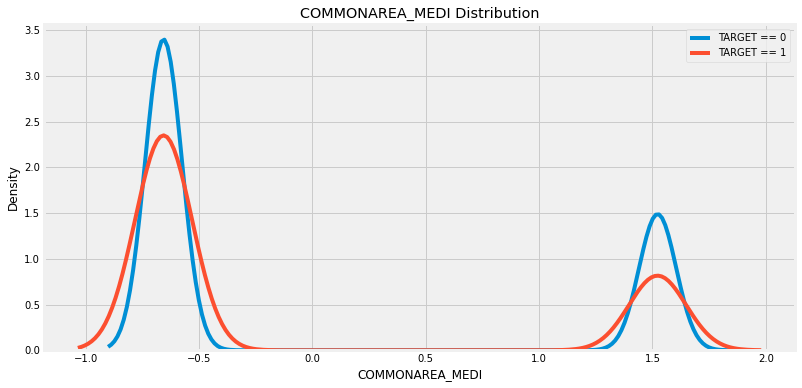

In [1463]:
## Yao-Johnson変換後の特徴量の分布
kde_target('COMMONAREA_MEDI', app_train)

### ELEVATORS_MEDI

In [1464]:
### Originから切り戻し
app_train['ELEVATORS_MEDI'] = app_train_origin['ELEVATORS_MEDI'].copy()
app_test['ELEVATORS_MEDI'] = app_test_origin['ELEVATORS_MEDI'].copy()
app_train['ELEVATORS_MEDI'].isnull().sum()

163891

In [1465]:
app_train['ELEVATORS_MEDI'].value_counts()

0.00    87026
0.08    10832
0.16     9278
0.24     6392
0.12     5946
0.04     4852
0.20     4162
0.32     2937
0.28     2317
0.40     1604
0.36     1405
0.48     1096
0.44      715
0.10      543
0.56      493
0.64      454
0.14      388
0.06      388
0.02      368
0.52      290
0.18      280
0.60      248
0.22      226
0.72      224
1.00      158
0.26      145
0.80      140
0.68      112
0.30       94
0.96       81
0.34       80
0.88       68
0.38       62
0.76       45
0.42       32
0.84       32
0.46       23
0.92       20
0.50       16
0.54       10
0.78       10
0.58        6
0.74        6
0.90        6
0.66        5
0.62        5
Name: ELEVATORS_MEDI, dtype: int64

In [1466]:
app_train[['ELEVATORS_MEDI', 'TARGET']].corr()

ELEVATORS_MEDI    TARGET
ELEVATORS_MEDI        1.000000 -0.033863
TARGET               -0.033863  1.000000

In [1467]:
### -999埋めで欠損値補完
app_train['ELEVATORS_MEDI'] = app_train['ELEVATORS_MEDI'].fillna(-999)
app_test['ELEVATORS_MEDI'] = app_test['ELEVATORS_MEDI'].fillna(-999)
app_train['ELEVATORS_MEDI'].isnull().sum()

0

In [1468]:
app_train[['ELEVATORS_MEDI', 'TARGET']].corr()

ELEVATORS_MEDI    TARGET
ELEVATORS_MEDI        1.000000 -0.040303
TARGET               -0.040303  1.000000

The correlation between ELEVATORS_MEDI and the TARGET is -0.0403
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


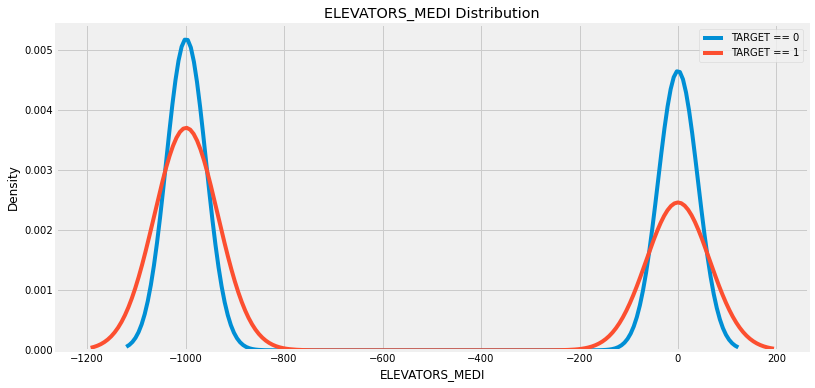

In [1469]:
## 特徴量の分布
kde_target('ELEVATORS_MEDI', app_train)

In [1470]:
## Yao-Johnson変換
num_cols = ['ELEVATORS_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ELEVATORS_MEDI'] = pt.transform(app_train[num_cols])
app_test['ELEVATORS_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ELEVATORS_MEDI']].corr()

TARGET  ELEVATORS_MEDI
TARGET          1.000000       -0.040823
ELEVATORS_MEDI -0.040823        1.000000

In [1471]:
## 標準化
num_cols = ['ELEVATORS_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['ELEVATORS_MEDI', 'TARGET']].corr()

ELEVATORS_MEDI    TARGET
ELEVATORS_MEDI        1.000000 -0.040823
TARGET               -0.040823  1.000000

The correlation between ELEVATORS_MEDI and the TARGET is -0.0408
Median value for loan that was not repaid = -0.9358
Median value for loan that was repaid =     -0.9358


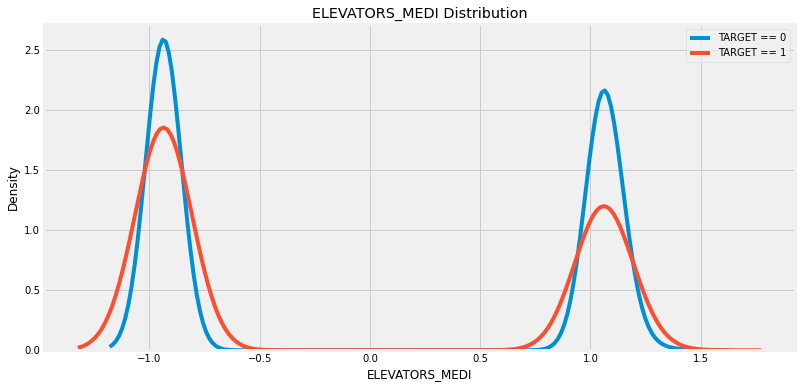

In [1472]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ELEVATORS_MEDI', app_train)

### ENTRANCES_MEDI

In [1473]:
### Originから切り戻し
app_train['ENTRANCES_MEDI'] = app_train_origin['ENTRANCES_MEDI'].copy()
app_test['ENTRANCES_MEDI'] = app_test_origin['ENTRANCES_MEDI'].copy()
app_train['ENTRANCES_MEDI'].isnull().sum()

154828

In [1474]:
app_train['ENTRANCES_MEDI'].value_counts()

0.1379    35535
0.0690    24193
0.1034    20492
0.2069    19750
0.0345    16150
0.1724     9566
0.2759     8048
0.2414     4318
0.3448     2108
0.3103     2086
0.0862     1352
0.1207     1228
0.4138     1198
0.3793     1010
0.1552      788
0.0517      611
0.1897      554
0.4828      503
0.4483      438
0.5517      352
0.0000      329
0.5172      304
0.2241      278
0.6207      241
0.5862      187
0.2586      169
1.0000      153
0.6897      116
0.2931      106
0.6552       68
0.3276       59
0.8966       52
0.7586       48
0.7241       44
0.8276       42
0.3621       39
0.7931       39
0.4310       31
0.9655       25
0.9310       21
0.3966       14
0.8621       14
0.4655       12
0.0172        7
0.5690        4
0.5000        1
Name: ENTRANCES_MEDI, dtype: int64

In [1475]:
app_train[['ENTRANCES_MEDI', 'TARGET']].corr()

ENTRANCES_MEDI    TARGET
ENTRANCES_MEDI        1.000000 -0.019025
TARGET               -0.019025  1.000000

In [1476]:
### -999埋めで欠損値補完
app_train['ENTRANCES_MEDI'] = app_train['ENTRANCES_MEDI'].fillna(-999)
app_test['ENTRANCES_MEDI'] = app_test['ENTRANCES_MEDI'].fillna(-999)
app_train['ENTRANCES_MEDI'].isnull().sum()

0

In [1477]:
app_train[['ENTRANCES_MEDI', 'TARGET']].corr()

ENTRANCES_MEDI    TARGET
ENTRANCES_MEDI        1.000000 -0.040874
TARGET               -0.040874  1.000000

In [1478]:
## Yao-Johnson変換
num_cols = ['ENTRANCES_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ENTRANCES_MEDI'] = pt.transform(app_train[num_cols])
app_test['ENTRANCES_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ENTRANCES_MEDI']].corr()

TARGET  ENTRANCES_MEDI
TARGET          1.000000       -0.041143
ENTRANCES_MEDI -0.041143        1.000000

In [1479]:
## 標準化
num_cols = ['ENTRANCES_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['ENTRANCES_MEDI', 'TARGET']].corr()

ENTRANCES_MEDI    TARGET
ENTRANCES_MEDI        1.000000 -0.041143
TARGET               -0.041143  1.000000

The correlation between ENTRANCES_MEDI and the TARGET is -0.0411
Median value for loan that was not repaid = -0.9927
Median value for loan that was repaid =     0.9712


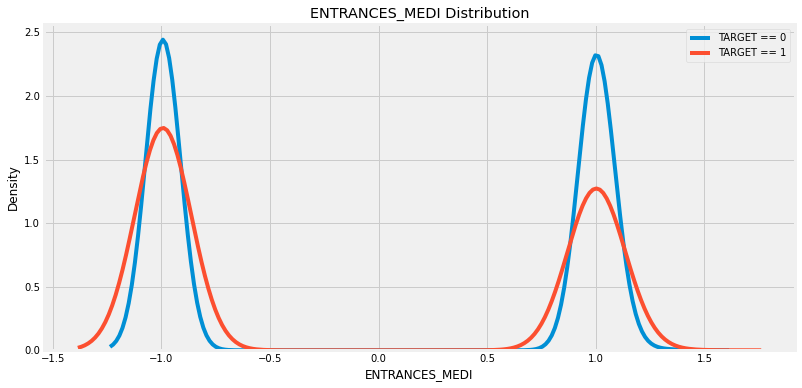

In [1480]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ENTRANCES_MEDI', app_train)

### FLOORSMAX_MEDI

In [1481]:
### Originから切り戻し
app_train['FLOORSMAX_MEDI'] = app_train_origin['FLOORSMAX_MEDI'].copy()
app_test['FLOORSMAX_MEDI'] = app_test_origin['FLOORSMAX_MEDI'].copy()
app_train['FLOORSMAX_MEDI'].isnull().sum()

153020

In [1482]:
app_train['FLOORSMAX_MEDI'].value_counts()

0.1667    63607
0.3333    33279
0.0417    14832
0.3750     8207
0.1250     7079
0.0833     6657
0.4583     3089
0.0000     2995
0.6250     2042
0.5417     1860
0.2500     1684
0.6667     1675
0.2083     1544
0.2917      567
0.1042      460
0.3542      459
0.5833      439
0.3958      346
0.4167      329
0.1458      321
0.5000      312
0.2708      291
0.1875      245
0.8750      223
0.4792      220
0.7083      204
1.0000      170
0.4375      138
0.7500      136
0.0625      132
0.3125      131
0.2292      128
0.0208      126
0.6042      115
0.9583       95
0.7917       61
0.5208       47
0.5625       46
0.8333       39
0.9167       37
0.6458       30
0.7708       27
0.6875       24
0.8125       23
0.7292       10
0.9375        4
0.8542        3
0.8958        2
0.9792        1
Name: FLOORSMAX_MEDI, dtype: int64

In [1483]:
app_train[['FLOORSMAX_MEDI', 'TARGET']].corr()

FLOORSMAX_MEDI    TARGET
FLOORSMAX_MEDI        1.000000 -0.043768
TARGET               -0.043768  1.000000

In [1484]:
### 0埋めで欠損値補完
app_train['FLOORSMAX_MEDI'] = app_train['FLOORSMAX_MEDI'].fillna(0)
app_test['FLOORSMAX_MEDI'] = app_test['FLOORSMAX_MEDI'].fillna(0)
app_train['FLOORSMAX_MEDI'].isnull().sum()

0

In [1485]:
app_train[['FLOORSMAX_MEDI', 'TARGET']].corr()

FLOORSMAX_MEDI   TARGET
FLOORSMAX_MEDI         1.00000 -0.04972
TARGET                -0.04972  1.00000

The correlation between FLOORSMAX_MEDI and the TARGET is -0.0497
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


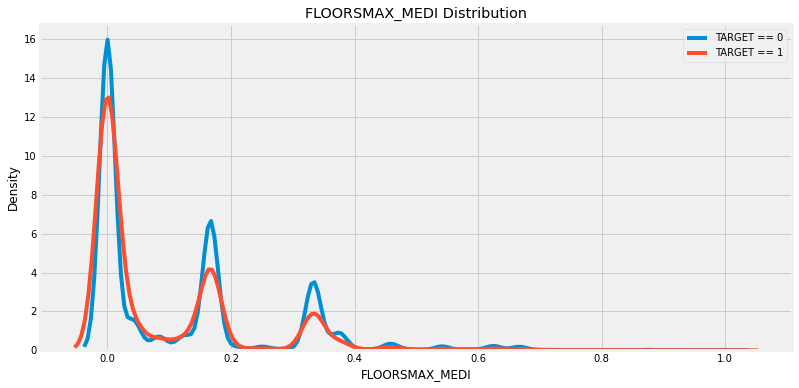

In [1486]:
## 特徴量の分布
kde_target('FLOORSMAX_MEDI', app_train)

In [1487]:
## Yao-Johnson変換
num_cols = ['FLOORSMAX_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['FLOORSMAX_MEDI'] = pt.transform(app_train[num_cols])
app_test['FLOORSMAX_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'FLOORSMAX_MEDI']].corr()

TARGET  FLOORSMAX_MEDI
TARGET          1.000000       -0.049972
FLOORSMAX_MEDI -0.049972        1.000000

In [1488]:
## 標準化
num_cols = ['FLOORSMAX_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['FLOORSMAX_MEDI', 'TARGET']].corr()

FLOORSMAX_MEDI    TARGET
FLOORSMAX_MEDI        1.000000 -0.049972
TARGET               -0.049972  1.000000

The correlation between FLOORSMAX_MEDI and the TARGET is -0.0500
Median value for loan that was not repaid = -0.9026
Median value for loan that was repaid =     -0.9026


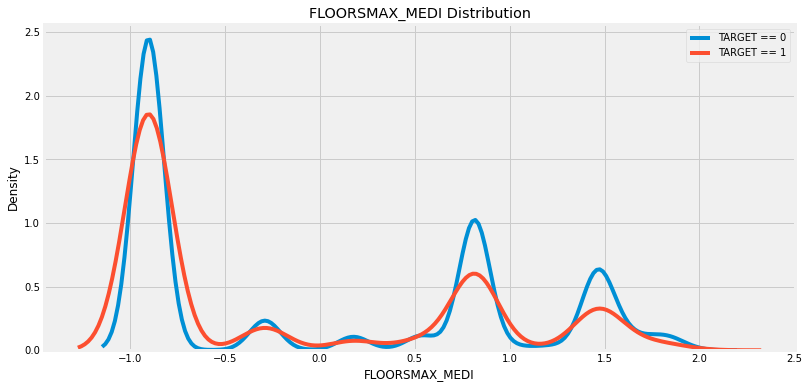

In [1489]:
## Yao-Johnson変換後の特徴量の分布
kde_target('FLOORSMAX_MEDI', app_train)

### FLOORSMIN_MEDI

In [1490]:
### Originから切り戻し
app_train['FLOORSMIN_MEDI'] = app_train_origin['FLOORSMIN_MEDI'].copy()
app_test['FLOORSMIN_MEDI'] = app_test_origin['FLOORSMIN_MEDI'].copy()
app_train['FLOORSMIN_MEDI'].isnull().sum()

208642

In [1491]:
app_train['FLOORSMIN_MEDI'].value_counts()

0.2083    33737
0.3750    18538
0.0417    18090
0.0833     5131
0.4167     4068
0.1667     3570
0.1250     3373
0.0000     2351
0.5000     1835
0.6667     1261
0.7083     1108
0.5833     1057
0.2917      852
0.2500      779
0.3333      341
0.6250      235
0.5417      212
0.3958      205
0.4375      186
0.1458      180
0.1875      159
0.4583      154
0.3125      148
1.0000      147
0.9167      130
0.2292      121
0.7500      116
0.1042      106
0.2708      104
0.5208       81
0.3542       79
0.7917       64
0.4792       61
0.0625       51
0.0208       50
0.6458       49
0.8333       27
0.5625       19
0.8750       16
0.6042       16
0.9583       14
0.8125       12
0.7292       10
0.6875        9
0.7708        7
0.9792        5
0.8542        5
Name: FLOORSMIN_MEDI, dtype: int64

In [1492]:
app_train[['FLOORSMIN_MEDI', 'TARGET']].corr()

FLOORSMIN_MEDI    TARGET
FLOORSMIN_MEDI        1.000000 -0.033394
TARGET               -0.033394  1.000000

In [1493]:
### 0埋めで欠損値補完
app_train['FLOORSMIN_MEDI'] = app_train['FLOORSMIN_MEDI'].fillna(0)
app_test['FLOORSMIN_MEDI'] = app_test['FLOORSMIN_MEDI'].fillna(0)
app_train['FLOORSMIN_MEDI'].isnull().sum()

0

In [1494]:
app_train[['FLOORSMIN_MEDI', 'TARGET']].corr()

FLOORSMIN_MEDI    TARGET
FLOORSMIN_MEDI        1.000000 -0.034089
TARGET               -0.034089  1.000000

The correlation between FLOORSMIN_MEDI and the TARGET is -0.0341
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


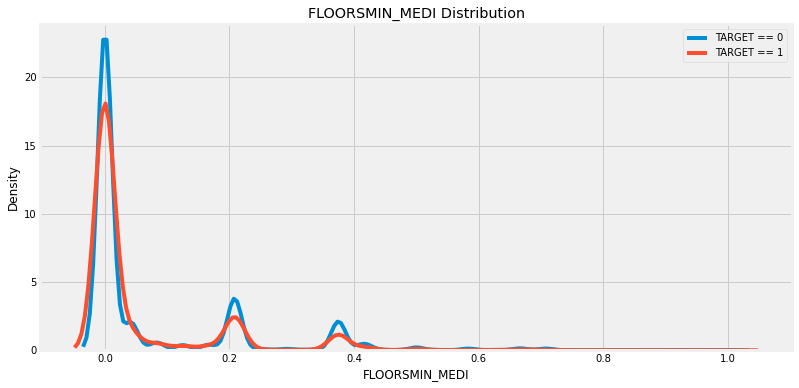

In [1495]:
## 特徴量の分布
kde_target('FLOORSMIN_MEDI', app_train)

In [1496]:
## Yao-Johnson変換
#num_cols = ['FLOORSMIN_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['FLOORSMIN_MEDI'] = pt.transform(app_train[num_cols])
#app_test['FLOORSMIN_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'FLOORSMIN_MEDI']].corr()

In [1497]:
## 標準化
num_cols = ['FLOORSMIN_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['FLOORSMIN_MEDI', 'TARGET']].corr()

FLOORSMIN_MEDI    TARGET
FLOORSMIN_MEDI        1.000000 -0.034089
TARGET               -0.034089  1.000000

In [1498]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('FLOORSMIN_MEDI', app_train)

### LANDAREA_MEDI

In [1499]:
### Originから切り戻し
app_train['LANDAREA_MEDI'] = app_train_origin['LANDAREA_MEDI'].copy()
app_test['LANDAREA_MEDI'] = app_test_origin['LANDAREA_MEDI'].copy()
app_train['LANDAREA_MEDI'].isnull().sum()

182590

In [1500]:
app_train['LANDAREA_MEDI'].value_counts()

0.0000    15919
0.0193      197
0.0642      194
0.0482      186
0.0143      180
          ...  
0.7523        1
0.3480        1
0.3288        1
0.8106        1
0.2709        1
Name: LANDAREA_MEDI, Length: 3560, dtype: int64

In [1501]:
app_train[['LANDAREA_MEDI', 'TARGET']].corr()

LANDAREA_MEDI    TARGET
LANDAREA_MEDI       1.000000 -0.011256
TARGET             -0.011256  1.000000

In [1502]:
### -999埋めで欠損値補完
app_train['LANDAREA_MEDI'] = app_train['LANDAREA_MEDI'].fillna(-999)
app_test['LANDAREA_MEDI'] = app_test['LANDAREA_MEDI'].fillna(-999)
app_train['LANDAREA_MEDI'].isnull().sum()

0

In [1503]:
app_train[['LANDAREA_MEDI', 'TARGET']].corr()

LANDAREA_MEDI    TARGET
LANDAREA_MEDI       1.000000 -0.033147
TARGET             -0.033147  1.000000

The correlation between LANDAREA_MEDI and the TARGET is -0.0331
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


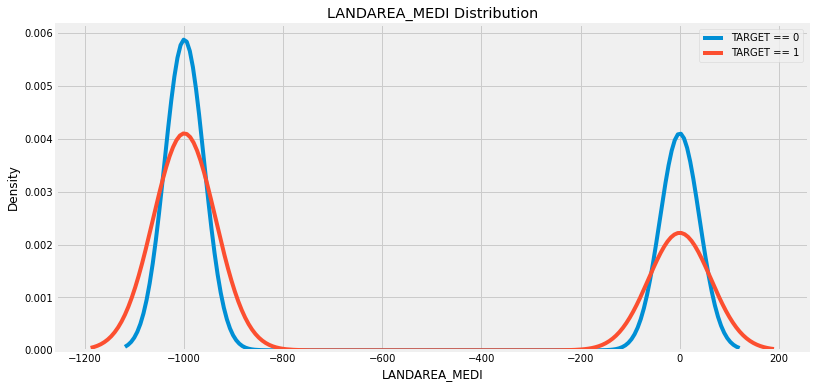

In [1504]:
## 特徴量の分布
kde_target('LANDAREA_MEDI', app_train)

In [1505]:
## Yao-Johnson変換
num_cols = ['LANDAREA_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LANDAREA_MEDI'] = pt.transform(app_train[num_cols])
app_test['LANDAREA_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LANDAREA_MEDI']].corr()

TARGET  LANDAREA_MEDI
TARGET         1.000000      -0.033204
LANDAREA_MEDI -0.033204       1.000000

In [1506]:
## 標準化
num_cols = ['LANDAREA_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['LANDAREA_MEDI', 'TARGET']].corr()

LANDAREA_MEDI    TARGET
LANDAREA_MEDI       1.000000 -0.033204
TARGET             -0.033204  1.000000

The correlation between LANDAREA_MEDI and the TARGET is -0.0332
Median value for loan that was not repaid = -0.8271
Median value for loan that was repaid =     -0.8271


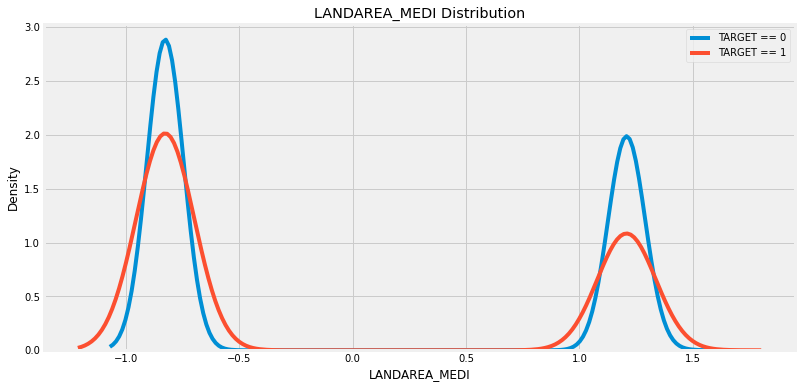

In [1507]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LANDAREA_MEDI', app_train)

### LIVINGAPARTMENTS_MEDI

In [1508]:
### Originから切り戻し
app_train['LIVINGAPARTMENTS_MEDI'] = app_train_origin['LIVINGAPARTMENTS_MEDI'].copy()
app_test['LIVINGAPARTMENTS_MEDI'] = app_test_origin['LIVINGAPARTMENTS_MEDI'].copy()
app_train['LIVINGAPARTMENTS_MEDI'].isnull().sum()

210199

In [1509]:
app_train['LIVINGAPARTMENTS_MEDI'].value_counts()

0.0513    4500
0.0684    4497
0.0770    2926
0.0599    2708
0.0855    2014
          ... 
0.2672       1
0.9149       1
0.8183       1
0.6020       1
0.3638       1
Name: LIVINGAPARTMENTS_MEDI, Length: 1097, dtype: int64

In [1510]:
app_train[['LIVINGAPARTMENTS_MEDI', 'TARGET']].corr()

LIVINGAPARTMENTS_MEDI    TARGET
LIVINGAPARTMENTS_MEDI               1.000000 -0.024621
TARGET                             -0.024621  1.000000

In [1511]:
### -999埋めで欠損値補完
app_train['LIVINGAPARTMENTS_MEDI'] = app_train['LIVINGAPARTMENTS_MEDI'].fillna(-999)
app_test['LIVINGAPARTMENTS_MEDI'] = app_test['LIVINGAPARTMENTS_MEDI'].fillna(-999)
app_train['LIVINGAPARTMENTS_MEDI'].isnull().sum()

0

In [1512]:
app_train[['LIVINGAPARTMENTS_MEDI', 'TARGET']].corr()

LIVINGAPARTMENTS_MEDI    TARGET
LIVINGAPARTMENTS_MEDI               1.000000 -0.029592
TARGET                             -0.029592  1.000000

The correlation between LIVINGAPARTMENTS_MEDI and the TARGET is -0.0296
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     -999.0000


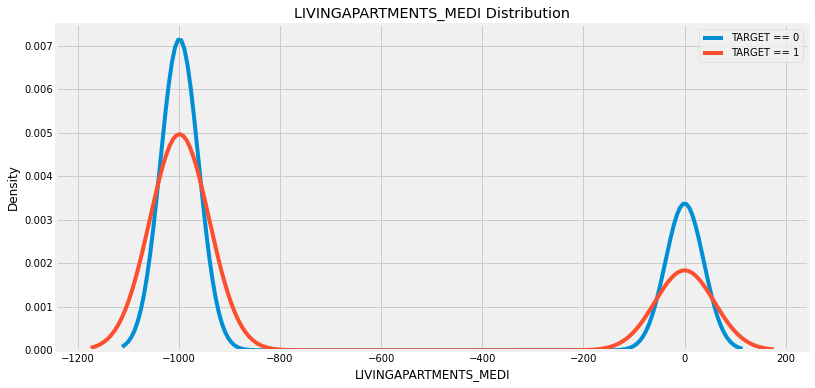

In [1513]:
## 特徴量の分布
kde_target('LIVINGAPARTMENTS_MEDI', app_train)

In [1514]:
## Yao-Johnson変換
num_cols = ['LIVINGAPARTMENTS_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAPARTMENTS_MEDI'] = pt.transform(app_train[num_cols])
app_test['LIVINGAPARTMENTS_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAPARTMENTS_MEDI']].corr()

TARGET  LIVINGAPARTMENTS_MEDI
TARGET                 1.000000              -0.029646
LIVINGAPARTMENTS_MEDI -0.029646               1.000000

In [1515]:
## 標準化
num_cols = ['LIVINGAPARTMENTS_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['LIVINGAPARTMENTS_MEDI', 'TARGET']].corr()

LIVINGAPARTMENTS_MEDI    TARGET
LIVINGAPARTMENTS_MEDI               1.000000 -0.029646
TARGET                             -0.029646  1.000000

The correlation between LIVINGAPARTMENTS_MEDI and the TARGET is -0.0296
Median value for loan that was not repaid = -0.6804
Median value for loan that was repaid =     -0.6804


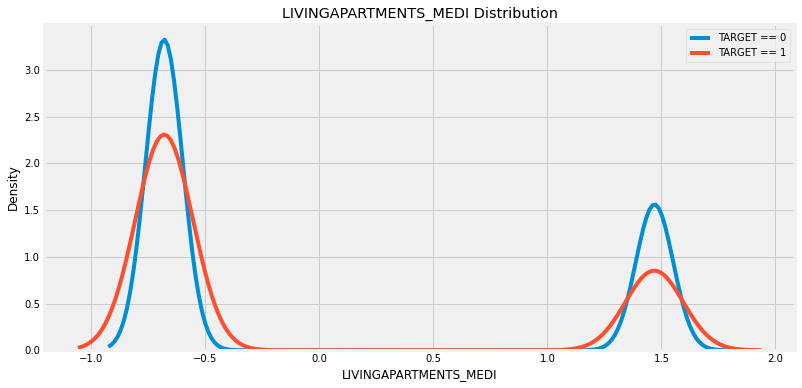

In [1516]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAPARTMENTS_MEDI', app_train)

### LIVINGAREA_MEDI

In [1517]:
### Originから切り戻し
app_train['LIVINGAREA_MEDI'] = app_train_origin['LIVINGAREA_MEDI'].copy()
app_test['LIVINGAREA_MEDI'] = app_test_origin['LIVINGAREA_MEDI'].copy()
app_train['LIVINGAREA_MEDI'].isnull().sum()

154350

In [1518]:
app_train['LIVINGAREA_MEDI'].value_counts()

0.0000    299
0.0548    239
0.0518    234
0.0520    233
0.0521    232
         ... 
0.5532      1
0.4647      1
0.8707      1
0.4206      1
0.9445      1
Name: LIVINGAREA_MEDI, Length: 5281, dtype: int64

In [1519]:
app_train[['LIVINGAREA_MEDI', 'TARGET']].corr()

LIVINGAREA_MEDI    TARGET
LIVINGAREA_MEDI         1.000000 -0.032739
TARGET                 -0.032739  1.000000

In [1520]:
### -999埋めで欠損値補完
app_train['LIVINGAREA_MEDI'] = app_train['LIVINGAREA_MEDI'].fillna(-999)
app_test['LIVINGAREA_MEDI'] = app_test['LIVINGAREA_MEDI'].fillna(-999)
app_train['LIVINGAREA_MEDI'].isnull().sum()

0

In [1521]:
app_train[['LIVINGAREA_MEDI', 'TARGET']].corr()

LIVINGAREA_MEDI    TARGET
LIVINGAREA_MEDI         1.000000 -0.039409
TARGET                 -0.039409  1.000000

The correlation between LIVINGAREA_MEDI and the TARGET is -0.0394
Median value for loan that was not repaid = -999.0000
Median value for loan that was repaid =     0.0019


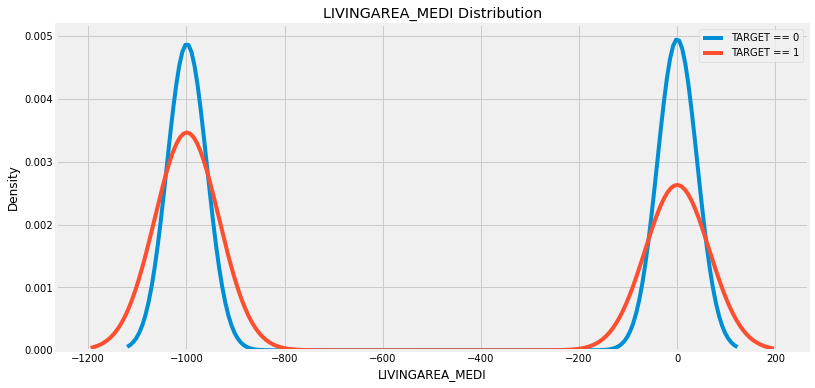

In [1522]:
kde_target('LIVINGAREA_MEDI', app_train)

In [1523]:
## Yao-Johnson変換
num_cols = ['LIVINGAREA_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAREA_MEDI'] = pt.transform(app_train[num_cols])
app_test['LIVINGAREA_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAREA_MEDI']].corr()

TARGET  LIVINGAREA_MEDI
TARGET           1.000000        -0.039953
LIVINGAREA_MEDI -0.039953         1.000000

In [1524]:
## 標準化
num_cols = ['LIVINGAREA_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['LIVINGAREA_MEDI', 'TARGET']].corr()

LIVINGAREA_MEDI    TARGET
LIVINGAREA_MEDI         1.000000 -0.039953
TARGET                 -0.039953  1.000000

The correlation between LIVINGAREA_MEDI and the TARGET is -0.0400
Median value for loan that was not repaid = -0.9957
Median value for loan that was repaid =     0.9705


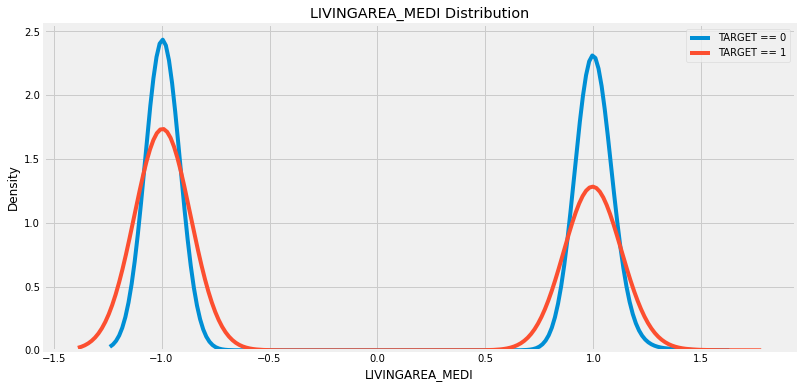

In [1525]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAREA_MEDI', app_train)

### NONLIVINGAPARTMENTS_MEDI

In [1526]:
### Originから切り戻し
app_train['NONLIVINGAPARTMENTS_MEDI'] = app_train_origin['NONLIVINGAPARTMENTS_MEDI'].copy()
app_test['NONLIVINGAPARTMENTS_MEDI'] = app_test_origin['NONLIVINGAPARTMENTS_MEDI'].copy()
app_train['NONLIVINGAPARTMENTS_MEDI'].isnull().sum()

213514

In [1527]:
app_train['NONLIVINGAPARTMENTS_MEDI'].value_counts()

0.0000    56097
0.0039    14126
0.0078     6493
0.0116     3788
0.0155     2557
          ...  
0.6638        1
0.6289        1
0.4852        1
0.3649        1
0.6056        1
Name: NONLIVINGAPARTMENTS_MEDI, Length: 214, dtype: int64

In [1528]:
app_train[['NONLIVINGAPARTMENTS_MEDI', 'TARGET']].corr()

NONLIVINGAPARTMENTS_MEDI    TARGET
NONLIVINGAPARTMENTS_MEDI                  1.000000 -0.002757
TARGET                                   -0.002757  1.000000

In [1529]:
### -999埋めで欠損値補完
app_train['NONLIVINGAPARTMENTS_MEDI'] = app_train['NONLIVINGAPARTMENTS_MEDI'].fillna(-1)
app_test['NONLIVINGAPARTMENTS_MEDI'] = app_test['NONLIVINGAPARTMENTS_MEDI'].fillna(-1)
app_train['NONLIVINGAPARTMENTS_MEDI'].isnull().sum()

0

In [1530]:
app_train[['NONLIVINGAPARTMENTS_MEDI', 'TARGET']].corr()

NONLIVINGAPARTMENTS_MEDI    TARGET
NONLIVINGAPARTMENTS_MEDI                  1.000000 -0.028286
TARGET                                   -0.028286  1.000000

In [1531]:
## Yao-Johnson変換
num_cols = ['NONLIVINGAPARTMENTS_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['NONLIVINGAPARTMENTS_MEDI'] = pt.transform(app_train[num_cols])
app_test['NONLIVINGAPARTMENTS_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'NONLIVINGAPARTMENTS_MEDI']].corr()

TARGET  NONLIVINGAPARTMENTS_MEDI
TARGET                    1.000000                 -0.028272
NONLIVINGAPARTMENTS_MEDI -0.028272                  1.000000

In [1532]:
## 標準化
num_cols = ['NONLIVINGAPARTMENTS_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['NONLIVINGAPARTMENTS_MEDI', 'TARGET']].corr()

NONLIVINGAPARTMENTS_MEDI    TARGET
NONLIVINGAPARTMENTS_MEDI                  1.000000 -0.028272
TARGET                                   -0.028272  1.000000

The correlation between NONLIVINGAPARTMENTS_MEDI and the TARGET is -0.0283
Median value for loan that was not repaid = -0.6635
Median value for loan that was repaid =     -0.6635


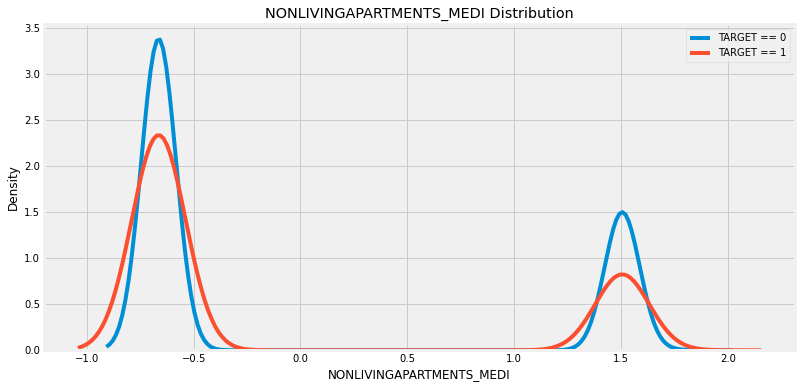

In [1533]:
## Yao-Johnson変換後の特徴量の分布
kde_target('NONLIVINGAPARTMENTS_MEDI', app_train)

### NONLIVINGAREA_MEDI

In [1534]:
### Originから切り戻し
app_train['NONLIVINGAREA_MEDI'] = app_train_origin['NONLIVINGAREA_MEDI'].copy()
app_test['NONLIVINGAREA_MEDI'] = app_test_origin['NONLIVINGAREA_MEDI'].copy()
app_train['NONLIVINGAREA_MEDI'].isnull().sum()

169682

In [1535]:
app_train['NONLIVINGAREA_MEDI'].value_counts()

0.0000    60954
0.0012      539
0.0022      478
0.0037      456
0.0044      431
          ...  
0.3908        1
0.2364        1
0.3819        1
0.3323        1
0.2940        1
Name: NONLIVINGAREA_MEDI, Length: 3323, dtype: int64

In [1536]:
app_train[['NONLIVINGAREA_MEDI', 'TARGET']].corr()

NONLIVINGAREA_MEDI    TARGET
NONLIVINGAREA_MEDI            1.000000 -0.013337
TARGET                       -0.013337  1.000000

In [1537]:
### -999埋めで欠損値補完
app_train['NONLIVINGAREA_MEDI'] = app_train['NONLIVINGAREA_MEDI'].fillna(-1)
app_test['NONLIVINGAREA_MEDI'] = app_test['NONLIVINGAREA_MEDI'].fillna(-1)
app_train['NONLIVINGAREA_MEDI'].isnull().sum()

0

In [1538]:
app_train[['NONLIVINGAREA_MEDI', 'TARGET']].corr()

NONLIVINGAREA_MEDI    TARGET
NONLIVINGAREA_MEDI            1.000000 -0.039763
TARGET                       -0.039763  1.000000

The correlation between NONLIVINGAREA_MEDI and the TARGET is -0.0398
Median value for loan that was not repaid = -1.0000
Median value for loan that was repaid =     -1.0000


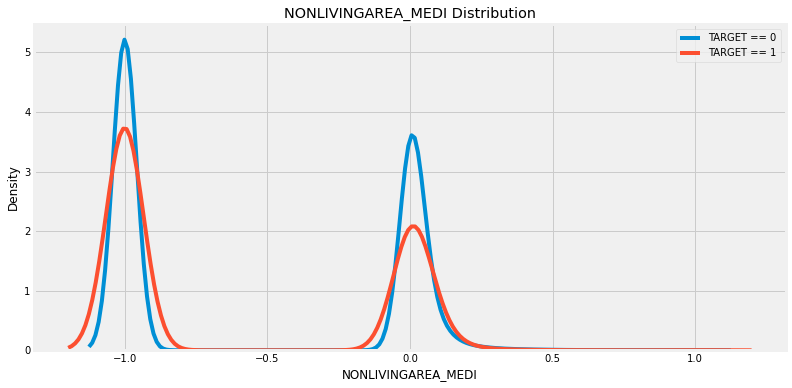

In [1539]:
## 特徴量の分布
kde_target('NONLIVINGAREA_MEDI', app_train)

In [1540]:
## Yao-Johnson変換
num_cols = ['NONLIVINGAREA_MEDI']

### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['NONLIVINGAREA_MEDI'] = pt.transform(app_train[num_cols])
app_test['NONLIVINGAREA_MEDI'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'NONLIVINGAREA_MEDI']].corr()

TARGET  NONLIVINGAREA_MEDI
TARGET              1.000000           -0.039754
NONLIVINGAREA_MEDI -0.039754            1.000000

In [1541]:
## 標準化
num_cols = ['NONLIVINGAREA_MEDI']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['NONLIVINGAREA_MEDI', 'TARGET']].corr()

NONLIVINGAREA_MEDI    TARGET
NONLIVINGAREA_MEDI            1.000000 -0.039754
TARGET                       -0.039754  1.000000

The correlation between NONLIVINGAREA_MEDI and the TARGET is -0.0398
Median value for loan that was not repaid = -0.8977
Median value for loan that was repaid =     -0.8977


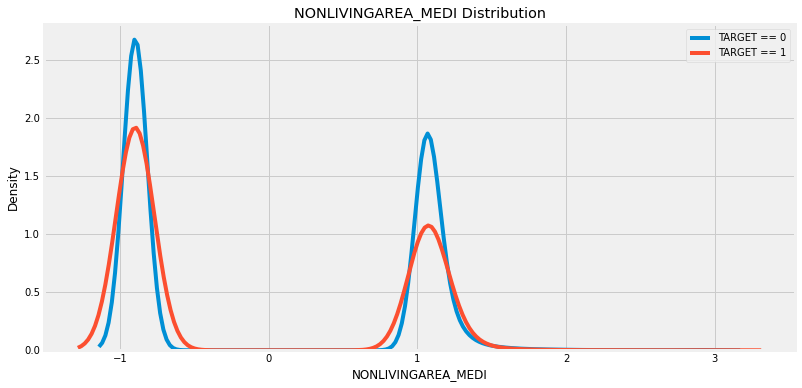

In [1542]:
## Yao-Johnson変換後の特徴量の分布
kde_target('NONLIVINGAREA_MEDI', app_train)

### FONDKAPREMONT_MODE

In [1543]:
### Originから切り戻し
app_train['FONDKAPREMONT_MODE'] = app_train_origin['FONDKAPREMONT_MODE'].copy()
app_test['FONDKAPREMONT_MODE'] = app_test_origin['FONDKAPREMONT_MODE'].copy()
app_train['FONDKAPREMONT_MODE'].isnull().sum()

210295

In [1544]:
app_train['FONDKAPREMONT_MODE'].value_counts()

reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: FONDKAPREMONT_MODE, dtype: int64

In [1545]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'FONDKAPREMONT_MODE')

In [1546]:
app_train['FONDKAPREMONT_MODE'].value_counts()

1    210295
0     73830
3     12080
4      5687
2      5619
Name: FONDKAPREMONT_MODE, dtype: int64

In [1547]:
app_train[['FONDKAPREMONT_MODE', 'TARGET']].corr()

FONDKAPREMONT_MODE    TARGET
FONDKAPREMONT_MODE            1.000000  0.003542
TARGET                        0.003542  1.000000

### HOUSETYPE_MODE

In [1548]:
### Originから切り戻し
app_train['HOUSETYPE_MODE'] = app_train_origin['HOUSETYPE_MODE'].copy()
app_test['HOUSETYPE_MODE'] = app_test_origin['HOUSETYPE_MODE'].copy()
app_train['HOUSETYPE_MODE'].isnull().sum()

154297

In [1549]:
app_train['HOUSETYPE_MODE'].value_counts()

block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64

In [1550]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'HOUSETYPE_MODE')
app_train['HOUSETYPE_MODE'].value_counts()

1    154297
0    150503
3      1499
2      1212
Name: HOUSETYPE_MODE, dtype: int64

In [1551]:
app_train[['TARGET', 'HOUSETYPE_MODE']].corr()

TARGET  HOUSETYPE_MODE
TARGET          1.000000        0.039406
HOUSETYPE_MODE  0.039406        1.000000

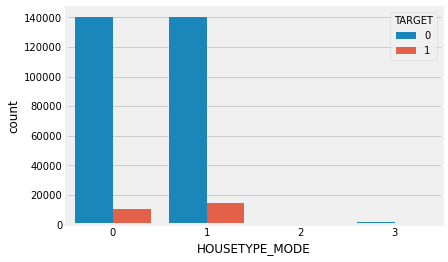

In [1552]:
### ヒストグラム(TARGET比較)
%matplotlib inline
sns.countplot(x='HOUSETYPE_MODE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### TOTALAREA_MODE

In [1553]:
### Originから切り戻し
app_train['TOTALAREA_MODE'] = app_train_origin['TOTALAREA_MODE'].copy()
app_test['TOTALAREA_MODE'] = app_test_origin['TOTALAREA_MODE'].copy()
app_train['TOTALAREA_MODE'].isnull().sum()

148431

In [1554]:
app_train['TOTALAREA_MODE'].value_counts()

0.0000    582
0.0570    247
0.0547    230
0.0550    227
0.0555    227
         ... 
0.3445      1
0.2894      1
0.8712      1
0.5775      1
0.7970      1
Name: TOTALAREA_MODE, Length: 5116, dtype: int64

In [1555]:
app_train[['TOTALAREA_MODE', 'TARGET']].corr()

TOTALAREA_MODE    TARGET
TOTALAREA_MODE        1.000000 -0.032596
TARGET               -0.032596  1.000000

In [1556]:
### 0埋めで欠損値補完
app_train['TOTALAREA_MODE'] = app_train['TOTALAREA_MODE'].fillna(-1)
app_test['TOTALAREA_MODE'] = app_test['TOTALAREA_MODE'].fillna(-1)
app_train['TOTALAREA_MODE'].isnull().sum()

0

In [1557]:
app_train[['TOTALAREA_MODE', 'TARGET']].corr()

TOTALAREA_MODE    TARGET
TOTALAREA_MODE        1.000000 -0.043818
TARGET               -0.043818  1.000000

The correlation between TOTALAREA_MODE and the TARGET is -0.0438
Median value for loan that was not repaid = -1.0000
Median value for loan that was repaid =     0.0064


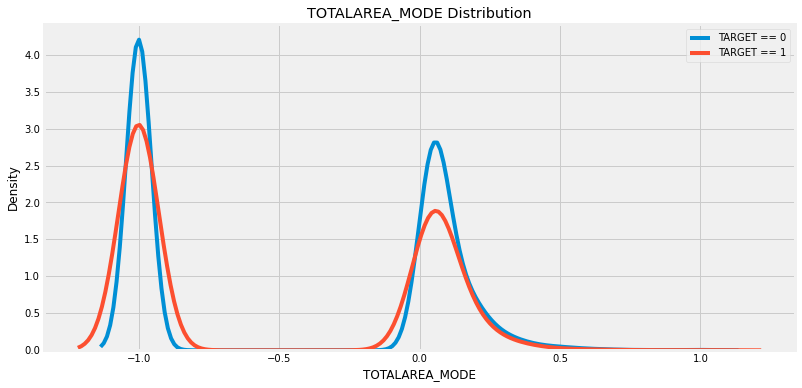

In [1558]:
### 目的変数との関係を可視化
kde_target('TOTALAREA_MODE', app_train)

In [1559]:
## Yao-Johnson変換
num_cols = ['TOTALAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['TOTALAREA_MODE'] = pt.transform(app_train[num_cols])
app_test['TOTALAREA_MODE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'TOTALAREA_MODE']].corr()

TARGET  TOTALAREA_MODE
TARGET          1.000000       -0.044439
TOTALAREA_MODE -0.044439        1.000000

In [1560]:
## 標準化
num_cols = ['TOTALAREA_MODE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['TOTALAREA_MODE', 'TARGET']].corr()

TOTALAREA_MODE    TARGET
TOTALAREA_MODE        1.000000 -0.044439
TARGET               -0.044439  1.000000

The correlation between TOTALAREA_MODE and the TARGET is -0.0444
Median value for loan that was not repaid = -1.0159
Median value for loan that was repaid =     0.7254


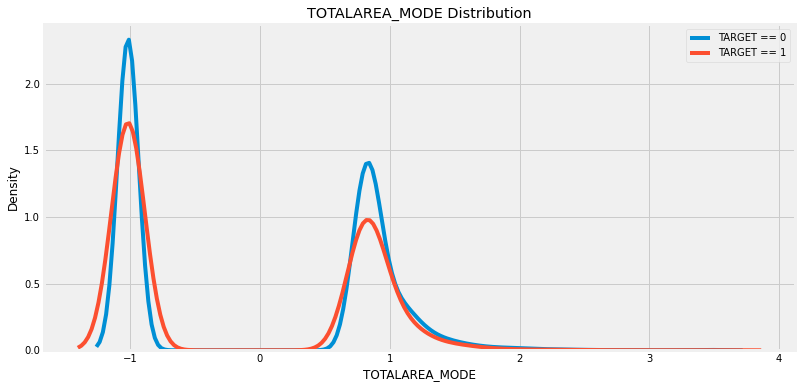

In [1561]:
## Yao-Johnson変換後の特徴量の分布
kde_target('TOTALAREA_MODE', app_train)

### WALLSMATERIAL_MODE

In [1562]:
### Originから切り戻し
app_train['WALLSMATERIAL_MODE'] = app_train_origin['WALLSMATERIAL_MODE'].copy()
app_test['WALLSMATERIAL_MODE'] = app_test_origin['WALLSMATERIAL_MODE'].copy()
app_train['WALLSMATERIAL_MODE'].isnull().sum()

156341

In [1563]:
app_train['WALLSMATERIAL_MODE'].value_counts()

Panel           66040
Stone, brick    64815
Block            9253
Wooden           5362
Mixed            2296
Monolithic       1779
Others           1625
Name: WALLSMATERIAL_MODE, dtype: int64

In [1564]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'WALLSMATERIAL_MODE')
app_train['WALLSMATERIAL_MODE'].value_counts()

2    156341
3     66040
0     64815
1      9253
5      5362
4      2296
7      1779
6      1625
Name: WALLSMATERIAL_MODE, dtype: int64

In [1565]:
app_train[['WALLSMATERIAL_MODE', 'TARGET']].corr()

WALLSMATERIAL_MODE    TARGET
WALLSMATERIAL_MODE            1.000000 -0.002187
TARGET                       -0.002187  1.000000

In [1566]:
app_train['WALLSMATERIAL_MODE'].isnull().sum()

0

### EMERGENCYSTATE_MODE

In [1567]:
### Originから切り戻し
app_train['EMERGENCYSTATE_MODE'] = app_train_origin['EMERGENCYSTATE_MODE'].copy()
app_test['EMERGENCYSTATE_MODE'] = app_test_origin['EMERGENCYSTATE_MODE'].copy()
app_train['EMERGENCYSTATE_MODE'].isnull().sum()

145755

In [1568]:
app_train['EMERGENCYSTATE_MODE'].value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [1569]:
### ラベルエンコーディング
result = modules.process_label_encoding(app_train, app_test, 'EMERGENCYSTATE_MODE')
app_train['EMERGENCYSTATE_MODE'].value_counts()

0    159428
1    145755
2      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [1570]:
app_train[['EMERGENCYSTATE_MODE', 'TARGET']].corr()

EMERGENCYSTATE_MODE    TARGET
EMERGENCYSTATE_MODE             1.000000  0.041773
TARGET                          0.041773  1.000000

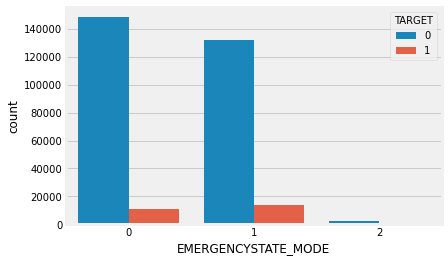

In [1571]:
### ヒストグラム(TARGET比較)
%matplotlib inline
sns.countplot(x='EMERGENCYSTATE_MODE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### OBS_30_CNT_SOCIAL_CIRCLE

In [1572]:
### Originから切り戻し
app_train['OBS_30_CNT_SOCIAL_CIRCLE'] = app_train_origin['OBS_30_CNT_SOCIAL_CIRCLE'].copy()
app_test['OBS_30_CNT_SOCIAL_CIRCLE'] = app_test_origin['OBS_30_CNT_SOCIAL_CIRCLE'].copy()
app_train['OBS_30_CNT_SOCIAL_CIRCLE'].isnull().sum()

1021

In [1573]:
app_train['OBS_30_CNT_SOCIAL_CIRCLE'].value_counts()

0.0      163910
1.0       48783
2.0       29808
3.0       20322
4.0       14143
5.0        9553
6.0        6453
7.0        4390
8.0        2967
9.0        2003
10.0       1376
11.0        852
12.0        652
13.0        411
14.0        258
15.0        166
16.0        133
17.0         88
18.0         46
19.0         44
20.0         30
21.0         29
22.0         22
23.0         15
25.0         11
24.0         11
27.0          5
26.0          3
30.0          2
28.0          1
29.0          1
47.0          1
348.0         1
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: int64

In [1574]:
app_train[['OBS_30_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

OBS_30_CNT_SOCIAL_CIRCLE    TARGET
OBS_30_CNT_SOCIAL_CIRCLE                  1.000000  0.009131
TARGET                                    0.009131  1.000000

In [1575]:
### -999埋めで欠損値補完
app_train['OBS_30_CNT_SOCIAL_CIRCLE'] = app_train['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(-1)
app_test['OBS_30_CNT_SOCIAL_CIRCLE'] = app_test['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(-1)
app_train['OBS_30_CNT_SOCIAL_CIRCLE'].isnull().sum()

0

In [1576]:
app_train[['OBS_30_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

OBS_30_CNT_SOCIAL_CIRCLE    TARGET
OBS_30_CNT_SOCIAL_CIRCLE                  1.000000  0.009667
TARGET                                    0.009667  1.000000

The correlation between OBS_30_CNT_SOCIAL_CIRCLE and the TARGET is 0.0097
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


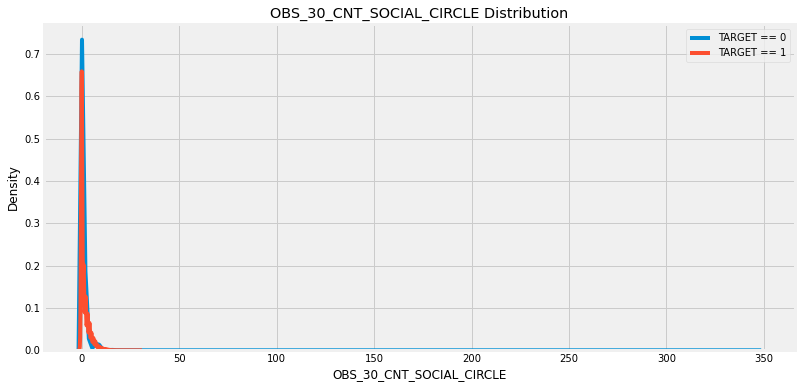

In [1577]:
## 特徴量の分布
kde_target('OBS_30_CNT_SOCIAL_CIRCLE', app_train)

In [1578]:
## Yao-Johnson変換
num_cols = ['OBS_30_CNT_SOCIAL_CIRCLE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['OBS_30_CNT_SOCIAL_CIRCLE'] = pt.transform(app_train[num_cols])
app_test['OBS_30_CNT_SOCIAL_CIRCLE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'OBS_30_CNT_SOCIAL_CIRCLE']].corr()

TARGET  OBS_30_CNT_SOCIAL_CIRCLE
TARGET                    1.000000                  0.011844
OBS_30_CNT_SOCIAL_CIRCLE  0.011844                  1.000000

In [1579]:
## 標準化
num_cols = ['OBS_30_CNT_SOCIAL_CIRCLE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['OBS_30_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

OBS_30_CNT_SOCIAL_CIRCLE    TARGET
OBS_30_CNT_SOCIAL_CIRCLE                  1.000000  0.011844
TARGET                                    0.011844  1.000000

The correlation between OBS_30_CNT_SOCIAL_CIRCLE and the TARGET is 0.0118
Median value for loan that was not repaid = -0.8191
Median value for loan that was repaid =     -0.8191


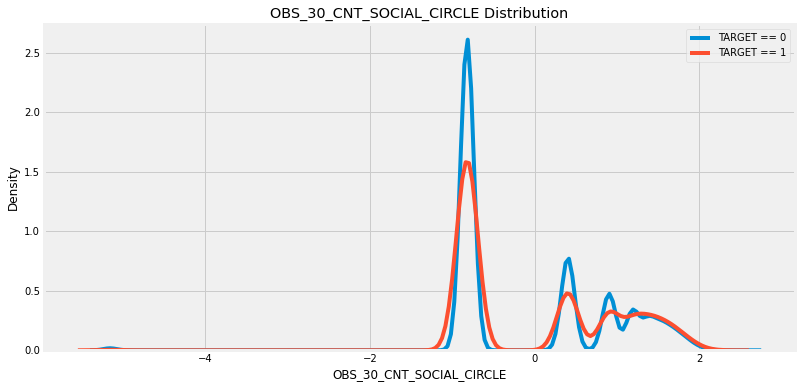

In [1580]:
## Yao-Johnson変換後の特徴量の分布
kde_target('OBS_30_CNT_SOCIAL_CIRCLE', app_train)

### DEF_30_CNT_SOCIAL_CIRCLE

In [1581]:
### Originから切り戻し
app_train['DEF_30_CNT_SOCIAL_CIRCLE'] = app_train_origin['DEF_30_CNT_SOCIAL_CIRCLE'].copy()
app_test['DEF_30_CNT_SOCIAL_CIRCLE'] = app_test_origin['DEF_30_CNT_SOCIAL_CIRCLE'].copy()
app_train['DEF_30_CNT_SOCIAL_CIRCLE'].isnull().sum()

1021

In [1582]:
app_train['DEF_30_CNT_SOCIAL_CIRCLE'].value_counts()

0.0     271324
1.0      28328
2.0       5323
3.0       1192
4.0        253
5.0         56
6.0         11
7.0          1
34.0         1
8.0          1
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: int64

In [1583]:
app_train[['DEF_30_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

DEF_30_CNT_SOCIAL_CIRCLE    TARGET
DEF_30_CNT_SOCIAL_CIRCLE                  1.000000  0.032248
TARGET                                    0.032248  1.000000

In [1584]:
### -999埋めで欠損値補完
app_train['DEF_30_CNT_SOCIAL_CIRCLE'] = app_train['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(-1)
app_test['DEF_30_CNT_SOCIAL_CIRCLE'] = app_test['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(-1)
app_train['DEF_30_CNT_SOCIAL_CIRCLE'].isnull().sum()

0

In [1585]:
app_train[['DEF_30_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

DEF_30_CNT_SOCIAL_CIRCLE    TARGET
DEF_30_CNT_SOCIAL_CIRCLE                  1.000000  0.033282
TARGET                                    0.033282  1.000000

In [1586]:
## Yao-Johnson変換
#num_cols = ['DEF_30_CNT_SOCIAL_CIRCLE']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['DEF_30_CNT_SOCIAL_CIRCLE'] = pt.transform(app_train[num_cols])
#app_test['DEF_30_CNT_SOCIAL_CIRCLE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'DEF_30_CNT_SOCIAL_CIRCLE']].corr()

In [1587]:
## 標準化
num_cols = ['DEF_30_CNT_SOCIAL_CIRCLE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['DEF_30_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

DEF_30_CNT_SOCIAL_CIRCLE    TARGET
DEF_30_CNT_SOCIAL_CIRCLE                  1.000000  0.033282
TARGET                                    0.033282  1.000000

The correlation between DEF_30_CNT_SOCIAL_CIRCLE and the TARGET is 0.0333
Median value for loan that was not repaid = -0.3097
Median value for loan that was repaid =     -0.3097


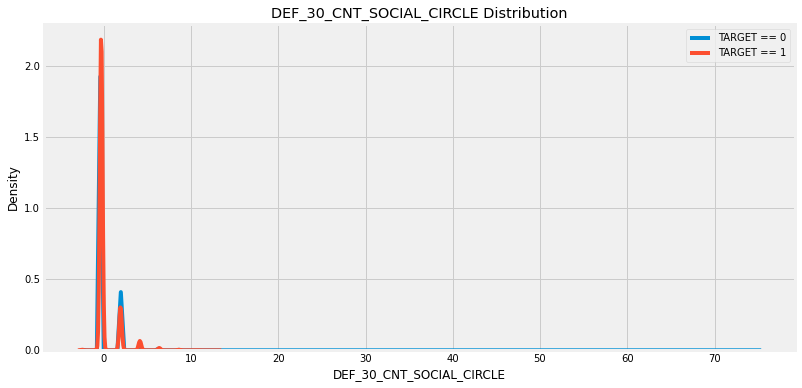

In [1588]:
## Yao-Johnson変換後の特徴量の分布
kde_target('DEF_30_CNT_SOCIAL_CIRCLE', app_train)

### OBS_60_CNT_SOCIAL_CIRCLE

In [1589]:
### Originから切り戻し
app_train['OBS_60_CNT_SOCIAL_CIRCLE'] = app_train_origin['OBS_60_CNT_SOCIAL_CIRCLE'].copy()
app_test['OBS_60_CNT_SOCIAL_CIRCLE'] = app_test_origin['OBS_60_CNT_SOCIAL_CIRCLE'].copy()
app_train['OBS_60_CNT_SOCIAL_CIRCLE'].isnull().sum()

1021

In [1590]:
app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts()

0.0      164666
1.0       48870
2.0       29766
3.0       20215
4.0       13946
5.0        9463
6.0        6349
7.0        4344
8.0        2886
9.0        1959
10.0       1335
11.0        837
12.0        620
13.0        401
14.0        238
15.0        166
16.0        137
17.0         73
18.0         49
19.0         44
20.0         30
21.0         28
22.0         20
23.0         13
24.0         12
25.0         11
27.0          5
29.0          2
28.0          1
47.0          1
344.0         1
30.0          1
26.0          1
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64

In [1591]:
app_train[['OBS_60_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

OBS_60_CNT_SOCIAL_CIRCLE    TARGET
OBS_60_CNT_SOCIAL_CIRCLE                  1.000000  0.009022
TARGET                                    0.009022  1.000000

In [1592]:
### -999埋めで欠損値補完
app_train['OBS_60_CNT_SOCIAL_CIRCLE'] = app_train['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(-1)
app_test['OBS_60_CNT_SOCIAL_CIRCLE'] = app_test['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(-1)
app_train['OBS_60_CNT_SOCIAL_CIRCLE'].isnull().sum()

0

In [1593]:
app_train[['OBS_60_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

OBS_60_CNT_SOCIAL_CIRCLE   TARGET
OBS_60_CNT_SOCIAL_CIRCLE                   1.00000  0.00956
TARGET                                     0.00956  1.00000

The correlation between OBS_60_CNT_SOCIAL_CIRCLE and the TARGET is 0.0096
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


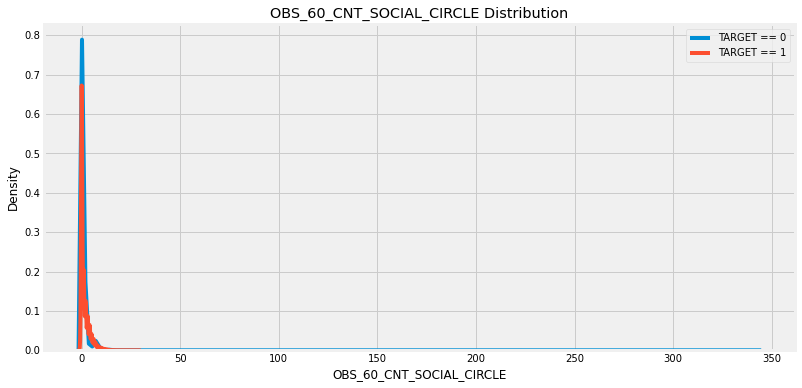

In [1594]:
## 特徴量の分布
kde_target('OBS_60_CNT_SOCIAL_CIRCLE', app_train)

In [1595]:
## Yao-Johnson変換
num_cols = ['OBS_60_CNT_SOCIAL_CIRCLE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['OBS_60_CNT_SOCIAL_CIRCLE'] = pt.transform(app_train[num_cols])
app_test['OBS_60_CNT_SOCIAL_CIRCLE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'OBS_60_CNT_SOCIAL_CIRCLE']].corr()

TARGET  OBS_60_CNT_SOCIAL_CIRCLE
TARGET                    1.000000                  0.011713
OBS_60_CNT_SOCIAL_CIRCLE  0.011713                  1.000000

In [1596]:
## 標準化
num_cols = ['OBS_60_CNT_SOCIAL_CIRCLE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['OBS_60_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

OBS_60_CNT_SOCIAL_CIRCLE    TARGET
OBS_60_CNT_SOCIAL_CIRCLE                  1.000000  0.011713
TARGET                                    0.011713  1.000000

The correlation between OBS_60_CNT_SOCIAL_CIRCLE and the TARGET is 0.0117
Median value for loan that was not repaid = -0.8149
Median value for loan that was repaid =     -0.8149


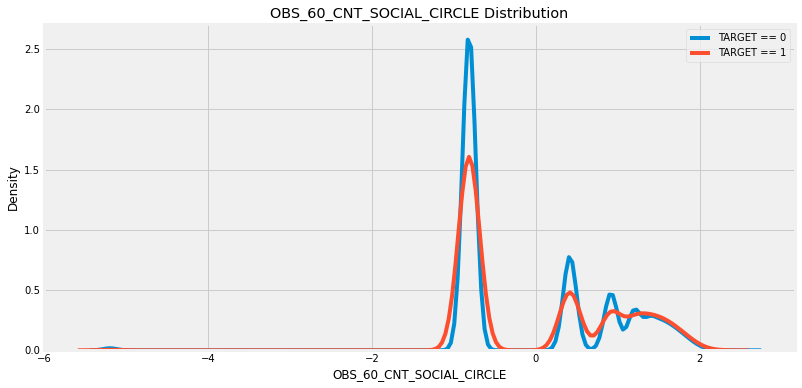

In [1597]:
## Yao-Johnson変換後の特徴量の分布
kde_target('OBS_60_CNT_SOCIAL_CIRCLE', app_train)

### DEF_60_CNT_SOCIAL_CIRCLE

In [1598]:
### Originから切り戻し
app_train['DEF_60_CNT_SOCIAL_CIRCLE'] = app_train_origin['DEF_60_CNT_SOCIAL_CIRCLE'].copy()
app_test['DEF_60_CNT_SOCIAL_CIRCLE'] = app_test_origin['DEF_60_CNT_SOCIAL_CIRCLE'].copy()
app_train['DEF_60_CNT_SOCIAL_CIRCLE'].isnull().sum()

1021

In [1599]:
app_train['DEF_60_CNT_SOCIAL_CIRCLE'].value_counts()

0.0     280721
1.0      21841
2.0       3170
3.0        598
4.0        135
5.0         20
6.0          3
7.0          1
24.0         1
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: int64

In [1600]:
app_train[['DEF_60_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

DEF_60_CNT_SOCIAL_CIRCLE    TARGET
DEF_60_CNT_SOCIAL_CIRCLE                  1.000000  0.031276
TARGET                                    0.031276  1.000000

In [1601]:
### -999埋めで欠損値補完
app_train['DEF_60_CNT_SOCIAL_CIRCLE'] = app_train['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(-1)
app_test['DEF_60_CNT_SOCIAL_CIRCLE'] = app_test['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(-1)
app_train['DEF_60_CNT_SOCIAL_CIRCLE'].isnull().sum()

0

In [1602]:
app_train[['DEF_60_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

DEF_60_CNT_SOCIAL_CIRCLE    TARGET
DEF_60_CNT_SOCIAL_CIRCLE                  1.000000  0.032444
TARGET                                    0.032444  1.000000

In [1603]:
## Yao-Johnson変換
#num_cols = ['DEF_60_CNT_SOCIAL_CIRCLE']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['DEF_60_CNT_SOCIAL_CIRCLE'] = pt.transform(app_train[num_cols])
#app_test['DEF_60_CNT_SOCIAL_CIRCLE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'DEF_60_CNT_SOCIAL_CIRCLE']].corr()

In [1604]:
## 標準化
num_cols = ['DEF_60_CNT_SOCIAL_CIRCLE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['DEF_60_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

DEF_60_CNT_SOCIAL_CIRCLE    TARGET
DEF_60_CNT_SOCIAL_CIRCLE                  1.000000  0.032444
TARGET                                    0.032444  1.000000

The correlation between DEF_60_CNT_SOCIAL_CIRCLE and the TARGET is 0.0324
Median value for loan that was not repaid = -0.2625
Median value for loan that was repaid =     -0.2625


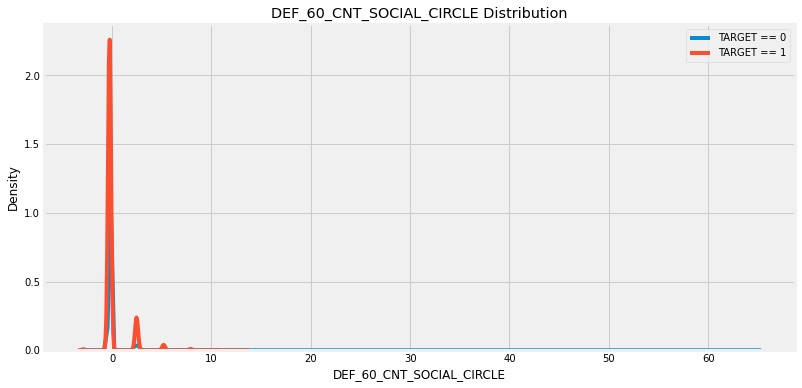

In [1605]:
## Yao-Johnson変換後の特徴量の分布
kde_target('DEF_60_CNT_SOCIAL_CIRCLE', app_train)

### DAYS_LAST_PHONE_CHANGE

In [1606]:
### Originから切り戻し
app_train['DAYS_LAST_PHONE_CHANGE'] = app_train_origin['DAYS_LAST_PHONE_CHANGE'].copy()
app_test['DAYS_LAST_PHONE_CHANGE'] = app_test_origin['DAYS_LAST_PHONE_CHANGE'].copy()
app_train['DAYS_LAST_PHONE_CHANGE'].isnull().sum()

1

In [1607]:
app_train['DAYS_LAST_PHONE_CHANGE'].value_counts()

 0.0       37672
-1.0        2812
-2.0        2318
-3.0        1763
-4.0        1285
           ...  
-4051.0        1
-3593.0        1
-3622.0        1
-3570.0        1
-3538.0        1
Name: DAYS_LAST_PHONE_CHANGE, Length: 3773, dtype: int64

In [1608]:
app_train[['DAYS_LAST_PHONE_CHANGE', 'TARGET']].corr()

DAYS_LAST_PHONE_CHANGE    TARGET
DAYS_LAST_PHONE_CHANGE                1.000000  0.055218
TARGET                                0.055218  1.000000

In [1609]:
### -999埋めで欠損値補完
app_train['DAYS_LAST_PHONE_CHANGE'] = app_train['DAYS_LAST_PHONE_CHANGE'].fillna(1)
app_test['DAYS_LAST_PHONE_CHANGE'] = app_test['DAYS_LAST_PHONE_CHANGE'].fillna(1)
app_train['DAYS_LAST_PHONE_CHANGE'].isnull().sum()

0

In [1610]:
app_train[['DAYS_LAST_PHONE_CHANGE', 'TARGET']].corr()

DAYS_LAST_PHONE_CHANGE    TARGET
DAYS_LAST_PHONE_CHANGE                1.000000  0.055217
TARGET                                0.055217  1.000000

The correlation between DAYS_LAST_PHONE_CHANGE and the TARGET is 0.0552
Median value for loan that was not repaid = -594.0000
Median value for loan that was repaid =     -776.0000


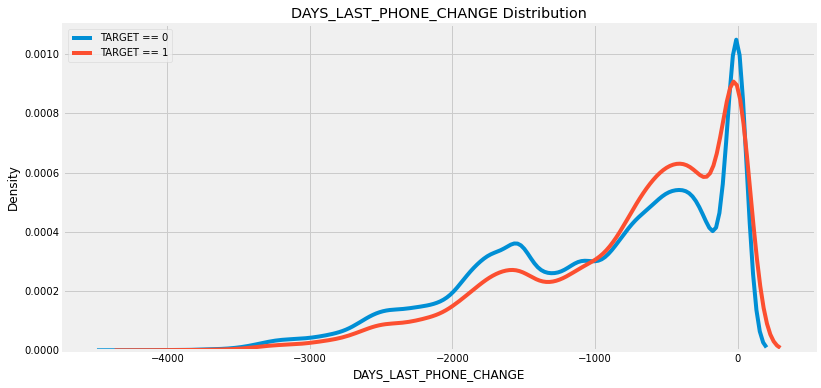

In [1611]:
## 特徴量の分布
kde_target('DAYS_LAST_PHONE_CHANGE', app_train)

In [1612]:
## Yao-Johnson変換
#num_cols = ['DAYS_LAST_PHONE_CHANGE']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['DAYS_LAST_PHONE_CHANGE'] = pt.transform(app_train[num_cols])
#app_test['DAYS_LAST_PHONE_CHANGE'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'DAYS_LAST_PHONE_CHANGE']].corr()

In [1613]:
## 標準化
num_cols = ['DAYS_LAST_PHONE_CHANGE']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['DAYS_LAST_PHONE_CHANGE', 'TARGET']].corr()

DAYS_LAST_PHONE_CHANGE    TARGET
DAYS_LAST_PHONE_CHANGE                1.000000  0.055217
TARGET                                0.055217  1.000000

The correlation between DAYS_LAST_PHONE_CHANGE and the TARGET is 0.0552
Median value for loan that was not repaid = 0.4461
Median value for loan that was repaid =     0.2260


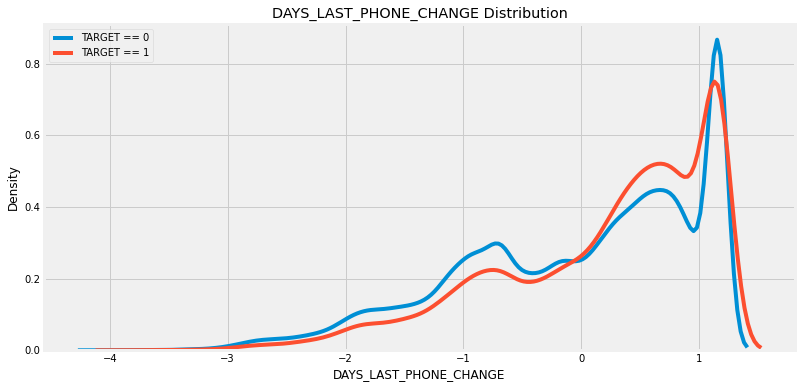

In [1614]:
## Yao-Johnson変換後の特徴量の分布
kde_target('DAYS_LAST_PHONE_CHANGE', app_train)

### FLAG_DOCUMENT_2

In [1615]:
### Originから切り戻し
app_train['FLAG_DOCUMENT_2'] = app_train_origin['FLAG_DOCUMENT_2'].copy()
app_test['FLAG_DOCUMENT_2'] = app_test_origin['FLAG_DOCUMENT_2'].copy()
app_train['FLAG_DOCUMENT_2'].isnull().sum()

0

In [1616]:
app_train['FLAG_DOCUMENT_2'].value_counts()

0    307498
1        13
Name: FLAG_DOCUMENT_2, dtype: int64

In [1617]:
app_train[['FLAG_DOCUMENT_2', 'TARGET']].corr()

FLAG_DOCUMENT_2    TARGET
FLAG_DOCUMENT_2         1.000000  0.005417
TARGET                  0.005417  1.000000

In [1618]:
## Yao-Johnson変換
num_cols = ['FLAG_DOCUMENT_2']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['FLAG_DOCUMENT_2'] = pt.transform(app_train[num_cols])
app_test['FLAG_DOCUMENT_2'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'FLAG_DOCUMENT_2']].corr()

TARGET  FLAG_DOCUMENT_2
TARGET           1.000000         0.005417
FLAG_DOCUMENT_2  0.005417         1.000000

### FLAG_DOCUMENT_3

In [1619]:
### Originから切り戻し
app_train['FLAG_DOCUMENT_3'] = app_train_origin['FLAG_DOCUMENT_3'].copy()
app_test['FLAG_DOCUMENT_3'] = app_test_origin['FLAG_DOCUMENT_3'].copy()
app_train['FLAG_DOCUMENT_3'].isnull().sum()

0

In [1620]:
app_train['FLAG_DOCUMENT_3'].value_counts()

1    218340
0     89171
Name: FLAG_DOCUMENT_3, dtype: int64

In [1621]:
app_train[['FLAG_DOCUMENT_3', 'TARGET']].corr()

FLAG_DOCUMENT_3    TARGET
FLAG_DOCUMENT_3         1.000000  0.044346
TARGET                  0.044346  1.000000

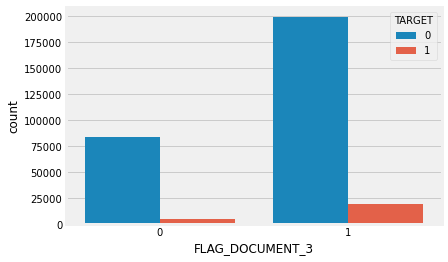

In [1622]:
### ヒストグラム(TARGET比較)
%matplotlib inline
sns.countplot(x='FLAG_DOCUMENT_3', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### FLAG_DOCUMENT_4

In [1623]:
### Originから切り戻し
app_train['FLAG_DOCUMENT_4'] = app_train_origin['FLAG_DOCUMENT_4'].copy()
app_test['FLAG_DOCUMENT_4'] = app_test_origin['FLAG_DOCUMENT_4'].copy()
app_train['FLAG_DOCUMENT_4'].isnull().sum()

0

In [1624]:
app_train['FLAG_DOCUMENT_4'].value_counts()

0    307486
1        25
Name: FLAG_DOCUMENT_4, dtype: int64

In [1625]:
app_train[['FLAG_DOCUMENT_4', 'TARGET']].corr()

FLAG_DOCUMENT_4    TARGET
FLAG_DOCUMENT_4         1.000000 -0.002672
TARGET                 -0.002672  1.000000

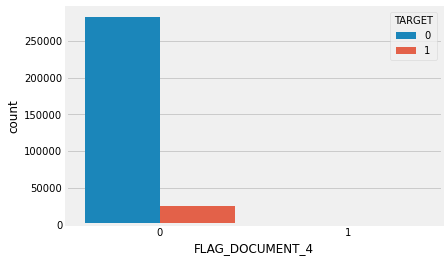

In [1626]:
### ヒストグラム(TARGET比較)
%matplotlib inline
sns.countplot(x='FLAG_DOCUMENT_4', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### FLAG_DOCUMENT_5

In [1627]:
### Originから切り戻し
app_train['FLAG_DOCUMENT_5'] = app_train_origin['FLAG_DOCUMENT_5'].copy()
app_test['FLAG_DOCUMENT_5'] = app_test_origin['FLAG_DOCUMENT_5'].copy()
app_train['FLAG_DOCUMENT_5'].isnull().sum()

0

In [1628]:
app_train['FLAG_DOCUMENT_5'].value_counts()

0    302863
1      4648
Name: FLAG_DOCUMENT_5, dtype: int64

In [1629]:
app_train[['FLAG_DOCUMENT_5', 'TARGET']].corr()

FLAG_DOCUMENT_5    TARGET
FLAG_DOCUMENT_5         1.000000 -0.000316
TARGET                 -0.000316  1.000000

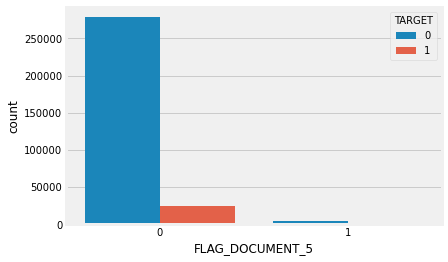

In [1630]:
### ヒストグラム(TARGET比較)
%matplotlib inline
sns.countplot(x='FLAG_DOCUMENT_5', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### FLAG_DOCUMENT_6

In [1631]:
### Originから切り戻し
app_train['FLAG_DOCUMENT_6'] = app_train_origin['FLAG_DOCUMENT_6'].copy()
app_test['FLAG_DOCUMENT_6'] = app_test_origin['FLAG_DOCUMENT_6'].copy()
app_train['FLAG_DOCUMENT_6'].isnull().sum()

0

In [1632]:
app_train['FLAG_DOCUMENT_6'].value_counts()

0    280433
1     27078
Name: FLAG_DOCUMENT_6, dtype: int64

In [1633]:
app_train[['FLAG_DOCUMENT_6', 'TARGET']].corr()

FLAG_DOCUMENT_6    TARGET
FLAG_DOCUMENT_6         1.000000 -0.028602
TARGET                 -0.028602  1.000000

### FLAG_DOCUMENT_7

In [1634]:
### Originから切り戻し
app_train['FLAG_DOCUMENT_7'] = app_train_origin['FLAG_DOCUMENT_7'].copy()
app_test['FLAG_DOCUMENT_7'] = app_test_origin['FLAG_DOCUMENT_7'].copy()
app_train['FLAG_DOCUMENT_7'].isnull().sum()

0

In [1635]:
app_train['FLAG_DOCUMENT_7'].value_counts()

0    307452
1        59
Name: FLAG_DOCUMENT_7, dtype: int64

In [1636]:
app_train[['FLAG_DOCUMENT_7', 'TARGET']].corr()

FLAG_DOCUMENT_7   TARGET
FLAG_DOCUMENT_7          1.00000 -0.00152
TARGET                  -0.00152  1.00000

### FLAG_DOCUMENT_8

In [1637]:
app_train[['FLAG_DOCUMENT_8', 'TARGET']].corr()

FLAG_DOCUMENT_8   TARGET
FLAG_DOCUMENT_8          1.00000 -0.00804
TARGET                  -0.00804  1.00000

In [1638]:
columns = ['FLAG_DOCUMENT_8']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_9

In [1639]:
app_train[['FLAG_DOCUMENT_9', 'TARGET']].corr()

FLAG_DOCUMENT_9    TARGET
FLAG_DOCUMENT_9         1.000000 -0.004352
TARGET                 -0.004352  1.000000

In [1640]:
columns = ['FLAG_DOCUMENT_9']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_10

In [1641]:
app_train[['FLAG_DOCUMENT_10', 'TARGET']].corr()

FLAG_DOCUMENT_10    TARGET
FLAG_DOCUMENT_10          1.000000 -0.001414
TARGET                   -0.001414  1.000000

In [1642]:
columns = ['FLAG_DOCUMENT_10']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_11

In [1643]:
app_train[['FLAG_DOCUMENT_11', 'TARGET']].corr()

FLAG_DOCUMENT_11    TARGET
FLAG_DOCUMENT_11          1.000000 -0.004229
TARGET                   -0.004229  1.000000

In [1644]:
columns = ['FLAG_DOCUMENT_11']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_12

In [1645]:
app_train[['FLAG_DOCUMENT_12', 'TARGET']].corr()

FLAG_DOCUMENT_12    TARGET
FLAG_DOCUMENT_12          1.000000 -0.000756
TARGET                   -0.000756  1.000000

In [1646]:
columns = ['FLAG_DOCUMENT_12']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_13

In [1647]:
app_train[['FLAG_DOCUMENT_13', 'TARGET']].corr()

FLAG_DOCUMENT_13    TARGET
FLAG_DOCUMENT_13          1.000000 -0.011583
TARGET                   -0.011583  1.000000

### FLAG_DOCUMENT_14

In [1648]:
app_train[['FLAG_DOCUMENT_14', 'TARGET']].corr()

FLAG_DOCUMENT_14    TARGET
FLAG_DOCUMENT_14          1.000000 -0.009464
TARGET                   -0.009464  1.000000

In [1649]:
columns = ['FLAG_DOCUMENT_14']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_15

In [1650]:
app_train[['FLAG_DOCUMENT_15', 'TARGET']].corr()

FLAG_DOCUMENT_15    TARGET
FLAG_DOCUMENT_15          1.000000 -0.006536
TARGET                   -0.006536  1.000000

In [1651]:
columns = ['FLAG_DOCUMENT_15']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_16

In [1652]:
app_train[['FLAG_DOCUMENT_16', 'TARGET']].corr()

FLAG_DOCUMENT_16    TARGET
FLAG_DOCUMENT_16          1.000000 -0.011615
TARGET                   -0.011615  1.000000

### FLAG_DOCUMENT_17

In [1653]:
app_train[['FLAG_DOCUMENT_17', 'TARGET']].corr()

FLAG_DOCUMENT_17    TARGET
FLAG_DOCUMENT_17          1.000000 -0.003378
TARGET                   -0.003378  1.000000

In [1654]:
columns = ['FLAG_DOCUMENT_17']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_18

In [1655]:
app_train[['FLAG_DOCUMENT_18', 'TARGET']].corr()

FLAG_DOCUMENT_18    TARGET
FLAG_DOCUMENT_18          1.000000 -0.007952
TARGET                   -0.007952  1.000000

In [1656]:
columns = ['FLAG_DOCUMENT_18']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_19

In [1657]:
app_train[['FLAG_DOCUMENT_19', 'TARGET']].corr()

FLAG_DOCUMENT_19    TARGET
FLAG_DOCUMENT_19          1.000000 -0.001358
TARGET                   -0.001358  1.000000

In [1658]:
columns = ['FLAG_DOCUMENT_19']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_20

In [1659]:
app_train[['FLAG_DOCUMENT_20', 'TARGET']].corr()

FLAG_DOCUMENT_20    TARGET
FLAG_DOCUMENT_20          1.000000  0.000215
TARGET                    0.000215  1.000000

In [1660]:
columns = ['FLAG_DOCUMENT_20']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_21

In [1661]:
app_train[['FLAG_DOCUMENT_21', 'TARGET']].corr()

FLAG_DOCUMENT_21    TARGET
FLAG_DOCUMENT_21          1.000000  0.003709
TARGET                    0.003709  1.000000

In [1662]:
columns = ['FLAG_DOCUMENT_21']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### AMT_REQ_CREDIT_BUREAU_HOUR

In [1663]:
### Originから切り戻し
app_train['AMT_REQ_CREDIT_BUREAU_HOUR'] = app_train_origin['AMT_REQ_CREDIT_BUREAU_HOUR'].copy()
app_test['AMT_REQ_CREDIT_BUREAU_HOUR'] = app_test_origin['AMT_REQ_CREDIT_BUREAU_HOUR'].copy()
app_train['AMT_REQ_CREDIT_BUREAU_HOUR'].isnull().sum()

41519

In [1664]:
app_train['AMT_REQ_CREDIT_BUREAU_HOUR'].value_counts()

0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: int64

In [1665]:
app_train[['AMT_REQ_CREDIT_BUREAU_HOUR', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_HOUR   TARGET
AMT_REQ_CREDIT_BUREAU_HOUR                     1.00000  0.00093
TARGET                                         0.00093  1.00000

In [1666]:
### -999埋めで欠損値補完
app_train['AMT_REQ_CREDIT_BUREAU_HOUR'] = app_train['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(-1)
app_test['AMT_REQ_CREDIT_BUREAU_HOUR'] = app_test['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(-1)
app_train['AMT_REQ_CREDIT_BUREAU_HOUR'].isnull().sum()

0

In [1667]:
app_train[['AMT_REQ_CREDIT_BUREAU_HOUR', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_HOUR    TARGET
AMT_REQ_CREDIT_BUREAU_HOUR                    1.000000 -0.031842
TARGET                                       -0.031842  1.000000

In [1668]:
## Yao-Johnson変換
#num_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['AMT_REQ_CREDIT_BUREAU_HOUR'] = pt.transform(app_train[num_cols])
#app_test['AMT_REQ_CREDIT_BUREAU_HOUR'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'AMT_REQ_CREDIT_BUREAU_HOUR']].corr()

In [1669]:
## 標準化
num_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['AMT_REQ_CREDIT_BUREAU_HOUR', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_HOUR    TARGET
AMT_REQ_CREDIT_BUREAU_HOUR                    1.000000 -0.031842
TARGET                                       -0.031842  1.000000

The correlation between AMT_REQ_CREDIT_BUREAU_HOUR and the TARGET is -0.0318
Median value for loan that was not repaid = 0.3671
Median value for loan that was repaid =     0.3671


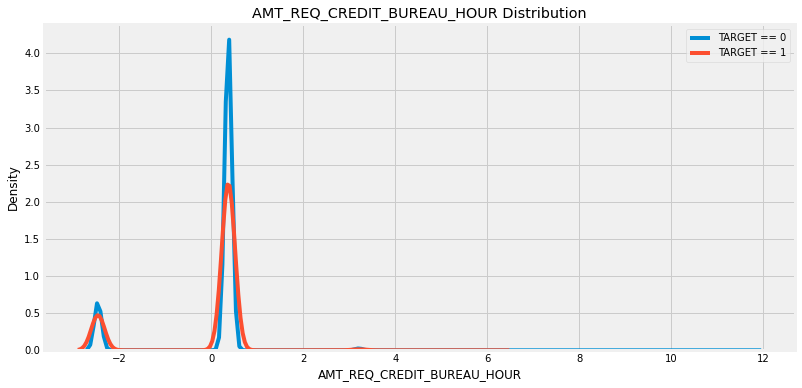

In [1670]:
## Yao-Johnson変換後の特徴量の分布
kde_target('AMT_REQ_CREDIT_BUREAU_HOUR', app_train)

### AMT_REQ_CREDIT_BUREAU_DAY

In [1671]:
### Originから切り戻し
app_train['AMT_REQ_CREDIT_BUREAU_DAY'] = app_train_origin['AMT_REQ_CREDIT_BUREAU_DAY'].copy()
app_test['AMT_REQ_CREDIT_BUREAU_DAY'] = app_test_origin['AMT_REQ_CREDIT_BUREAU_DAY'].copy()
app_train['AMT_REQ_CREDIT_BUREAU_DAY'].isnull().sum()

41519

In [1672]:
app_train['AMT_REQ_CREDIT_BUREAU_DAY'].value_counts()

0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64

In [1673]:
app_train[['AMT_REQ_CREDIT_BUREAU_DAY', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_DAY    TARGET
AMT_REQ_CREDIT_BUREAU_DAY                   1.000000  0.002704
TARGET                                      0.002704  1.000000

In [1674]:
### -999埋めで欠損値補完
app_train['AMT_REQ_CREDIT_BUREAU_DAY'] = app_train['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(-1)
app_test['AMT_REQ_CREDIT_BUREAU_DAY'] = app_test['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(-1)
app_train['AMT_REQ_CREDIT_BUREAU_DAY'].isnull().sum()

0

In [1675]:
app_train[['AMT_REQ_CREDIT_BUREAU_DAY', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_DAY    TARGET
AMT_REQ_CREDIT_BUREAU_DAY                   1.000000 -0.030757
TARGET                                     -0.030757  1.000000

In [1676]:
## Yao-Johnson変換
#num_cols = ['AMT_REQ_CREDIT_BUREAU_DAY']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['AMT_REQ_CREDIT_BUREAU_DAY'] = pt.transform(app_train[num_cols])
#app_test['AMT_REQ_CREDIT_BUREAU_DAY'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'AMT_REQ_CREDIT_BUREAU_DAY']].corr()

In [1677]:
## 標準化
num_cols = ['AMT_REQ_CREDIT_BUREAU_DAY']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['AMT_REQ_CREDIT_BUREAU_DAY', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_DAY    TARGET
AMT_REQ_CREDIT_BUREAU_DAY                   1.000000 -0.030757
TARGET                                     -0.030757  1.000000

The correlation between AMT_REQ_CREDIT_BUREAU_DAY and the TARGET is -0.0308
Median value for loan that was not repaid = 0.3590
Median value for loan that was repaid =     0.3590


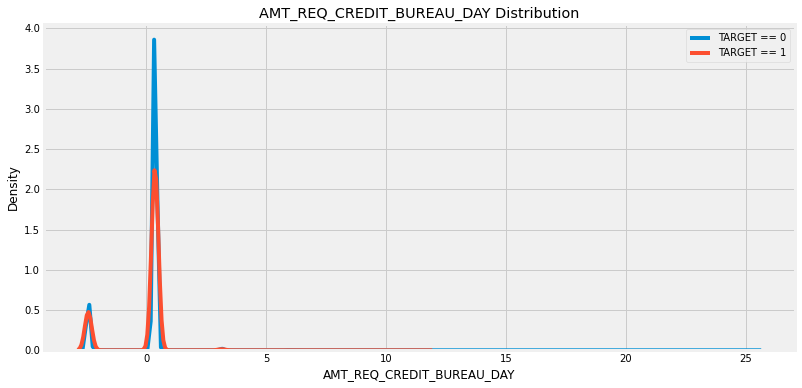

In [1678]:
## Yao-Johnson変換後の特徴量の分布
kde_target('AMT_REQ_CREDIT_BUREAU_DAY', app_train)

### AMT_REQ_CREDIT_BUREAU_WEEK

In [1679]:
### Originから切り戻し
app_train['AMT_REQ_CREDIT_BUREAU_WEEK'] = app_train_origin['AMT_REQ_CREDIT_BUREAU_WEEK'].copy()
app_test['AMT_REQ_CREDIT_BUREAU_WEEK'] = app_test_origin['AMT_REQ_CREDIT_BUREAU_WEEK'].copy()
app_train['AMT_REQ_CREDIT_BUREAU_WEEK'].isnull().sum()

41519

In [1680]:
app_train['AMT_REQ_CREDIT_BUREAU_WEEK'].value_counts()

0.0    257456
1.0      8208
2.0       199
3.0        58
4.0        34
6.0        20
5.0        10
8.0         5
7.0         2
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: int64

In [1681]:
app_train[['AMT_REQ_CREDIT_BUREAU_WEEK', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_WEEK    TARGET
AMT_REQ_CREDIT_BUREAU_WEEK                    1.000000  0.000788
TARGET                                        0.000788  1.000000

In [1682]:
### -999埋めで欠損値補完
app_train['AMT_REQ_CREDIT_BUREAU_WEEK'] = app_train['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(-1)
app_test['AMT_REQ_CREDIT_BUREAU_WEEK'] = app_test['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(-1)
app_train['AMT_REQ_CREDIT_BUREAU_WEEK'].isnull().sum()

0

In [1683]:
app_train[['AMT_REQ_CREDIT_BUREAU_WEEK', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_WEEK    TARGET
AMT_REQ_CREDIT_BUREAU_WEEK                    1.000000 -0.028576
TARGET                                       -0.028576  1.000000

In [1684]:
## Yao-Johnson変換
#num_cols = ['AMT_REQ_CREDIT_BUREAU_WEEK']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['AMT_REQ_CREDIT_BUREAU_WEEK'] = pt.transform(app_train[num_cols])
#app_test['AMT_REQ_CREDIT_BUREAU_WEEK'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'AMT_REQ_CREDIT_BUREAU_WEEK']].corr()

In [1685]:
## 標準化
num_cols = ['AMT_REQ_CREDIT_BUREAU_WEEK']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['AMT_REQ_CREDIT_BUREAU_WEEK', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_WEEK    TARGET
AMT_REQ_CREDIT_BUREAU_WEEK                    1.000000 -0.028576
TARGET                                       -0.028576  1.000000

The correlation between AMT_REQ_CREDIT_BUREAU_WEEK and the TARGET is -0.0286
Median value for loan that was not repaid = 0.2623
Median value for loan that was repaid =     0.2623


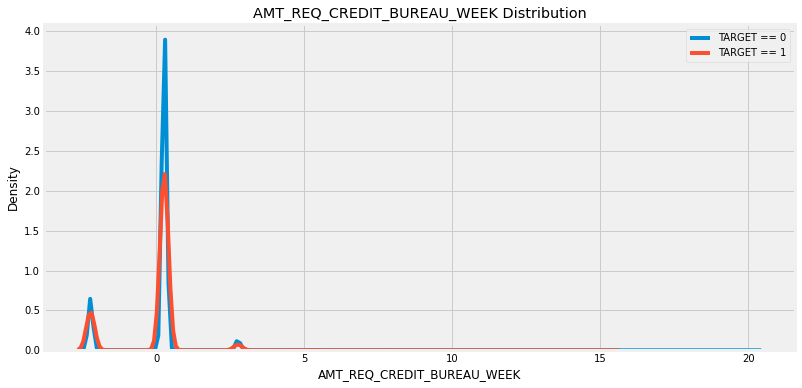

In [1686]:
## Yao-Johnson変換後の特徴量の分布
kde_target('AMT_REQ_CREDIT_BUREAU_WEEK', app_train)

### AMT_REQ_CREDIT_BUREAU_MON

In [1687]:
### Originから切り戻し
app_train['AMT_REQ_CREDIT_BUREAU_MON'] = app_train_origin['AMT_REQ_CREDIT_BUREAU_MON'].copy()
app_test['AMT_REQ_CREDIT_BUREAU_MON'] = app_test_origin['AMT_REQ_CREDIT_BUREAU_MON'].copy()
app_train['AMT_REQ_CREDIT_BUREAU_MON'].isnull().sum()

41519

In [1688]:
app_train['AMT_REQ_CREDIT_BUREAU_MON'].value_counts()

0.0     222233
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
9.0        206
8.0        185
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6
19.0         3
24.0         1
23.0         1
27.0         1
22.0         1
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: int64

In [1689]:
app_train[['AMT_REQ_CREDIT_BUREAU_MON', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_MON    TARGET
AMT_REQ_CREDIT_BUREAU_MON                   1.000000 -0.012462
TARGET                                     -0.012462  1.000000

In [1690]:
### -999埋めで欠損値補完
app_train['AMT_REQ_CREDIT_BUREAU_MON'] = app_train['AMT_REQ_CREDIT_BUREAU_MON'].fillna(-1)
app_test['AMT_REQ_CREDIT_BUREAU_MON'] = app_test['AMT_REQ_CREDIT_BUREAU_MON'].fillna(-1)
app_train['AMT_REQ_CREDIT_BUREAU_MON'].isnull().sum()

0

In [1691]:
app_train[['AMT_REQ_CREDIT_BUREAU_MON', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_MON    TARGET
AMT_REQ_CREDIT_BUREAU_MON                   1.000000 -0.025007
TARGET                                     -0.025007  1.000000

In [1692]:
## Yao-Johnson変換
num_cols = ['AMT_REQ_CREDIT_BUREAU_MON']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['AMT_REQ_CREDIT_BUREAU_MON'] = pt.transform(app_train[num_cols])
app_test['AMT_REQ_CREDIT_BUREAU_MON'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'AMT_REQ_CREDIT_BUREAU_MON']].corr()

TARGET  AMT_REQ_CREDIT_BUREAU_MON
TARGET                     1.000000                  -0.032623
AMT_REQ_CREDIT_BUREAU_MON -0.032623                   1.000000

In [1693]:
## 標準化
num_cols = ['AMT_REQ_CREDIT_BUREAU_MON']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['AMT_REQ_CREDIT_BUREAU_MON', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_MON    TARGET
AMT_REQ_CREDIT_BUREAU_MON                   1.000000 -0.032623
TARGET                                     -0.032623  1.000000

The correlation between AMT_REQ_CREDIT_BUREAU_MON and the TARGET is -0.0326
Median value for loan that was not repaid = 0.0819
Median value for loan that was repaid =     0.0819


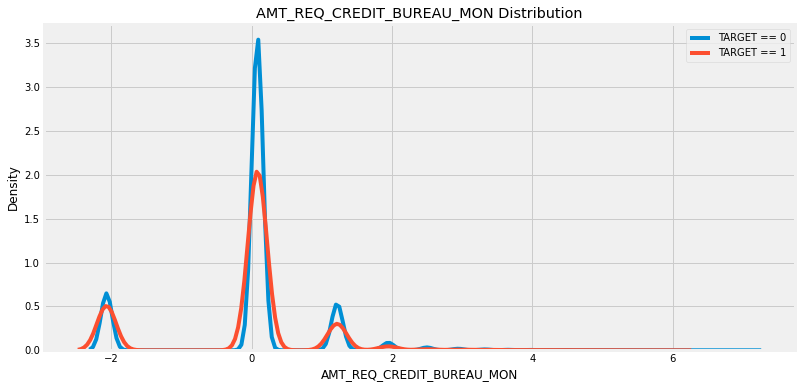

In [1694]:
## Yao-Johnson変換後の特徴量の分布
kde_target('AMT_REQ_CREDIT_BUREAU_MON', app_train)

### AMT_REQ_CREDIT_BUREAU_QRT

In [1695]:
### Originから切り戻し
app_train['AMT_REQ_CREDIT_BUREAU_QRT'] = app_train_origin['AMT_REQ_CREDIT_BUREAU_QRT'].copy()
app_test['AMT_REQ_CREDIT_BUREAU_QRT'] = app_test_origin['AMT_REQ_CREDIT_BUREAU_QRT'].copy()
app_train['AMT_REQ_CREDIT_BUREAU_QRT'].isnull().sum()

41519

In [1696]:
app_train['AMT_REQ_CREDIT_BUREAU_QRT'].value_counts()

0.0      215417
1.0       33862
2.0       14412
3.0        1717
4.0         476
5.0          64
6.0          28
8.0           7
7.0           7
261.0         1
19.0          1
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: int64

In [1697]:
app_train[['AMT_REQ_CREDIT_BUREAU_QRT', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_QRT    TARGET
AMT_REQ_CREDIT_BUREAU_QRT                   1.000000 -0.002022
TARGET                                     -0.002022  1.000000

In [1698]:
### -999埋めで欠損値補完
app_train['AMT_REQ_CREDIT_BUREAU_QRT'] = app_train['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(-1)
app_test['AMT_REQ_CREDIT_BUREAU_QRT'] = app_test['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(-1)
app_train['AMT_REQ_CREDIT_BUREAU_QRT'].isnull().sum()

0

In [1699]:
app_train[['AMT_REQ_CREDIT_BUREAU_QRT', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_QRT    TARGET
AMT_REQ_CREDIT_BUREAU_QRT                   1.000000 -0.018186
TARGET                                     -0.018186  1.000000

In [1700]:
## Yao-Johnson変換
num_cols = ['AMT_REQ_CREDIT_BUREAU_QRT']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['AMT_REQ_CREDIT_BUREAU_QRT'] = pt.transform(app_train[num_cols])
app_test['AMT_REQ_CREDIT_BUREAU_QRT'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'AMT_REQ_CREDIT_BUREAU_QRT']].corr()

TARGET  AMT_REQ_CREDIT_BUREAU_QRT
TARGET                     1.000000                  -0.028171
AMT_REQ_CREDIT_BUREAU_QRT -0.028171                   1.000000

In [1701]:
## 標準化
num_cols = ['AMT_REQ_CREDIT_BUREAU_QRT']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['AMT_REQ_CREDIT_BUREAU_QRT', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_QRT    TARGET
AMT_REQ_CREDIT_BUREAU_QRT                   1.000000 -0.028171
TARGET                                     -0.028171  1.000000

The correlation between AMT_REQ_CREDIT_BUREAU_QRT and the TARGET is -0.0282
Median value for loan that was not repaid = 0.0071
Median value for loan that was repaid =     0.0071


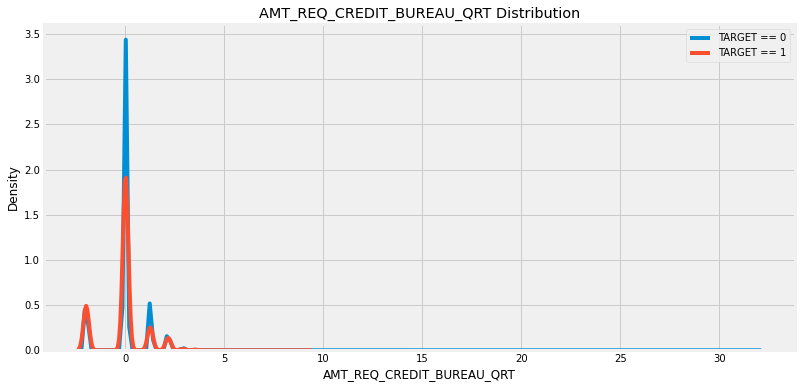

In [1702]:
## Yao-Johnson変換後の特徴量の分布
kde_target('AMT_REQ_CREDIT_BUREAU_QRT', app_train)

### AMT_REQ_CREDIT_BUREAU_YEAR

In [1703]:
### Originから切り戻し
app_train['AMT_REQ_CREDIT_BUREAU_YEAR'] = app_train_origin['AMT_REQ_CREDIT_BUREAU_YEAR'].copy()
app_test['AMT_REQ_CREDIT_BUREAU_YEAR'] = app_test_origin['AMT_REQ_CREDIT_BUREAU_YEAR'].copy()
app_train['AMT_REQ_CREDIT_BUREAU_YEAR'].isnull().sum()

41519

In [1704]:
app_train['AMT_REQ_CREDIT_BUREAU_YEAR'].value_counts()

0.0     71801
1.0     63405
2.0     50192
3.0     33628
4.0     20714
5.0     12052
6.0      6967
7.0      3869
8.0      2127
9.0      1096
11.0       31
12.0       30
10.0       22
13.0       19
14.0       10
17.0        7
15.0        6
19.0        4
18.0        4
16.0        3
25.0        1
23.0        1
22.0        1
21.0        1
20.0        1
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: int64

In [1705]:
app_train[['AMT_REQ_CREDIT_BUREAU_YEAR', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_YEAR   TARGET
AMT_REQ_CREDIT_BUREAU_YEAR                     1.00000  0.01993
TARGET                                         0.01993  1.00000

In [1706]:
### -999埋めで欠損値補完
app_train['AMT_REQ_CREDIT_BUREAU_YEAR'] = app_train['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(-1)
app_test['AMT_REQ_CREDIT_BUREAU_YEAR'] = app_test['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(-1)
app_train['AMT_REQ_CREDIT_BUREAU_YEAR'].isnull().sum()

0

In [1707]:
app_train[['AMT_REQ_CREDIT_BUREAU_YEAR', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_YEAR    TARGET
AMT_REQ_CREDIT_BUREAU_YEAR                    1.000000 -0.000488
TARGET                                       -0.000488  1.000000

In [1708]:
## Yao-Johnson変換
num_cols = ['AMT_REQ_CREDIT_BUREAU_YEAR']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['AMT_REQ_CREDIT_BUREAU_YEAR'] = pt.transform(app_train[num_cols])
app_test['AMT_REQ_CREDIT_BUREAU_YEAR'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'AMT_REQ_CREDIT_BUREAU_YEAR']].corr()

TARGET  AMT_REQ_CREDIT_BUREAU_YEAR
TARGET                      1.000000                   -0.008526
AMT_REQ_CREDIT_BUREAU_YEAR -0.008526                    1.000000

In [1709]:
## 標準化
num_cols = ['AMT_REQ_CREDIT_BUREAU_YEAR']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['AMT_REQ_CREDIT_BUREAU_YEAR', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_YEAR    TARGET
AMT_REQ_CREDIT_BUREAU_YEAR                    1.000000 -0.008526
TARGET                                       -0.008526  1.000000

The correlation between AMT_REQ_CREDIT_BUREAU_YEAR and the TARGET is -0.0085
Median value for loan that was not repaid = -0.0431
Median value for loan that was repaid =     -0.0431


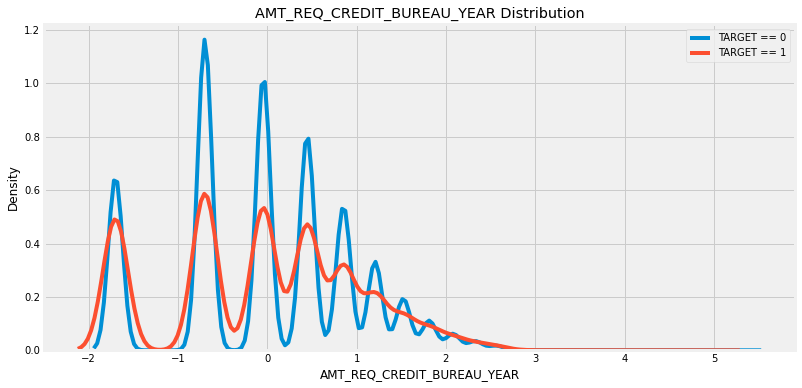

In [1710]:
## Yao-Johnson変換後の特徴量の分布
kde_target('AMT_REQ_CREDIT_BUREAU_YEAR', app_train)

## 特徴量の評価

### 相関係数

In [1718]:
idx2 = np.argsort(np.abs(corrs_sp))[::-1]
top_cols2, top_importances2 = app_train.columns.values[idx][:150], corrs_sp[idx][:150]
print(top_cols2, top_importances2)

['LANDAREA_MEDI' 'NAME_TYPE_SUITE' 'DAYS_REGISTRATION' 'DAYS_EMPLOYED'
 'CNT_CHILDREN' 'LIVINGAREA_MEDI' 'NONLIVINGAPARTMENTS_MODE' 'TARGET'
 'NAME_EDUCATION_TYPE' 'FLAG_MOBIL' 'REGION_RATING_CLIENT_W_CITY'
 'NONLIVINGAPARTMENTS_AVG' 'APARTMENTS_AVG' 'LIVINGAPARTMENTS_MEDI'
 'NAME_HOUSING_TYPE' 'ENTRANCES_MODE' 'OWN_CAR_AGE' 'NONLIVINGAREA_MODE'
 'FLOORSMIN_MEDI' 'NAME_INCOME_TYPE' 'FLOORSMAX_MODE'
 'REGION_RATING_CLIENT' 'LIVINGAREA_AVG' 'EXT_SOURCE_3' 'CNT_FAM_MEMBERS'
 'LIVINGAPARTMENTS_AVG' 'EXT_SOURCE_2' 'FLAG_WORK_PHONE'
 'REG_CITY_NOT_LIVE_CITY' 'FLOORSMAX_AVG' 'LIVE_CITY_NOT_WORK_CITY'
 'FLAG_PHONE' 'ENTRANCES_AVG' 'YEARS_BEGINEXPLUATATION_MODE'
 'REG_REGION_NOT_LIVE_REGION' 'YEARS_BUILD_AVG' 'COMMONAREA_MODE'
 'FLAG_OWN_REALTY' 'ELEVATORS_MODE' 'ELEVATORS_AVG'
 'LIVE_REGION_NOT_WORK_REGION' 'AMT_GOODS_PRICE' 'FLAG_CONT_MOBILE'
 'REG_CITY_NOT_WORK_CITY' 'NONLIVINGAREA_AVG' 'LANDAREA_MODE'
 'APARTMENTS_MODE' 'WEEKDAY_APPR_PROCESS_START' 'BASEMENTAREA_AVG'
 'ENTRANCES_MEDI' 'FLAG

### 相互情報量

In [1719]:
corrs_columns = list(app_test.columns)
corrs_columns.remove('SK_ID_CURR')

corrs = []
border = 0.01
key = ''

try:
    for c in corrs_columns:
        key = c
        corr = np.corrcoef(app_train[c], app_train['TARGET'])[0, 1]
        if math.isnan(corr) == False:
            if abs(corr) >= border:
                corrs.append(corr)
    corrs = np.array(corrs)


    corrs_sp = []
    for c in corrs_columns:
        key = c
        corr_sp = st.spearmanr(app_train[c], app_train['TARGET']).correlation
        if math.isnan(corr_sp) == False:
            if abs(corr_sp) >= border:
                corrs_sp.append(corr_sp)
    corrs_sp = np.array(corrs_sp)

    idx = np.argsort(np.abs(corrs))[::-1]
    top_cols, top_importances = app_train.columns.values[idx], corrs[idx][:150]
    print(top_cols, top_importances)
except NameError as err:
    print(key)
    print("NameError: {0}".format(err))
except TypeError as err:
    print(key)
    print("TypeError: {0}".format(err))
except ValueError as err:
    print(key)
    print("ValueError: {0}".format(err))
except OSError as err:
    print(key)
    print("OS error: {0}".format(err))
except BaseException as err:
    print(f"Unexpected {err=}, {type(err)=}")
    raise

['LANDAREA_MEDI' 'NAME_TYPE_SUITE' 'DAYS_REGISTRATION' 'DAYS_EMPLOYED'
 'CNT_CHILDREN' 'LIVINGAREA_MEDI' 'NONLIVINGAPARTMENTS_MODE' 'TARGET'
 'NAME_EDUCATION_TYPE' 'FLAG_MOBIL' 'REGION_RATING_CLIENT_W_CITY'
 'NONLIVINGAPARTMENTS_AVG' 'APARTMENTS_AVG' 'LIVINGAPARTMENTS_MEDI'
 'NAME_HOUSING_TYPE' 'ENTRANCES_MODE' 'OWN_CAR_AGE' 'NONLIVINGAREA_MODE'
 'FLOORSMIN_MEDI' 'NAME_INCOME_TYPE' 'FLOORSMAX_MODE'
 'REGION_RATING_CLIENT' 'LIVINGAREA_AVG' 'EXT_SOURCE_3' 'CNT_FAM_MEMBERS'
 'LIVINGAPARTMENTS_AVG' 'EXT_SOURCE_2' 'FLAG_WORK_PHONE'
 'REG_CITY_NOT_LIVE_CITY' 'FLOORSMAX_AVG' 'LIVE_CITY_NOT_WORK_CITY'
 'FLAG_PHONE' 'ENTRANCES_AVG' 'YEARS_BEGINEXPLUATATION_MODE'
 'REG_REGION_NOT_LIVE_REGION' 'YEARS_BUILD_AVG' 'COMMONAREA_MODE'
 'FLAG_OWN_REALTY' 'ELEVATORS_MODE' 'ELEVATORS_AVG'
 'LIVE_REGION_NOT_WORK_REGION' 'AMT_GOODS_PRICE' 'FLAG_CONT_MOBILE'
 'REG_CITY_NOT_WORK_CITY' 'NONLIVINGAREA_AVG' 'LANDAREA_MODE'
 'APARTMENTS_MODE' 'WEEKDAY_APPR_PROCESS_START' 'BASEMENTAREA_AVG'
 'ENTRANCES_MEDI' 'FLAG

In [845]:
#mi = mutual_info_classif(app_train, app_train['TARGET'])
#
#idx = np.argsort(mi)[::-1]
#mi_top_cols, mi_top_importances = app_train.columns.values[idx], corrs[idx][:100]
#
#print(mi_top_cols, mi_top_importances)

### 変数選択

In [1720]:
app_train_bak = app_train.copy()
app_test_bak = app_test.copy()

In [1722]:
app_train_columns = top_cols.tolist().copy()
if 'SK_ID_CURR' not in app_train_columns:
    app_train_columns.append('SK_ID_CURR')
if 'TARGET' not in app_train_columns:
    app_train_columns.append('TARGET')

    
app_test_columns = top_cols.tolist().copy()
if 'SK_ID_CURR' not in app_test_columns:
    app_test_columns.append('SK_ID_CURR')
if 'TARGET' in app_test_columns:
    app_test_columns.remove('TARGET')

#app_train_columns

['LANDAREA_MEDI',
 'NAME_TYPE_SUITE',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'CNT_CHILDREN',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'TARGET',
 'NAME_EDUCATION_TYPE',
 'FLAG_MOBIL',
 'REGION_RATING_CLIENT_W_CITY',
 'NONLIVINGAPARTMENTS_AVG',
 'APARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'NAME_HOUSING_TYPE',
 'ENTRANCES_MODE',
 'OWN_CAR_AGE',
 'NONLIVINGAREA_MODE',
 'FLOORSMIN_MEDI',
 'NAME_INCOME_TYPE',
 'FLOORSMAX_MODE',
 'REGION_RATING_CLIENT',
 'LIVINGAREA_AVG',
 'EXT_SOURCE_3',
 'CNT_FAM_MEMBERS',
 'LIVINGAPARTMENTS_AVG',
 'EXT_SOURCE_2',
 'FLAG_WORK_PHONE',
 'REG_CITY_NOT_LIVE_CITY',
 'FLOORSMAX_AVG',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_PHONE',
 'ENTRANCES_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'REG_REGION_NOT_LIVE_REGION',
 'YEARS_BUILD_AVG',
 'COMMONAREA_MODE',
 'FLAG_OWN_REALTY',
 'ELEVATORS_MODE',
 'ELEVATORS_AVG',
 'LIVE_REGION_NOT_WORK_REGION',
 'AMT_GOODS_PRICE',
 'FLAG_CONT_MOBILE',
 'REG_CITY_NOT_WORK_CITY',
 'NONLIVINGAREA_AVG',
 'LANDAREA_MODE',
 'APARTMENTS

In [53]:
#app_test_columns

In [1725]:
#app_train = app_train[app_train_columns].copy()
#app_test = app_test[app_test_columns].copy()
#app_train.head()

LANDAREA_MEDI  NAME_TYPE_SUITE  DAYS_REGISTRATION  DAYS_EMPLOYED  \
0       1.203650                0           0.379837         -637.0   
1       1.199766                1           1.078697        -1188.0   
2      -0.827100                0           0.206116         -225.0   
3      -0.827100                0          -1.375829        -3039.0   
4      -0.827100                0           0.191639        -3038.0   

   CNT_CHILDREN  LIVINGAREA_MEDI  NONLIVINGAPARTMENTS_MODE  TARGET  \
0             0         0.975354                  1.506565       1   
1             0         0.985873                  1.506565       0   
2             0        -0.995749                 -0.663503       0   
3             0        -0.995749                 -0.663503       0   
4             0        -0.995749                 -0.663503       0   

   NAME_EDUCATION_TYPE  FLAG_MOBIL  ...  DAYS_ID_PUBLISH  DAYS_BIRTH  \
0                    0           1  ...         0.579154   -1.506880   
1                    1           1  ...         1.790855    0.166821   
2                    0           1  ...         0.306869    0.689509   
3                    0           1  ...         0.369143    0.680114   
4                    0           1  ...        -0.307263    0.892535   

   NAME_CONTRACT_TYPE  CODE_GENDER  AMT_ANNUITY  FLOORSMIN_MODE  \
0                   0            0    -0.088844          0.1250   
1                   0            1     0.670508          0.3333   
2                   1            0    -1.666947             NaN   
3                   0            1     0.266951             NaN   
4                   0            0    -0.301776             NaN   

   LIVINGAPARTMENTS_MODE  YEARS_BEGINEXPLUATATION_MEDI  BASEMENTAREA_MEDI  \
0               1.188621                      0.973233          -0.726610   
1               1.556671                      0.978441          -0.377455   
2              -0.668443                     -1.024592                NaN   
3              -0.668443                     -1.024592                NaN   
4              -0.668443                     -1.024592                NaN   

   AMT_CREDIT  
0   -0.478095  
1    1.725450  
2   -1.152888  
3   -0.711430  
4   -0.213734  

[5 rows x 84 columns]

## applicationをEXPORT

In [1726]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/app_train.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1728]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/app_test.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

### モデルを生成

In [1729]:
#delete_columns = ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR','NAME_TYPE_SUITE','OWN_CAR_AGE']
#app_train.drop(delete_columns, axis=1, inplace=True)

In [1730]:
columns = list(app_train.columns)
columns.remove('TARGET')
#columns

In [1731]:
#app_test['NAME_CONTRACT_TYPE'].value_counts()
#app_test['CODE_GENDER'].value_counts()
#app_test['FLAG_OWN_CAR'].value_counts()
#app_test['FLAG_OWN_REALTY'].value_counts()
#app_test['CNT_CHILDREN'].value_counts()
#app_test['AMT_INCOME_TOTAL'].value_counts()
#app_test['AMT_CREDIT'].value_counts()
#app_test['AMT_ANNUITY'].value_counts()
#app_test['AMT_GOODS_PRICE'].value_counts()
#app_test['NAME_INCOME_TYPE'].value_counts()
#app_test['NAME_EDUCATION_TYPE'].value_counts()
#app_test['NAME_FAMILY_STATUS'].value_counts()
#app_test['NAME_HOUSING_TYPE'].value_counts()
#app_test['REGION_POPULATION_RELATIVE'].value_counts()
#app_test['DAYS_BIRTH'].value_counts()
#app_test['DAYS_EMPLOYED'].value_counts()
#app_test['OCCUPATION_TYPE'].value_counts()
#app_test['CNT_FAM_MEMBERS'].value_counts()
#app_test['REGION_RATING_CLIENT'].value_counts()
#app_test['REGION_RATING_CLIENT_W_CITY'].value_counts()
#app_test['EXT_SOURCE_1'].value_counts()
#app_test['EXT_SOURCE_2'].value_counts()
#app_test['EXT_SOURCE_3'].value_counts()
#app_test['credit_annuity_ratio'].value_counts()

In [856]:
#num_cols = ['max_credit_day_overdue', 'max_days_credit_enddate', 'min_days_enddate_fact', 'max_amt_credit_max_overdue', 'cnt_credit_prolong_in_6month', 'sum_amt_credit_sum', 'sum_amt_credit_sum_debt', 'sum_amt_credit_sum_limit', 'sum_amt_credit_sum_overdue', 'avg_amt_annuity']

#data = pd.concat([app_train, app_test], sort=False)
#train = data[:len(app_train)]
#test = data[len(app_test):]


#y_train = train['TARGET']
#X_train = app_train.copy().drop('TARGET', axis=1)
#X_test = app_test.copy()

# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(X_train[num_cols])

# 変換後のデータで各列を置換
#X_train[num_cols] = pt.transform(X_train[num_cols])
#X_test[num_cols] = pt.transform(X_test[num_cols])

#X_train.head()

In [857]:
#y_preds = []
#models = []
#oof_train = np.zeros((len(X_train),))
#cv = KFold(n_splits=5, shuffle=True, random_state=0)

#categorical_features = columns

#params = {
#    'boosting_type': 'gbdt',  # default = 'gbdt'
#    'objective': 'binary',
#    'max_bin': 100,           #https://qiita.com/tanreinama/items/5e3eca5cf5e01169e5da
#    'learning_rate': 0.05,
#    'num_leaves': 80,
#    "early_stopping_round": 300,
#    'learning_rate': 0.01,    # default = 0.1
#    'feature_fraction': 0.8,  # default = 1.0
#    'bagging_freq': 1,        # default = 0
#    'bagging_fraction': 0.8,  # default = 1.0
#    'random_state': 0,        # default = None
#    #'device': 'gpu',
#    #'gpu_platform_id': 0,
#    #'gpu_device_id': 0,
#}

#for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
#    X_tr = X_train.loc[train_index, :]
#    X_val = X_train.loc[valid_index, :]
#    y_tr = y_train[train_index]
#    y_val = y_train[valid_index]
#    
#    lgb_train = lgb.Dataset(X_tr, y_tr,
#                                            categorical_feature=categorical_features)
#    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
#                                            categorical_feature=categorical_features)
#
#    model = lgb.train(params, lgb_train,
#                                   valid_sets=[lgb_train, lgb_eval],
#                                   #verbose_eval=10,
#                                   num_boost_round=1000,
#                                 )
#
#    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
#    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
#
#    y_preds.append(y_pred)
#    models.append(model)

In [858]:
# https://boomin.yokohama/archives/1482
# https://lightgbm.readthedocs.io/en/latest/GPU-Tutorial.html

In [1732]:
#num_cols = ['max_credit_day_overdue', 'max_days_credit_enddate', 'min_days_enddate_fact', 'max_amt_credit_max_overdue', 'cnt_credit_prolong_in_6month', 'sum_amt_credit_sum', 'sum_amt_credit_sum_debt', 'sum_amt_credit_sum_limit', 'sum_amt_credit_sum_overdue', 'avg_amt_annuity']

data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(X_train[num_cols])

# 変換後のデータで各列を置換
#X_train[num_cols] = pt.transform(X_train[num_cols])
#X_test[num_cols] = pt.transform(X_test[num_cols])

X_train.head()

LANDAREA_MEDI  NAME_TYPE_SUITE  DAYS_REGISTRATION  DAYS_EMPLOYED  \
0       1.203650                0           0.379837         -637.0   
1       1.199766                1           1.078697        -1188.0   
2      -0.827100                0           0.206116         -225.0   
3      -0.827100                0          -1.375829        -3039.0   
4      -0.827100                0           0.191639        -3038.0   

   CNT_CHILDREN  LIVINGAREA_MEDI  NONLIVINGAPARTMENTS_MODE  \
0             0         0.975354                  1.506565   
1             0         0.985873                  1.506565   
2             0        -0.995749                 -0.663503   
3             0        -0.995749                 -0.663503   
4             0        -0.995749                 -0.663503   

   NAME_EDUCATION_TYPE  FLAG_MOBIL  REGION_RATING_CLIENT_W_CITY  ...  \
0                    0           1                            2  ...   
1                    1           1                            1  ...   
2                    0           1                            2  ...   
3                    0           1                            2  ...   
4                    0           1                            2  ...   

   DAYS_ID_PUBLISH  DAYS_BIRTH  NAME_CONTRACT_TYPE  CODE_GENDER  AMT_ANNUITY  \
0         0.579154   -1.506880                   0            0    -0.088844   
1         1.790855    0.166821                   0            1     0.670508   
2         0.306869    0.689509                   1            0    -1.666947   
3         0.369143    0.680114                   0            1     0.266951   
4        -0.307263    0.892535                   0            0    -0.301776   

   FLOORSMIN_MODE  LIVINGAPARTMENTS_MODE  YEARS_BEGINEXPLUATATION_MEDI  \
0          0.1250               1.188621                      0.973233   
1          0.3333               1.556671                      0.978441   
2             NaN              -0.668443                     -1.024592   
3             NaN              -0.668443                     -1.024592   
4             NaN              -0.668443                     -1.024592   

   BASEMENTAREA_MEDI  AMT_CREDIT  
0          -0.726610   -0.478095  
1          -0.377455    1.725450  
2                NaN   -1.152888  
3                NaN   -0.711430  
4                NaN   -0.213734  

[5 rows x 83 columns]

In [1733]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[23:12:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.72458	eval-auc:0.71430
[1]	train-auc:0.73688	eval-auc:0.72245
[2]	train-auc:0.74192	eval-auc:0.72752
[3]	train-auc:0.75018	eval-auc:0.73156
[4]	train-auc:0.75193	eval-auc:0.73220
[5]	train-auc:0.75463	eval-auc:0.73300
[6]	train-auc:0.75702	eval-auc:0.73432
[7]	train-auc:0.75929	eval-auc:0.73613
[8]	train-auc:0.76046	eval-auc:0.73603
[9]	train-auc:0.76139	eval-auc:0.73619
[10]	train-auc:0.76282	eval-auc:0.73606
[11]	train-auc:0.76421	eval-auc:0.73642
[12]	train-auc:0.76509	eval-auc:0.73705
[13]	train-auc:0.76712	eval-auc:0.73787
[14

[12]	train-auc:0.76640	eval-auc:0.73427
[13]	train-auc:0.76847	eval-auc:0.73546
[14]	train-auc:0.77017	eval-auc:0.73649
[15]	train-auc:0.77264	eval-auc:0.73747
[16]	train-auc:0.77455	eval-auc:0.73770
[17]	train-auc:0.77577	eval-auc:0.73845
[18]	train-auc:0.77684	eval-auc:0.73863
[19]	train-auc:0.77821	eval-auc:0.73905
[20]	train-auc:0.77936	eval-auc:0.73906
[21]	train-auc:0.78055	eval-auc:0.73985
[22]	train-auc:0.78197	eval-auc:0.74036
[23]	train-auc:0.78319	eval-auc:0.74072
[24]	train-auc:0.78488	eval-auc:0.74123
[25]	train-auc:0.78625	eval-auc:0.74206
[26]	train-auc:0.78691	eval-auc:0.74207
[27]	train-auc:0.78802	eval-auc:0.74212
[28]	train-auc:0.78860	eval-auc:0.74186
[29]	train-auc:0.79006	eval-auc:0.74208
[30]	train-auc:0.79093	eval-auc:0.74231
[31]	train-auc:0.79226	eval-auc:0.74248
[32]	train-auc:0.79345	eval-auc:0.74282
[33]	train-auc:0.79448	eval-auc:0.74314
[34]	train-auc:0.79540	eval-auc:0.74346
[35]	train-auc:0.79672	eval-auc:0.74386
[36]	train-auc:0.79798	eval-auc:0.74411


In [1734]:
scores

[0.2452341002217511,
 0.24876185636548262,
 0.2495786066682735,
 0.25062981717099087,
 0.25062301101111606]

In [1735]:
# CSV-00
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[0]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_00.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1736]:
# CSV-01
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[1]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_01.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1737]:
# CSV-02
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[2]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_02.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1738]:
# CSV-03
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[3]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_03.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1739]:
# CSV-04
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[4]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_04.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1740]:
submit_all_00 = pd.read_csv('./home-credit-default-risk/submit/submit_all_00.csv')
submit_all_01 = pd.read_csv('./home-credit-default-risk/submit/submit_all_01.csv')
submit_all_02 = pd.read_csv('./home-credit-default-risk/submit/submit_all_02.csv')
submit_all_03 = pd.read_csv('./home-credit-default-risk/submit/submit_all_03.csv')
submit_all_04 = pd.read_csv('./home-credit-default-risk/submit/submit_all_04.csv')

In [1741]:
submit_all = pd.DataFrame({
    'submit_all_00': submit_all_00['TARGET'].values
    ,'submit_all_01': submit_all_01['TARGET'].values
    ,'submit_all_02': submit_all_02['TARGET'].values
    ,'submit_all_03': submit_all_03['TARGET'].values
    ,'submit_all_04': submit_all_04['TARGET'].values
    })
submit_all.head()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  submit_all_04
0       0.046544       0.048240       0.054367       0.069644       0.055286
1       0.109058       0.077035       0.086830       0.086448       0.092708
2       0.032491       0.029613       0.030071       0.025091       0.035582
3       0.043396       0.049933       0.036429       0.046729       0.032611
4       0.116699       0.147561       0.120627       0.128368       0.143406

In [1742]:
submit_all.corr()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  \
submit_all_00       1.000000       0.938552       0.941569       0.942585   
submit_all_01       0.938552       1.000000       0.941287       0.941911   
submit_all_02       0.941569       0.941287       1.000000       0.944953   
submit_all_03       0.942585       0.941911       0.944953       1.000000   
submit_all_04       0.937079       0.938656       0.939838       0.940040   

               submit_all_04  
submit_all_00       0.937079  
submit_all_01       0.938656  
submit_all_02       0.939838  
submit_all_03       0.940040  
submit_all_04       1.000000

In [1743]:
submit_all = app_test[["SK_ID_CURR"]].copy()
submit_all['TARGET'] = (submit_all_00['TARGET'] + submit_all_01['TARGET'] + submit_all_02['TARGET'] + submit_all_03['TARGET'] + submit_all_04['TARGET'])/5
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.054816
1      100005  0.090416
2      100013  0.030570
3      100028  0.041820
4      100038  0.131332

In [1744]:
len(submit_all)

48744

In [1745]:
len(app_test)

48744

In [1746]:
submit_all['TARGET'] = (submit_all['TARGET'] / 5)
submit_all.to_csv('./home-credit-default-risk/submit/hcr_app_res_01.csv', index=False)
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.010963
1      100005  0.018083
2      100013  0.006114
3      100028  0.008364
4      100038  0.026266